# SALIFORT - EMPLOYEE TURNOVER ANALYSIS

#### EARLY- STAGES DEPLOYMENT

To predict an employee's likeliness to resing/being fired based on the model developed in the analysis, employ the (early-stages) model deployment tool [here](ModelDeployment.ipynb).

## PLANNING

### THE COMPANY

Salifort Motors is a French-based alternative energy vehicle manufacturer. It has more than 100,000 employess researching, desing, constructing and distributing electric, solar, algae and hydrogen-based vehicles. Its end-to-end vertical integration model made it a global leader at the intersection of alternative energy and automobiles.

### STAKEHOLDERS

The stakeholders are the managers in the HR dept at Salifort Motors.

### BUSINESS SCENARIO

At the moment, there is a high rate of turnover among Salifort employees. Turnover data comprehend not only employees choosing to quit their job, but also employees who are let go.
The managment is concerned about this tendency, since:
- they strive to build a corporate culture supporting employees success and professional development.
- the high turnover ratio is financially costly, as Salifort invests big in recruting, training and upskilling processes.

### PROJECT'S GOAL

The management team is interested in being able to predict whether an employee will leave the company or not. Plus, they would like to discover the reasons why people leave the company. By doing this, they could develop a tailor-made solution to address this issue and reduce hiring and training costs.
Therefore, the main goal is to build a model able to predict if an employee is likely to leave the company or not. Once this is done, then the factors influencing most the turnover ratio will be disentangled.

### DATA & DATABASE DESCRIPTION

The analyzed database is an open source database about HR data. It can be found [here](https://www.kaggle.com/datasets/mfaisalqureshi/hr-analytics-and-job-prediction?select=HR_comma_sep.csv).  
The dataset is composed of several variables, such as:  
- satisfaction_level
- last_evaluation
- number_project
- average_monthly_hours
- time_spend_company
- work_accident
- left
- promotion_last_5years
- department
- salary  
  
A detailed description of those variables can be found in the relative Data Dictionary (DataDictionary_Salifort.xlsx). 

### PRIVACY & ETHICS ISSUES

Dataset does not include any data containing sensitive information. Indeed, all data are anonymous and can not be linked to any specific employee.

## ANALYZE

### PACKAGES & DATASET LOADING

Loading packages is the first step in any analysis. The following are the needed ones:

In [1]:
# For data manipulation
import numpy as np
import pandas as pd

# For data visualization
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

#for data encoding
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder

# For data modeling
from xgboost import XGBClassifier, XGBRegressor, plot_importance, plot_tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, Lasso, LassoCV
from sklearn.naive_bayes import GaussianNB
from sklearn.datasets import make_moons
from sklearn.cluster import DBSCAN
from sklearn.ensemble import StackingClassifier
from sklearn.svm import SVC #SVM models

#for Neural Network
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import EarlyStopping
import keras_tuner as kt
from tensorflow.keras.metrics import AUC, Precision, Recall
from tensorflow.keras import Input

#for PCA
from sklearn.decomposition import PCA

# For metrics
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report, accuracy_score, precision_score, \
                            recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, \
                            roc_auc_score, roc_curve
from sklearn.tree import plot_tree
import shap
from sklearn.inspection import permutation_importance
from sklearn.metrics import precision_recall_curve #precision-recall tradeoff

# for standardization
from sklearn.preprocessing import StandardScaler

# For saving models
import pickle

# For displaying all of the columns in dataframes, preventing Juptyer from redacting them
pd.set_option('display.max_columns', None)

2025-04-15 16:20:31.004817: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Note. If those are not installed yet, be sure to install it through:  
pip3 install packageName

Then, it is time to load the dataset. The df is located within the folder "in_data" and is called "HR.csv".

Note. the folder could be loaded directly from Kaggle API. More on that on the Kaggle website. 

In [2]:
#load the data
hr = pd.read_csv("in_data/HR.csv")
#show it
hr.head(5)

satisfaction_level  last_evaluation  number_project  average_montly_hours  \
0                0.38             0.53               2                   157   
1                0.80             0.86               5                   262   
2                0.11             0.88               7                   272   
3                0.72             0.87               5                   223   
4                0.37             0.52               2                   159   

   time_spend_company  Work_accident  left  promotion_last_5years Department  \
0                   3              0     1                      0      sales   
1                   6              0     1                      0      sales   
2                   4              0     1                      0      sales   
3                   5              0     1                      0      sales   
4                   3              0     1                      0      sales   

   salary  
0     low  
1  medium  
2  medium  
3     low  
4     low

### FUNCTIONS DEFINITION AND LOADING

Run the code chunks below to define and load the functions used on the analysis:

- QQ-Plots function

In [3]:
# Function to display Q-Q plots for continuous variables
def col_qqplots(df, columns=None):
    """
    Plots Q-Q plots for continuous numerical columns in the DataFrame to assess normality.
    
    Parameters:
    - df: The DataFrame containing the data.
    - columns: List of columns to plot. If None, plots all continuous numeric columns.
    """
    # If no columns are specified, use only float (continuous) columns
    if columns is None:
        columns = df.select_dtypes(include=['float']).columns  # Select only float columns
    
    # Set up the subplots
    num_columns = len(columns)
    fig, axes = plt.subplots(num_columns, 1, figsize=(8, num_columns * 3), squeeze=False)
    
    # Plot Q-Q plots for each column
    for i, column in enumerate(columns):
        stats.probplot(df[column].dropna(), dist="norm", plot=axes[i, 0])  # Q-Q plot against normal distribution
        axes[i, 0].set_title(f'Q-Q Plot of {column}')
        axes[i, 0].set_xlabel('Theoretical Quantiles')
        axes[i, 0].set_ylabel('Sample Quantiles')
    
    plt.tight_layout()
    plt.show()

- Boxplots function

In [4]:
#build a function to displays boxplot
def col_boxplots(df, columns=None):
    """
    Plots individual box plots for each specified column in the DataFrame.
    
    Parameters:
    - df: The DataFrame containing the data.
    - columns: List of columns to plot. If None, plots all numeric columns.
    """
    # If no columns are specified, use all numeric columns
    if columns is None:
        columns = df.select_dtypes(include='number').columns
    
    # Set up the subplots
    num_columns = len(columns)
    fig, axes = plt.subplots(num_columns, 1, figsize=(8, num_columns * 2), squeeze=False)
    
    # Plot each column on a separate subplot
    for i, column in enumerate(columns):
        sns.boxplot(data=df, x=column, ax=axes[i, 0])
        axes[i, 0].set_title(f'Box plot of {column}')
        axes[i, 0].set_xlabel('Values')
        axes[i, 0].set_ylabel(column)
    
    plt.tight_layout()
    plt.show()

- Distribution Plots functions

In [5]:
# Function to display distribution plots
def col_distributions(df, columns=None):
    """
    Plots distribution plots for each specified column in the DataFrame.
    
    Parameters:
    - df: The DataFrame containing the data.
    - columns: List of columns to plot. If None, plots all numeric columns.
    """
    # If no columns are specified, use all numeric columns
    if columns is None:
        columns = df.select_dtypes(include='number').columns
    
    # Set up the subplots
    num_columns = len(columns)
    fig, axes = plt.subplots(num_columns, 1, figsize=(8, num_columns * 3), squeeze=False)
    
    # Plot each column's distribution
    for i, column in enumerate(columns):
        sns.histplot(data=df, x=column, kde=True, ax=axes[i, 0], bins=30)
        axes[i, 0].set_title(f'Distribution of {column}')
        axes[i, 0].set_xlabel('Values')
        axes[i, 0].set_ylabel('Frequency')
    
    plt.tight_layout()
    plt.show()

- Multicollinearity checks (VIF and/or correlation matrix) function

In [6]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
#function to compute either correlation matrix or VIF
def check_multicollinearity(df, method="correlation", threshold=0.7):
    """
    Checks for multicollinearity in the numerical columns of the DataFrame.
    
    Parameters:
        df (pd.DataFrame): The DataFrame containing the data.
        method (str): Method to use for checking multicollinearity.
                      "correlation" - Show correlation matrix with high correlations flagged.
                      "vif" - Compute Variance Inflation Factor (VIF) for numerical columns.
        threshold (float): Correlation threshold for flagging multicollinearity (for correlation method).
    
    Returns:
        pd.DataFrame or dict: Correlation matrix or VIF scores depending on the method.
    """
    # Select only numerical columns
    numerical_df = df.select_dtypes(include=[np.number])
    
    if method == "correlation":
        # Compute the correlation matrix
        corr_matrix = numerical_df.corr()
        # Flag correlations above the threshold
        high_corr = (corr_matrix.abs() >= threshold) & (corr_matrix != 1.0)
        return corr_matrix, high_corr
    
    elif method == "vif":
        # Compute VIF for each numerical column
        vif_data = pd.DataFrame()
        vif_data["feature"] = numerical_df.columns
        vif_data["VIF"] = [variance_inflation_factor(numerical_df.values, i) for i in range(len(numerical_df.columns))]
        return vif_data
    
    else:
        raise ValueError("Invalid method. Use 'correlation' or 'vif'.")

- Outliers checking (Z-score and interquartile method)

In [7]:
#Define a function to check for outliers with IQR range or Z-score
def count_outliers(df, method='iqr', threshold=3):
    outlier_counts = {}

    for column in df.select_dtypes(include=[np.number]).columns:  # Only consider numeric columns
        if method == 'iqr':
            # IQR method
            Q1 = df[column].quantile(0.25)
            Q3 = df[column].quantile(0.75)
            IQR = Q3 - Q1
            outliers = ((df[column] < (Q1 - 1.5 * IQR)) | (df[column] > (Q3 + 1.5 * IQR)))
        elif method == 'zscore':
            # Z-score method
            mean = df[column].mean()
            std_dev = df[column].std()
            z_scores = (df[column] - mean) / std_dev
            outliers = (z_scores.abs() > threshold)
        else:
            raise ValueError("Method must be 'iqr' or 'zscore'")
        
        outlier_counts[column] = outliers.sum()  # Count True values indicating outliers

    return outlier_counts

- Find duplicates

In [8]:
def find_duplicates(df):
    """
    Identifies duplicate rows in a DataFrame where all column values are identical
    and sorts them to appear one below the other for easy comparison.

    Parameters:
        df (pd.DataFrame): The input DataFrame.

    Returns:
        pd.DataFrame: A DataFrame where duplicates appear contiguously.
    """
    # Find all duplicate rows (including first occurrence)
    duplicate_mask = df.duplicated(keep=False)

    # Extract duplicates and sort them
    duplicates_df = df[duplicate_mask].sort_values(by=list(df.columns)).reset_index(drop=True)

    return duplicates_df

- correlation between target variable and explanatory ones

In [9]:
def plot_correlation_with_target(df, target_variable):
    """
    Plots a correlation matrix of all variables in the dataframe with the target variable.
    
    Parameters:
    df (pd.DataFrame): The input dataframe
    target_variable (str): The target variable
    """
    # Compute correlation matrix
    correlation_matrix = df.corr()[[target_variable]].sort_values(by=target_variable, ascending=False)

    # Plot the heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
    plt.title(f"Correlation of Features with {target_variable}")
    plt.show()


- pie chart plotting

In [10]:
def pie_chart(df, column, ax, title):
    """
    Create a pie chart for a given column in the specified subplot axis.
    """
    counts = df[column].value_counts()
    labels = counts.index.astype(str)
    
    ax.pie(counts, labels=labels, autopct='%1.1f%%', colors=['lightblue', 'lightcoral'])
    ax.set_title(title)

- model evaluation (accuracy, precision, recall, f1, ROC-AUC score)

In [11]:
def model_evaluation(model, X_val, y_val, model_name, threshold = 0.5):
    """
    Evaluate a classification model (scikit-learn or Keras), print metrics, and return them in a dictionary.

    Args:
    - model: Trained model (scikit-learn or Keras).
    - X_val: Validation features.
    - y_val: Validation labels.
    - model_name: Name of the model for printing purposes.

    Returns:
    - Dictionary containing evaluation metrics.
    """
    # Predict probabilities and class labels
    if hasattr(model, "predict_proba"):
        # For scikit-learn models with predict_proba
        y_pred_prob = model.predict_proba(X_val)[:, 1]
    elif "keras" in str(type(model)).lower():
        # For Keras models
        y_pred_prob = model.predict(X_val).flatten()
    else:
        # Fallback for models without predict_proba
        y_pred_prob = model.predict(X_val)

    # Ensure we have binary class labels
    if y_pred_prob.ndim > 1 or np.any((y_pred_prob > 0) & (y_pred_prob < 1)):
        y_pred_class = (y_pred_prob >= threshold).astype(int)
    else:
        y_pred_class = y_pred_prob

    # Compute metrics
    accuracy = accuracy_score(y_val, y_pred_class)
    precision = precision_score(y_val, y_pred_class, zero_division=0)
    recall = recall_score(y_val, y_pred_class, zero_division=0)
    f1 = f1_score(y_val, y_pred_class, zero_division=0)
    
    try:
        roc_auc = roc_auc_score(y_val, y_pred_prob)
    except ValueError:
        roc_auc = 0.0

    # Print metrics
    print(f"Evaluation Metrics for {model_name}:")
    print(f"Accuracy     : {accuracy:.4f}")
    print(f"Precision    : {precision:.4f}")
    print(f"Recall       : {recall:.4f}")
    print(f"F1 Score     : {f1:.4f}")
    print(f"ROC AUC Score: {roc_auc:.4f}")
    print("-" * 40)

    # Return as dictionary
    return {
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1": f1,
        "ROC AUC": roc_auc
    }


- Add a new row to the evalMetrics table

In [12]:
def add_evaluation(metrics, model_name):
    global evalMetrics  # Ensure we modify the global DataFrame

    # Convert dictionary into DataFrame
    new_row = pd.DataFrame([metrics])  
    new_row.insert(0, "Model", model_name)  # Insert model name as the first column

    # If evalMetrics doesn't exist or is empty, initialize it with new_row
    if "evalMetrics" not in globals() or evalMetrics.empty:
        evalMetrics = new_row  # Direct assignment for the first row
    else:
        evalMetrics = pd.concat([evalMetrics, new_row], ignore_index=True)  # Append for subsequent rows

    return evalMetrics  # Return updated DataFrame

- Compute and show the confusion matrix

In [13]:
def conf_matrix_plot(model, x_data, y_data, threshold=0.5):
    """
    Plots the confusion matrix for predictions made by the model.
    
    Args:
        model: Trained classifier (can be sklearn or keras).
        x_data: Features for prediction.
        y_data: True labels.
        threshold: Classification threshold for probability outputs (default is 0.5).
    """

    # If the model has predict_proba or outputs probabilities (e.g., Neural Networks)
    if hasattr(model, "predict_proba"):
        y_pred_prob = model.predict_proba(x_data)[:, 1]
        y_pred = (y_pred_prob >= threshold).astype(int)

    elif hasattr(model, "predict"):
        y_pred_raw = model.predict(x_data)
        # If output is probability (e.g. Keras returns shape (n, 1))
        if isinstance(y_pred_raw, np.ndarray) and y_pred_raw.ndim > 1:
            y_pred = (y_pred_raw >= threshold).astype(int).flatten()
        else:
            y_pred = y_pred_raw

    else:
        raise ValueError("Model must have a predict or predict_proba method.")

    # Compute confusion matrix
    cm = confusion_matrix(y_data, y_pred, labels=[0, 1])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
    disp.plot(values_format='')  # Suppress scientific notation

    plt.title("Confusion Matrix")
    plt.grid(False)
    plt.show()


- Compute feature importance 

In [14]:
def feature_importances(model, x_data):
    """
    Extracts and plots feature importances for Decision Tree, Random Forest, and XGBoost models.

    Args:
    - model: Can be the trained model or a GridSearchCV object.
    - x_data: Feature dataset (X_val or X_test).

    Returns:
    - A DataFrame of feature importances sorted in descending order.
    """

    # If model is a GridSearchCV object, extract the best estimator
    if hasattr(model, "best_estimator_"):
        model = model.best_estimator_

    # Check if the model has feature_importances_
    if hasattr(model, "feature_importances_"):
        importances = model.feature_importances_
    else:
        raise AttributeError("This model does not support feature importances.")

    # Create DataFrame
    df_featimp = pd.DataFrame(importances, 
                              columns=['Importance'], 
                              index=x_data.columns)

    # Sort by importance
    df_featimp = df_featimp.sort_values(by='Importance', ascending=False)
    
    return df_featimp


- Plot feature importance

In [15]:
def importances_plot(df_featimp, model = ""):
    '''
    Accepts as argument model object 
    Returns a plot of feature_importances.
    ''' 
    # Plot feature importance
    plt.figure(figsize=(10, 6))
    sns.barplot(x=df_featimp.Importance, y=df_featimp.index, palette="viridis",
                hue=df_featimp.index, legend=False)
    plt.xlabel("Feature Importance")
    plt.ylabel("Feature")
    plt.title(f"{model} Feature Importance")
    plt.show()

- compute integrated gradients (feature importance for Neural Network)

In [16]:
def integrated_gradients(model, input_tensor, baseline=None, steps=50, features=None):
    if baseline is None:
        baseline = tf.zeros(shape=input_tensor.shape)

    # Generate interpolated inputs
    alphas = tf.linspace(start=0.0, stop=1.0, num=steps)
    interpolated = [baseline[0] + alpha * (input_tensor[0] - baseline[0]) for alpha in alphas]
    interpolated = tf.convert_to_tensor(interpolated)

    with tf.GradientTape() as tape:
        tape.watch(interpolated)
        preds = model(interpolated)

    grads = tape.gradient(preds, interpolated)
    avg_grads = tf.reduce_mean(grads, axis=0).numpy()

    # Integrated gradients
    integrated_grads = (input_tensor - baseline).numpy() * avg_grads
    ig_values = integrated_grads.flatten()

    if features is None:
        raise ValueError("You must pass the original feature DataFrame as `features` to extract column names.")

    feature_names = features.columns.tolist()

    ig_df = (
        pd.DataFrame({
            "Feature": feature_names,
            "Integrated_Gradient": ig_values
        })
        .set_index("Feature")
        .sort_values(by="Integrated_Gradient", ascending=False, key=abs)
    )

    return ig_df


### EXPLORATORY DATA ANALYSIS - EDA

Once loaded, it is possible to inspect the database. Let's show some info about it.

In [17]:
#show df info
hr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   satisfaction_level     14999 non-null  float64
 1   last_evaluation        14999 non-null  float64
 2   number_project         14999 non-null  int64  
 3   average_montly_hours   14999 non-null  int64  
 4   time_spend_company     14999 non-null  int64  
 5   Work_accident          14999 non-null  int64  
 6   left                   14999 non-null  int64  
 7   promotion_last_5years  14999 non-null  int64  
 8   Department             14999 non-null  object 
 9   salary                 14999 non-null  object 
dtypes: float64(2), int64(6), object(2)
memory usage: 1.1+ MB


Some useful insights: 
- the dataframe is made of 10 columns and 14999 rows. 
- Most of the variables are integers. There are also couple of objects and floating columns. Note. at the moment, int64 columns may point to boolean too.
- At a first sight, there are no missing values. Yet, this will be checked more in detail later.

Shifting focus to single variables analysis, let's display their boxplots.

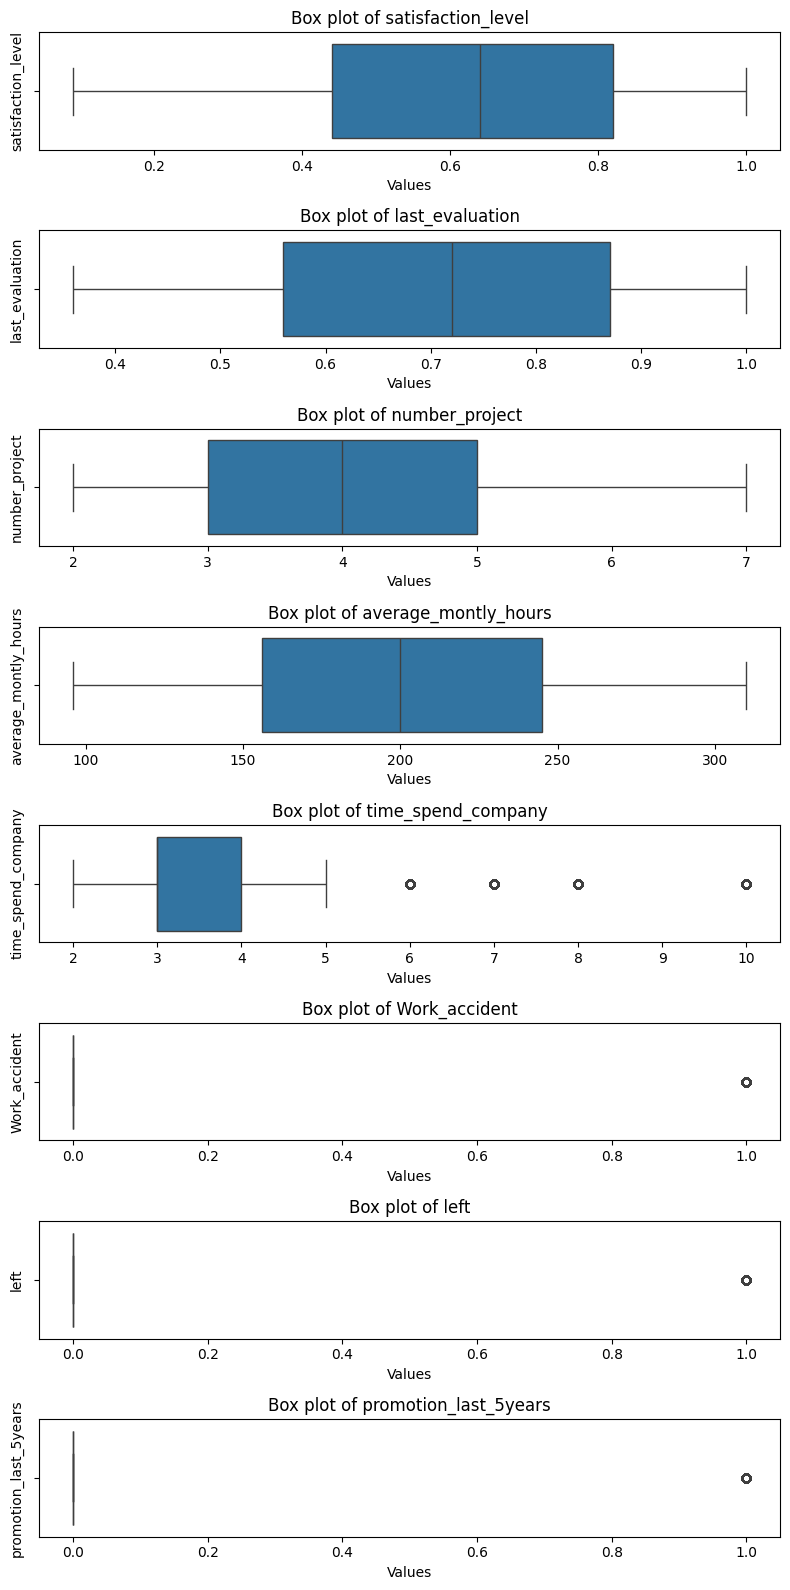

In [18]:
col_boxplots(hr)

A couple of remarks:

- "left", "promotion_last_5_years" and "work_accident" are boolean variables.
- "time_spend_company" is the only column having outliers
- Variables have different scales. Therefore, data must be scaled before being plugged into some type of models.

Moreover, let's check the continuous variables' distribution.

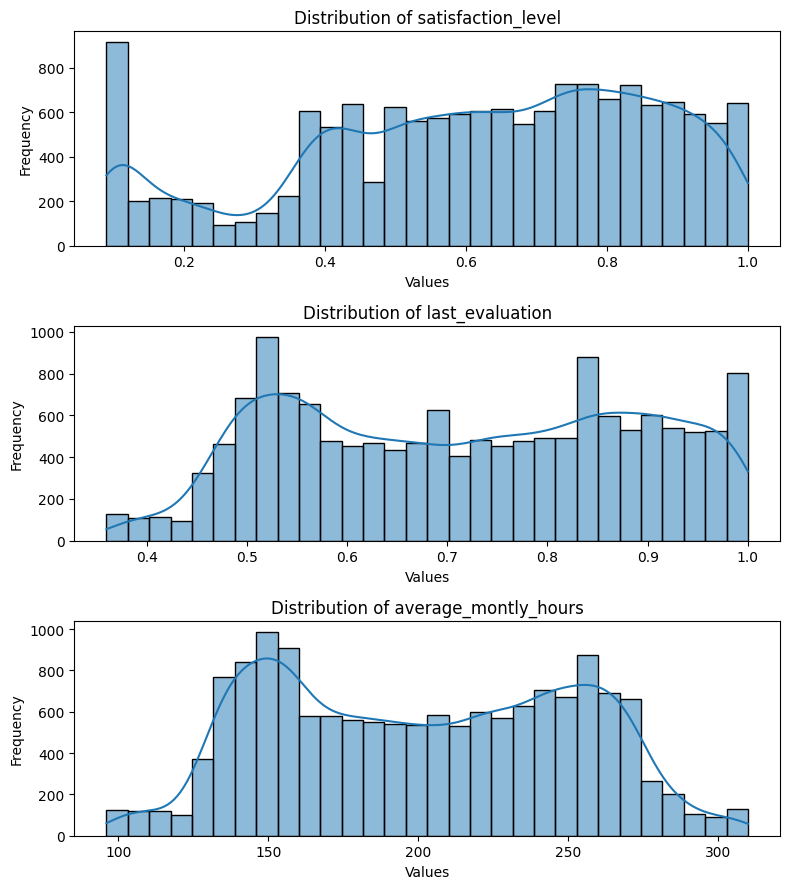

In [19]:
col_distributions(hr, columns = ["satisfaction_level", "last_evaluation", "average_montly_hours"] )

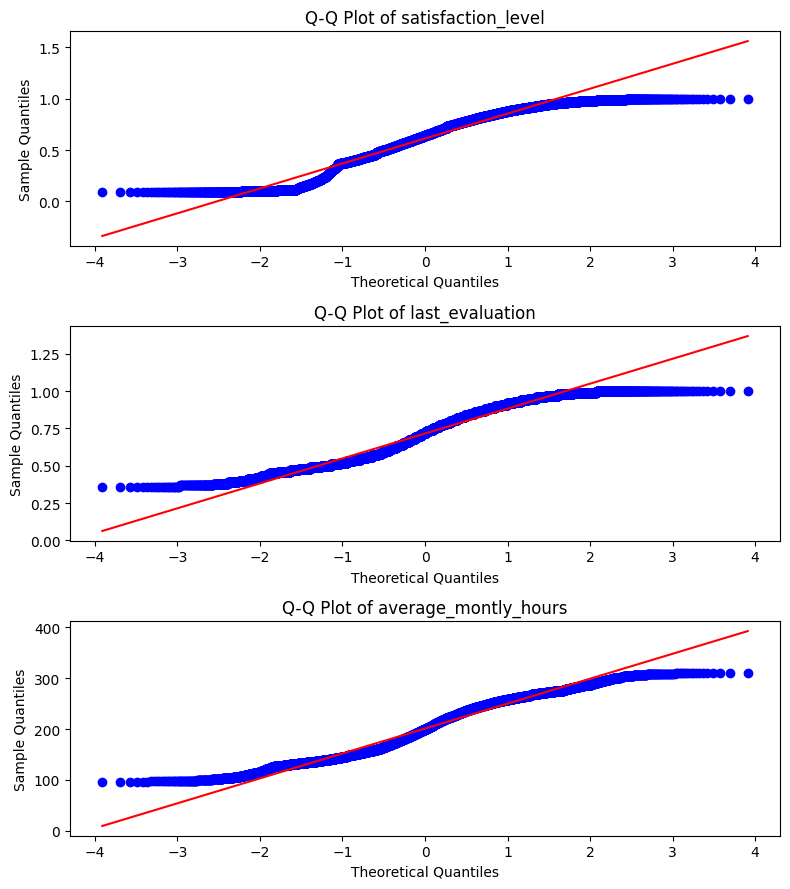

In [20]:
col_qqplots(hr, columns = ["satisfaction_level", "last_evaluation", "average_montly_hours"] )

None of the distribution looks normally-shaped. Q-Q plots confirm this intuition.
This could violate some models' assumption and must be taken into account when it's time to build the model.

Considering boolean variables, let's display their class balance.

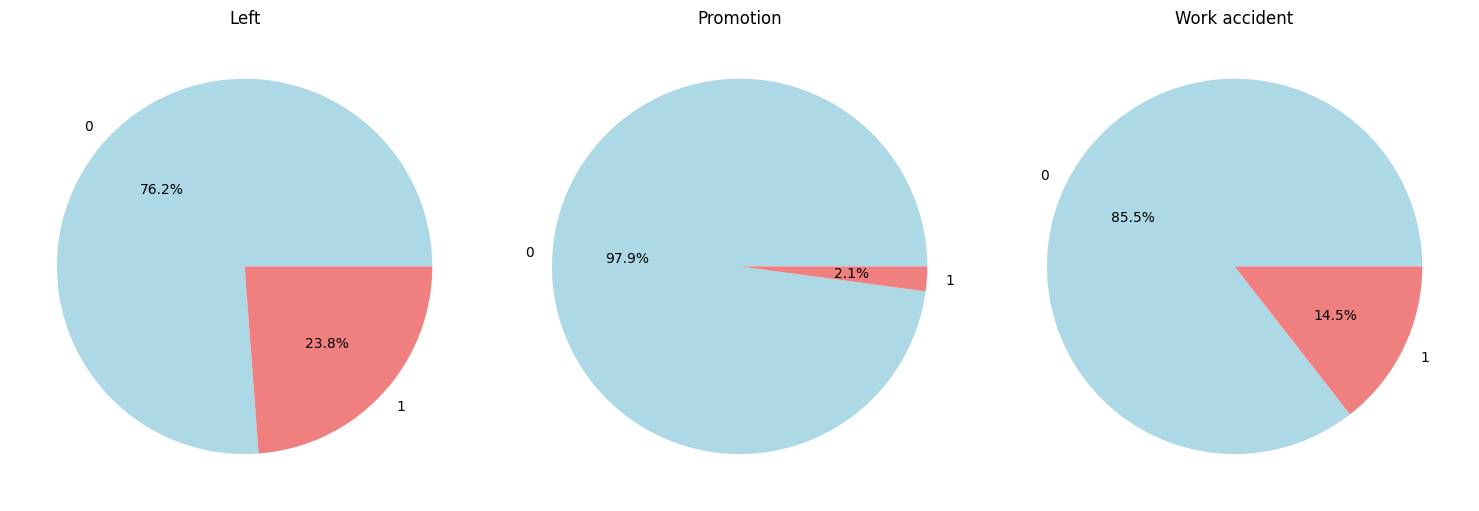

In [21]:
#split the chart area
fig, axes = plt.subplots(1, 3, figsize=(15, 5))  # 1 row, 3 columns
# Create pie charts
pie_chart(hr, 'left', axes[0], "Left")
pie_chart(hr, 'promotion_last_5years', axes[1], "Promotion")
pie_chart(hr, 'Work_accident', axes[2], "Work accident")
#
plt.tight_layout()  
# Save the figure
plt.savefig("img/Boolean_pieCharts.png", bbox_inches="tight", dpi=300)
#show the plot    
plt.show()

As the pie chart shows, 23.8% of the employee had left. Moreover, apparently in the Salifort company is hard to get promoted (or the employee are underperforming) and there is a quite concerning number of work accident.

Let's now consider how variables interact amongst one another. Let's display both the multicollinearity matrix and the VIF scores.

In [22]:
#correlation matrix
check_multicollinearity(hr, method="correlation", threshold=0.4)

(                       satisfaction_level  last_evaluation  number_project  \
 satisfaction_level               1.000000         0.105021       -0.142970   
 last_evaluation                  0.105021         1.000000        0.349333   
 number_project                  -0.142970         0.349333        1.000000   
 average_montly_hours            -0.020048         0.339742        0.417211   
 time_spend_company              -0.100866         0.131591        0.196786   
 Work_accident                    0.058697        -0.007104       -0.004741   
 left                            -0.388375         0.006567        0.023787   
 promotion_last_5years            0.025605        -0.008684       -0.006064   
 
                        average_montly_hours  time_spend_company  \
 satisfaction_level                -0.020048           -0.100866   
 last_evaluation                    0.339742            0.131591   
 number_project                     0.417211            0.196786   
 average_montly

In [23]:
#VIF
check_multicollinearity(hr, method="vif")

feature        VIF
0     satisfaction_level   6.954494
1        last_evaluation  20.283085
2         number_project  13.841277
3   average_montly_hours  19.414397
4     time_spend_company   6.784741
5          Work_accident   1.192139
6                   left   1.556762
7  promotion_last_5years   1.033146

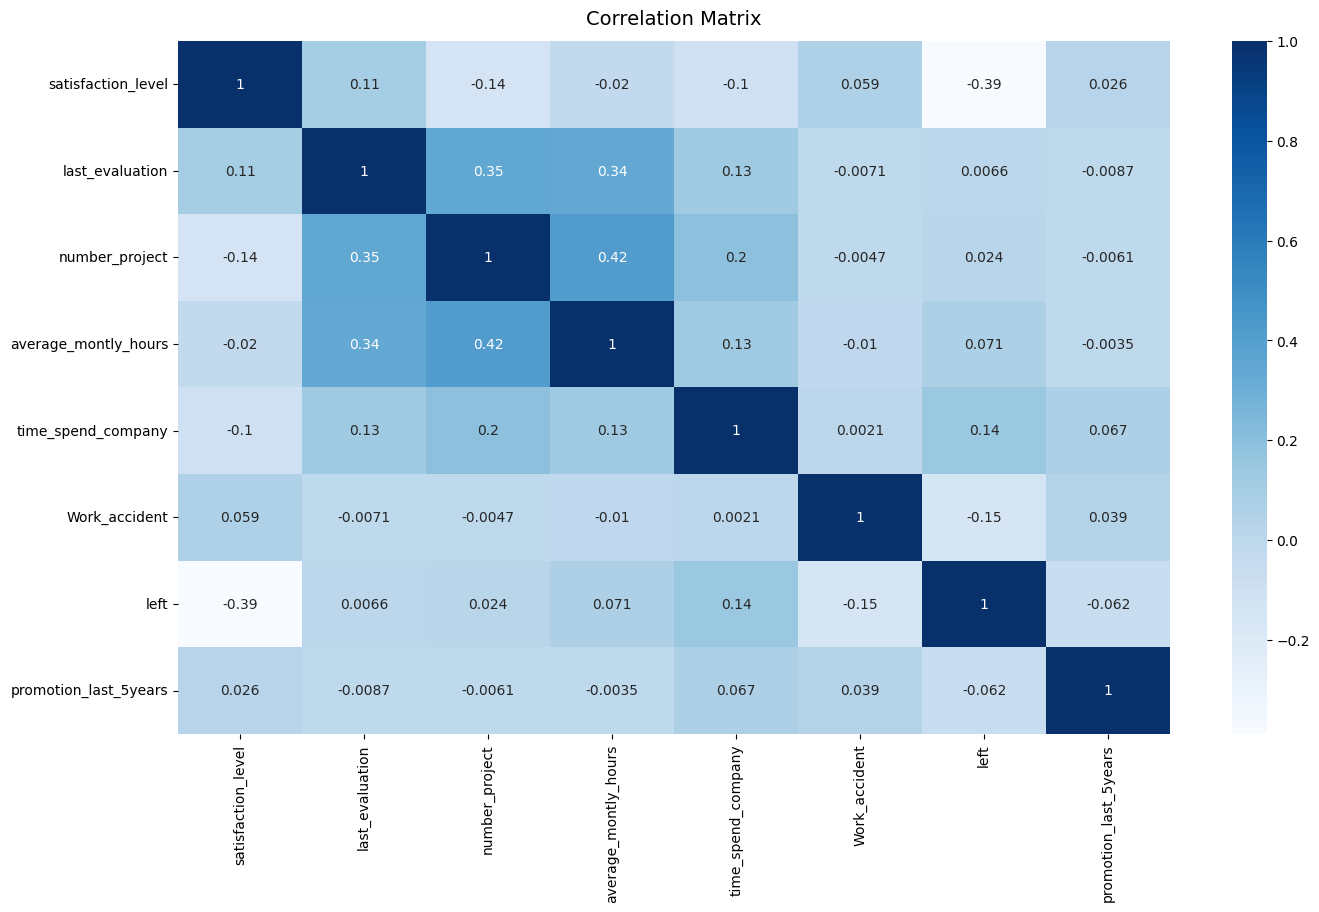

In [24]:
# Plot a correlation heatmap
plt.figure(figsize=(16, 9))
crldf = hr.drop(["salary", "Department"], axis = 1)
crl_plot = sns.heatmap(crldf.corr(), annot=True, cmap=sns.color_palette('Blues', as_cmap=True))
crl_plot.set_title('Correlation Matrix', fontdict={'fontsize':14}, pad=12);

According to the correlation matrix, the average monthly hours and the projects number have a notable correlation (> 40). That's foreseable, as one working more has more time to complete more projects. Not surpisingly, these two variables have also a high VIF. Last evaluation has a high VIF too.  
  
Remarkably, variables with an important VIF value are not pinpointed as "correlated" in the correlation matrix. What does this suggest? Basically, it means that combinations of variables (and not individual pairs) are leading to multicollinearity.  
Indeed, variables like last_evaluation, number_project and average_monthly_hour may not correlate strongly pairwise, but together could be linearly dependent. As an example, average_montly_hour could be strictly correlated with number_project, as the more the projects the more the hours spent working.  
  
Feature engineering could solve this later on.

To gain a clear view of the situation, we must delve more in the relationship between average monthly hours and the number of projects.

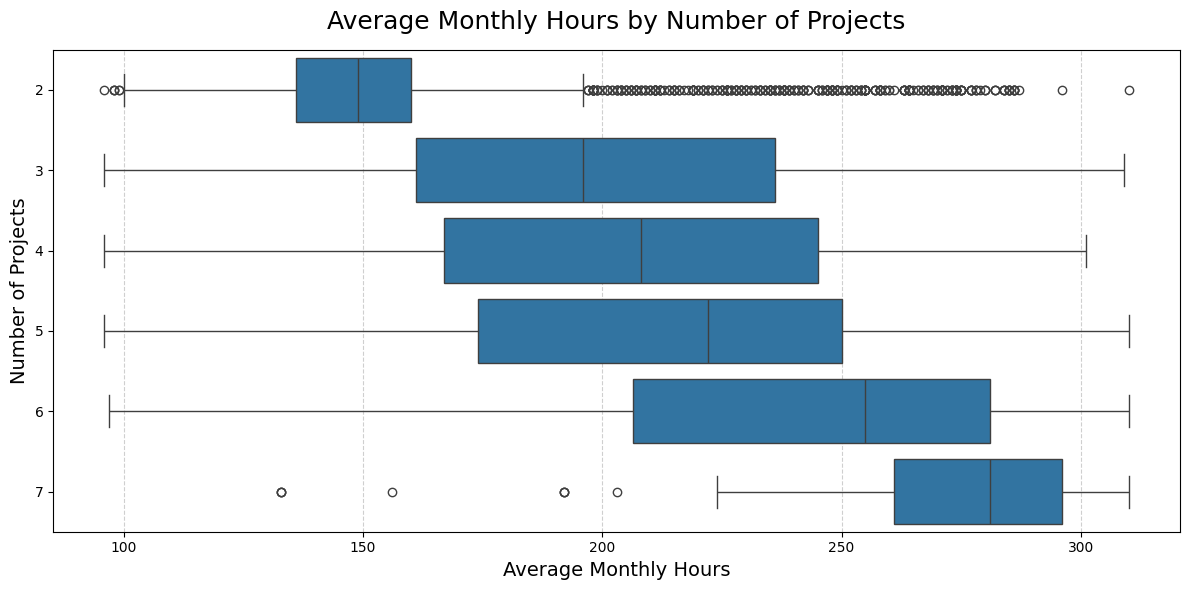

In [25]:
plt.figure(figsize=(12, 6))
# Create the boxplot
sns.boxplot(data=hr, x='average_montly_hours', y='number_project', orient='h')
# Title and labels
plt.title("Average Monthly Hours by Number of Projects", fontsize=18, pad=15)
plt.xlabel("Average Monthly Hours", fontsize=14)
plt.ylabel("Number of Projects", fontsize=14)
# Improve layout#
plt.grid(axis="x", linestyle="--", alpha=0.6)  # Add a light grid for readability
plt.tight_layout()
#save it
plt.savefig("img/hoursXproject.png", bbox_inches="tight", dpi=300)
# Show the plot
plt.show()

The boxplots make evident how the increase in one of the two variables leads to an increase in the other one too.  
As such, this issue must be adressed later on either in feature selection or building.

The last considerations go to categorical variables: salary and department.

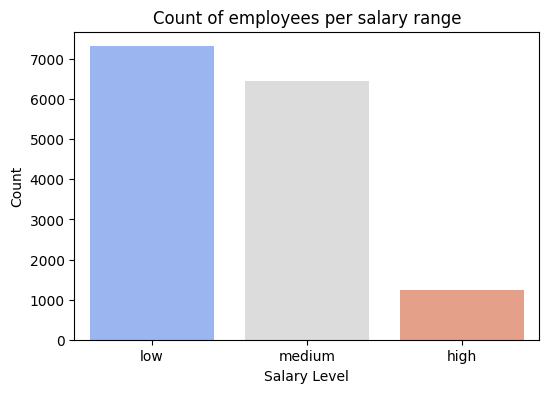

In [26]:
# Count occurrences of each category in 'salary'
salary_counts = hr['salary'].value_counts()
# Create the bar plot
plt.figure(figsize=(6, 4))
sns.barplot(x=salary_counts.index, y=salary_counts.values, hue=salary_counts.index, palette="coolwarm", legend=False)
# Add labels and title
plt.xlabel("Salary Level")
plt.ylabel("Count")
plt.title("Count of employees per salary range")
# Save the figure
plt.savefig("img/empXsalary.png", bbox_inches="tight", dpi=300)
# Show the plot
plt.show()

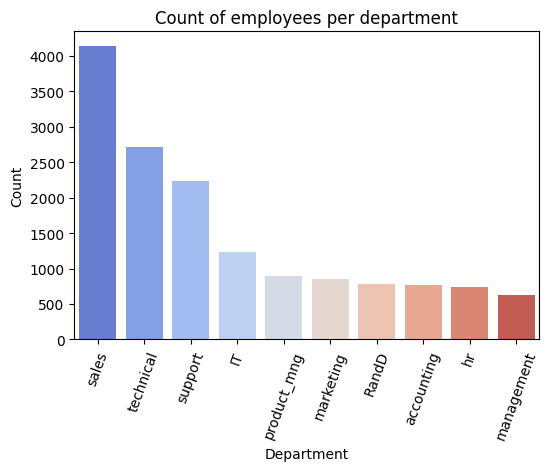

In [27]:
# Count occurrences of each category in 'departement'
salary_counts = hr['Department'].value_counts()
# Create the bar plot
plt.figure(figsize=(6, 4))
sns.barplot(x=salary_counts.index, y=salary_counts.values, hue=salary_counts.index, palette="coolwarm", legend=False)
# Add labels and title
plt.xlabel("Department")
plt.ylabel("Count")
plt.title("Count of employees per department")
# Rotate x-axis labels vertically
plt.xticks(rotation=70) 
# Save the figure
plt.savefig("img/empXdept.png", bbox_inches="tight", dpi=300)
# Show the plot
plt.show()

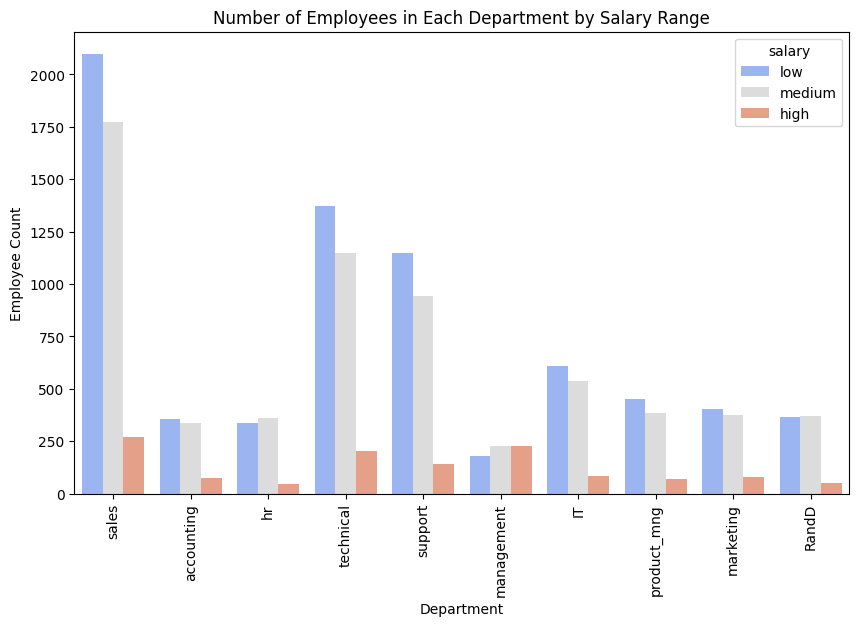

In [28]:
plt.figure(figsize=(10, 6))  # Set figure size
# Create the grouped bar plot
sns.countplot(data=hr, x="Department", hue="salary", palette="coolwarm")
# Add labels and title
plt.xlabel("Department")
plt.ylabel("Employee Count")
plt.title("Number of Employees in Each Department by Salary Range")
# Rotate x-axis labels for readability
plt.xticks(rotation=90)
# Save the figure
plt.savefig("img/deptXsalary.png", bbox_inches="tight", dpi=300)
# Show the plot
plt.show()

Most employees have a salary within the 'low' range and work in the sales department, followed by those in technical, support, and IT.  
  
Considering salary and department altogether, management is the sector in which an employee should aim to work in. Indeed, here the people having a high salary are more than the ones having a low wage.

### PCA - PRINCIPAL COMPONENTS ANALYSIS

Prior to digging into feature engineering, let's perform a PCA to get insights about which variables contribute the most to variance. These insights could guide the feature engineering process later on.  
Note. Since it is an exploratory PCA, we are going to exclude "object" variables.

PCA needs standardized variables. Therefore, let's standardize the df's continuous variables.  
Note. Boolean variables do not need standardization. Hence, these are excluded from the standardization and added later on.

In [29]:
# defining the continuous variables
continuous = ['satisfaction_level', 'last_evaluation', 'number_project',
            'average_montly_hours', 'time_spend_company']
# subset the hr df with just continuos variables
hr_subset1 = hr[continuous]
# standardizing 
scaler = StandardScaler()
hr_scaled = scaler.fit_transform(hr_subset1)
#conver to a df
hr_scaled = pd.DataFrame(hr_scaled, columns=continuous)
#show it
hr_scaled

satisfaction_level  last_evaluation  number_project  \
0               -0.936495        -1.087275       -1.462863   
1                0.752814         0.840707        0.971113   
2               -2.022479         0.957554        2.593763   
3                0.431041         0.899131        0.971113   
4               -0.976716        -1.145699       -1.462863   
...                   ...              ...             ...   
14994           -0.856051        -0.853580       -1.462863   
14995           -0.976716        -1.379394       -1.462863   
14996           -0.976716        -1.087275       -1.462863   
14997           -2.022479         1.424944        1.782438   
14998           -0.976716        -1.145699       -1.462863   

       average_montly_hours  time_spend_company  
0                 -0.882040           -0.341235  
1                  1.220423            1.713436  
2                  1.420657            0.343655  
3                  0.439508            1.028546  
4                 -0.841993           -0.341235  
...                     ...                 ...  
14994             -1.002181           -0.341235  
14995             -0.821970           -0.341235  
14996             -1.162368           -0.341235  
14997              1.580845            0.343655  
14998             -0.862016           -0.341235  

[14999 rows x 5 columns]

In [30]:
#define boolean variables
boolean = ['Work_accident', 'left', 'promotion_last_5years']
#subset the hr df with just the boolean variables
hr_subset2 = hr[boolean]
#show it
hr_subset2

Work_accident  left  promotion_last_5years
0                  0     1                      0
1                  0     1                      0
2                  0     1                      0
3                  0     1                      0
4                  0     1                      0
...              ...   ...                    ...
14994              0     1                      0
14995              0     1                      0
14996              0     1                      0
14997              0     1                      0
14998              0     1                      0

[14999 rows x 3 columns]

In [31]:
#merge the two dfs
hr_PCAdf = pd.concat([hr_scaled, hr_subset2], axis=1)
#show it
hr_PCAdf.head()


satisfaction_level  last_evaluation  number_project  average_montly_hours  \
0           -0.936495        -1.087275       -1.462863             -0.882040   
1            0.752814         0.840707        0.971113              1.220423   
2           -2.022479         0.957554        2.593763              1.420657   
3            0.431041         0.899131        0.971113              0.439508   
4           -0.976716        -1.145699       -1.462863             -0.841993   

   time_spend_company  Work_accident  left  promotion_last_5years  
0           -0.341235              0     1                      0  
1            1.713436              0     1                      0  
2            0.343655              0     1                      0  
3            1.028546              0     1                      0  
4           -0.341235              0     1                      0

Now the df is standardized, it is possible to apply PCA. PCA helps in seeing how much variance each principal components explains.

In [32]:
# Initialize PCA
pca = PCA()
# Fit PCA on standardized data
pca.fit(hr_PCAdf)
# Transform the data
hr_pca = pca.transform(hr_PCAdf)

While performing PCA, a fundamental part is to undertsand how many principal components must be kept. The explained variance ratio helps with the decision.

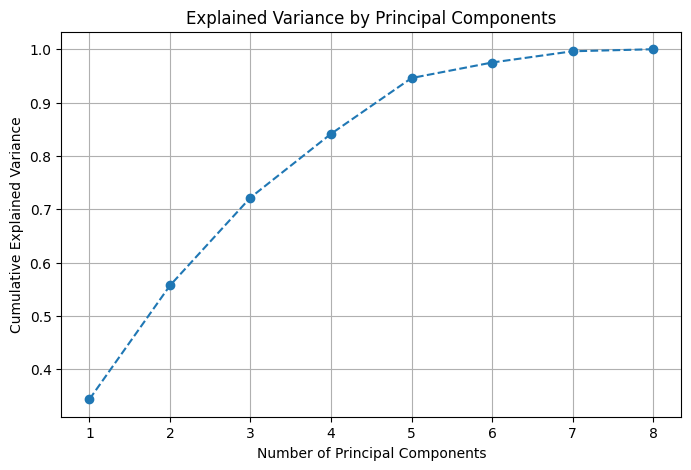

In [33]:
# Explained variance ratio
explained_variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)

# Plot explained variance
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(explained_variance) + 1), cumulative_variance, marker='o', linestyle='--')
plt.title('Explained Variance by Principal Components')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid(True)
plt.savefig("in_data/PCA_elbow.png", bbox_inches="tight", dpi=300)
plt.show()

The "elbow" charts shows that with 4 PC the 85% of variance is explained. If we opt for 5 PCs, the variance explained is the 95%.

In [34]:
# Shows variance explained by each PC
print(pca.explained_variance_ratio_)
# Sum should be close to 1
print(sum(pca.explained_variance_ratio_)) 

[0.34392863 0.21320555 0.16482897 0.11942359 0.10458529 0.02909415
 0.02107249 0.00386133]
1.0


Now, let's define an arbitrary threshold for the variance. This time, we will keep components expalining 90% of the variance.

In [35]:
# Keep components that explain 90% of variance
pca = PCA(n_components=0.9)
hr_pca_reduced = pca.fit_transform(hr_PCAdf)
#print the PCA shape
print(f'Shape after PCA: {hr_pca_reduced.shape}')


Shape after PCA: (14999, 5)


Let's display how much does each single variable contributes to each PC.

In [36]:
#define the entire variables
features = continuous + boolean
# build a df for PCA components
# Create a DataFrame for PCA component loadings (feature importance)
pca_components = pd.DataFrame(pca.components_, columns=features, index=[f'PC{i+1}' for i in range(pca.n_components_)])
print(pca_components)

     satisfaction_level  last_evaluation  number_project  \
PC1           -0.094304         0.505066        0.578456   
PC2           -0.830060        -0.362351        0.093053   
PC3            0.368835         0.038284       -0.202803   
PC4           -0.265945         0.727152       -0.033556   
PC5            0.235969        -0.287083        0.780997   

     average_montly_hours  time_spend_company  Work_accident      left  \
PC1              0.548466            0.315107      -0.003936  0.035780   
PC2             -0.123986            0.358550      -0.019236  0.163532   
PC3             -0.255484            0.868992       0.013287 -0.025080   
PC4             -0.620921           -0.107994      -0.012040  0.045018   
PC5             -0.480737           -0.050771       0.020905 -0.133490   

     promotion_last_5years  
PC1               0.000637  
PC2               0.000178  
PC3               0.011900  
PC4              -0.004538  
PC5               0.001582  


Zooming in, show the 3 variables contributing the most to each PC.

In [37]:
#show the most contributing variables for each PC
print("\nTop 3 contributing features for each Principal Component:\n")
for i, comp in enumerate(pca_components.values):
    top_features = np.argsort(np.abs(comp))[-3:][::-1]  # Top 3 features
    feature_names = pca_components.columns[top_features]
    feature_importance = np.abs(comp[top_features])  # Get actual importance values
    print(f'PC{i+1}:')
    for feat, imp in zip(feature_names, feature_importance):
        print(f'  - {feat} ({imp:.4f})')  # Display feature importance rounded to 4 decimals
    print("")


Top 3 contributing features for each Principal Component:

PC1:
  - number_project (0.5785)
  - average_montly_hours (0.5485)
  - last_evaluation (0.5051)

PC2:
  - satisfaction_level (0.8301)
  - last_evaluation (0.3624)
  - time_spend_company (0.3586)

PC3:
  - time_spend_company (0.8690)
  - satisfaction_level (0.3688)
  - average_montly_hours (0.2555)

PC4:
  - last_evaluation (0.7272)
  - average_montly_hours (0.6209)
  - satisfaction_level (0.2659)

PC5:
  - number_project (0.7810)
  - average_montly_hours (0.4807)
  - last_evaluation (0.2871)



The PCA analysis provides us with some interesting takeaways:  
  
- The primary drivers of variance are PC1 and PC2. Them are highly influenced by number of projects, last evaluation, average monthly hours (PC1) and satisfaction level, time spent at the compnay and whether the employee left (PC2).  
- Work accidents and promotion seem to play a minor role in differentiating employess.  
  
In a nuthsell, PCA results indicate that workload, satisfaction, tenure, and evaluations are the most significant factors influencing employee dynamics.

Once we have a general overiew of data, it is time to prepare it for the analysis and modeling. Thus, data needs to be cleaned.

### DATA CLEANING

Overall, the dataset looks pretty neat already. Performing few additional will ensure it is totally clean.

First, let's check the dataset size.

In [38]:
#check the number of rows and column
hr.shape

(14999, 10)

It has 14999 rows and 10 columns.
Now let's display the first rows.

In [39]:
#display first rows
hr.head()

satisfaction_level  last_evaluation  number_project  average_montly_hours  \
0                0.38             0.53               2                   157   
1                0.80             0.86               5                   262   
2                0.11             0.88               7                   272   
3                0.72             0.87               5                   223   
4                0.37             0.52               2                   159   

   time_spend_company  Work_accident  left  promotion_last_5years Department  \
0                   3              0     1                      0      sales   
1                   6              0     1                      0      sales   
2                   4              0     1                      0      sales   
3                   5              0     1                      0      sales   
4                   3              0     1                      0      sales   

   salary  
0     low  
1  medium  
2  medium  
3     low  
4     low

Note that the df is composed by different datatypes: discrete, continuous, boolean and object. 
Let's check if their datatypes are properly assigned.

In [40]:
#show data types
hr.dtypes

satisfaction_level       float64
last_evaluation          float64
number_project             int64
average_montly_hours       int64
time_spend_company         int64
Work_accident              int64
left                       int64
promotion_last_5years      int64
Department                object
salary                    object
dtype: object

As shown, boolean variables are not defined as boolean. Let's fix this.

In [41]:
#convert boolean to acutal boolean
hr[boolean] = hr[boolean].astype(bool)
#check it
hr.dtypes

satisfaction_level       float64
last_evaluation          float64
number_project             int64
average_montly_hours       int64
time_spend_company         int64
Work_accident               bool
left                        bool
promotion_last_5years       bool
Department                object
salary                    object
dtype: object

Note also that work accident and department are the only columns starting with a capital letter. Let's change that.

In [42]:
hr.rename(columns={"Department": "department", "Work_accident": "work_accident"}, inplace=True)

Once datatype are correctly defined, it is time to check for missing values.

In [43]:
#check for missing values
hr.isna().sum()

satisfaction_level       0
last_evaluation          0
number_project           0
average_montly_hours     0
time_spend_company       0
work_accident            0
left                     0
promotion_last_5years    0
department               0
salary                   0
dtype: int64

Luckily, there are no missing values in none of the column.  
  
Therefore, the variables are well named, their datatypes is right and none has missing value. Plus, all variables are relevant.

Turning to duplicates, finding them could be a little bit tricky in this df. Indeed, there is not an "identification" column that can be scanned to check for duplicates. Plus, it is plausible for df's variables to have repeating values.

So, how is it possible to spot duplicates?  
The most feasible option could be to define as a duplicate those rows having the same values in all columns. As a matter of fact, it is not likely that two employess will have exact the same features in all the columns. 

In [44]:
find_duplicates(hr)

satisfaction_level  last_evaluation  number_project  \
0                   0.09             0.62               6   
1                   0.09             0.62               6   
2                   0.09             0.62               6   
3                   0.09             0.77               5   
4                   0.09             0.77               5   
...                  ...              ...             ...   
5341                1.00             0.88               6   
5342                1.00             0.93               5   
5343                1.00             0.93               5   
5344                1.00             0.93               5   
5345                1.00             0.93               5   

      average_montly_hours  time_spend_company  work_accident   left  \
0                      294                   4          False   True   
1                      294                   4          False   True   
2                      294                   4          False   True   
3                      275                   4          False   True   
4                      275                   4          False   True   
...                    ...                 ...            ...    ...   
5341                   201                   4          False  False   
5342                   167                   3          False  False   
5343                   167                   3          False  False   
5344                   231                   2          False  False   
5345                   231                   2          False  False   

      promotion_last_5years   department  salary  
0                     False   accounting     low  
1                     False   accounting     low  
2                     False   accounting     low  
3                     False  product_mng  medium  
4                     False  product_mng  medium  
...                     ...          ...     ...  
5341                  False    technical     low  
5342                  False        sales  medium  
5343                  False        sales  medium  
5344                  False    marketing  medium  
5345                  False    marketing  medium  

[5346 rows x 10 columns]

In [45]:
# Count first appearances (first occurrence of each duplicate group)
hr.duplicated(keep='first').value_counts().get(False, 0)

11991

As shown, in the df there are 11 991 unique rows.  
This means that if we opt for getting rid of duplicates, we will end up with a df with 11 991 entries. This is a reduction of 3008 (14999 -11991) rows, around the 20% of the dataset.  
  
This is a quite consistent reduction. Therefore, we should carefully consider it. Asking to managers if it could be that some employees have the exact same preferences could be a starting point. Yet, to dig more in depth, it is possible to turn to those who made the questionary, looking if they spotted some of these occurencies already (ex. Was it possible for a single employee to submit the questionary more than once?) 

Since at the moment we do not have the possibility to get an answer to none of these question, we are going to create a subset of the df without the duplicates. We will employ this dataset for modeling, as it is really unlikely for two (or more) employees to have not only the same features but also the same digits in the continuos variables.

In [46]:
#build a subset of the df without (alleged) duplicates 
hr_sub = hr.drop_duplicates(keep='first')

In [47]:
#check it
hr_sub.shape

(11991, 10)

To conclude, let's examine outliers.

In [48]:
#iqr method
count_outliers(hr_sub)

{'satisfaction_level': 0,
 'last_evaluation': 0,
 'number_project': 0,
 'average_montly_hours': 0,
 'time_spend_company': 824}

In [49]:
#Z-score method
count_outliers(hr_sub, method = "zscore", threshold=3)

{'satisfaction_level': 0,
 'last_evaluation': 0,
 'number_project': 0,
 'average_montly_hours': 0,
 'time_spend_company': 188}

Apparentrly, the only column having outliers is "time_spend_company". Let's print its maximum value.

In [50]:
#print time_spend_company max value
hr_sub["time_spend_company"].max()

10

The max value is 10, meaning there are people that have spent 10 years at the company.  
We are not going to remove this outliers. That's for three reasons a) they provide useful information b) they account for a small amount of the entire dataset (not skewing that much the results) c) many ML models are robust to outliers. 

Once the cleaning phase is concluded, we have a cleaned dataset ready to be analyzed.

## TARGET VARIABLE

### Target variable defintion

The aim for the analysis is clear: build a model able to understand whether or not an employee will leave the company.  

As a consequence, it is straight-forward to select the variable "left" (showing whether or not that employee quitted) as the target variable (i.e the variable the model is trying to predict).

### Target Variable Class Balance

To avoid the model performing well with one class of the target variable just beacuse that class comes more often than the other, we must check its class balance.  

Printing how many "yes" and "no" appear within the column left gave us an idea how severe is the imbalance (if any).

In [51]:
#check "predicted" class balance
print("Number of employees that have left the company:\n", hr_sub["left"].value_counts())
print()
print("Percentage of employees that have left the company:\n", hr_sub["left"].value_counts(normalize = True))

Number of employees that have left the company:
 left
False    10000
True      1991
Name: count, dtype: int64

Percentage of employees that have left the company:
 left
False    0.833959
True     0.166041
Name: proportion, dtype: float64


The target variable is far from the perfect balance (i.e 50-50). However, even variables having a class balance in the order of 80-20 will perform fairly when plugged into some ML model. Issues usually arises when it has class that takes > 90% of the observations.
  
This does not seem the case with the "left" feature. As a matter of facts, it is in the order of the 80-20 class split. Precisely 83.4-16.6. Thus, at this stage we will not re-balance (through downsampling or upsampling) the target variable's classes.  
However, we could always revert to rebalance later on if the models lead to poor results.

### EDA including the target variable

EDA can be repeated by taking into account the target variable. This means considering how the target  behave with respect to the explanatory variables.

Firstly, let's check those department that are experiencing more people quitting and that have the highest spread stay-leave.

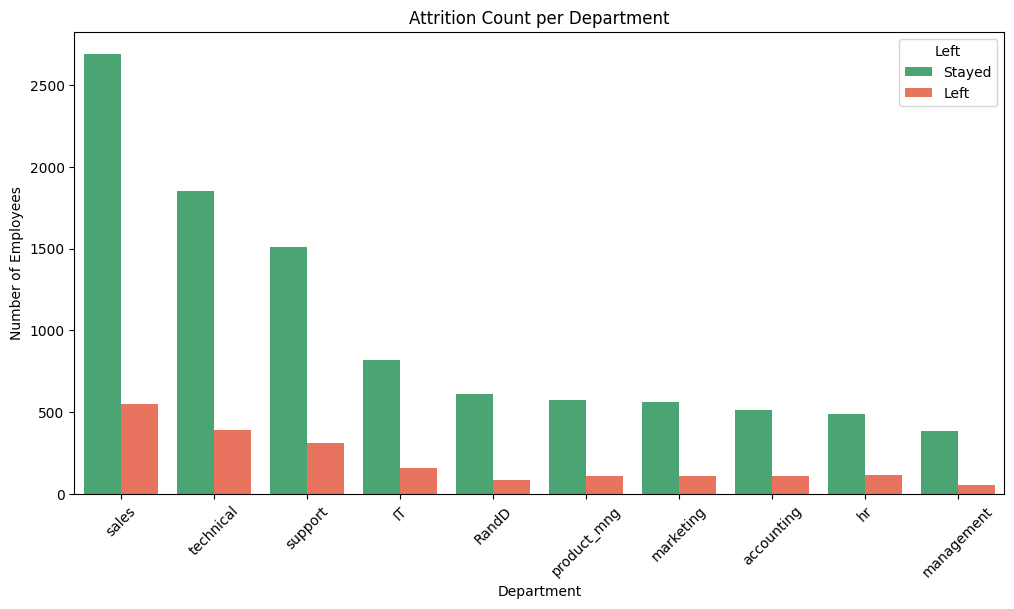

In [52]:
#order based by total employee (left + stay)
department_order = hr_sub["department"].value_counts().index  # Sorting based on total count

# show the attrition x department figure
plt.figure(figsize=(12, 6))
sns.countplot(data=hr_sub, x="department", hue="left", palette=["mediumseagreen", "tomato"], order=department_order)
#add labels to the plot
plt.title("Attrition Count per Department")
plt.xlabel("Department")
plt.ylabel("Number of Employees")
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.legend(title="Left", labels=["Stayed", "Left"])  # Adjust legend labels
plt.savefig("in_data/department_attrition.png", bbox_inches="tight", dpi=300)
plt.show()

Sales is both the department having the highest number of employee and the biggest retention rate. 
Interestingly, technicnal and support dept have an amount of employees leaving close to the sales. However, they have less employee.  
Overall, the barplots confirm reasonable intuition: departements with more employee will see more of them leaving. Interestingly, there are not clear trends in any of the macro-category: none of tech, customer or administration related dept shows particularly higher (or lower) amount of employee leaving.

Let's analyze if salary range plays a role in employee attrition.

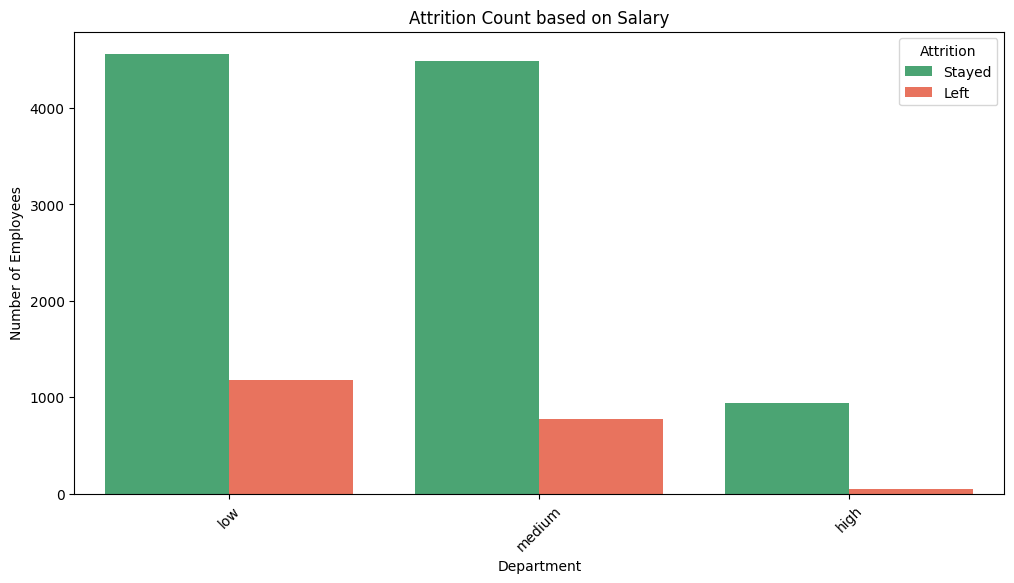

In [53]:
# show the attrition x salary figure
plt.figure(figsize=(12, 6))
sns.countplot(data=hr_sub, x="salary", hue="left", palette=["mediumseagreen", "tomato"])
# define the various labels
plt.title("Attrition Count based on Salary")
plt.xlabel("Department")
plt.ylabel("Number of Employees")
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.legend(title="Attrition", labels=["Stayed", "Left"])  # Adjust legend labels
plt.savefig("img/salary_attrition.png", bbox_inches="tight", dpi=300)
plt.show()

As reasoanable, employees with a high wage are less likely to leave the company. That's could be due to the hard work they did to get that wage or to the lack of such remunerative roles in other firms.  
On the other hand, low-wage employees have the highest attrition.

Focusing on continuos variables, we will consider all variables splitting between left and stay. In details, we will show boxplots for:

- left and satisfaction level
- left and last_evaluation
- left and average monthly hours

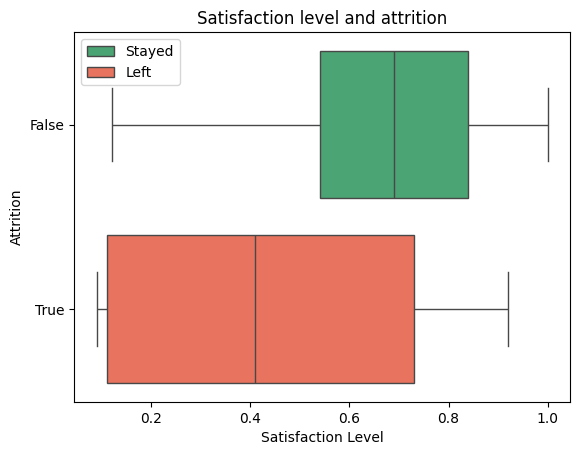

In [54]:
# Create boxplot 
sns.boxplot(data=hr_sub, x='satisfaction_level', y='left', hue='left', orient='h', palette=["mediumseagreen", "tomato"])
plt.title("Satisfaction level and attrition")
plt.xlabel("Satisfaction Level")
plt.ylabel("Attrition") 
plt.legend(labels=["Stayed", "Left"])  # Adjust legend labels
plt.savefig("img/leftXSatisfaction.png", bbox_inches="tight", dpi=300)
# Display the plot
plt.show()


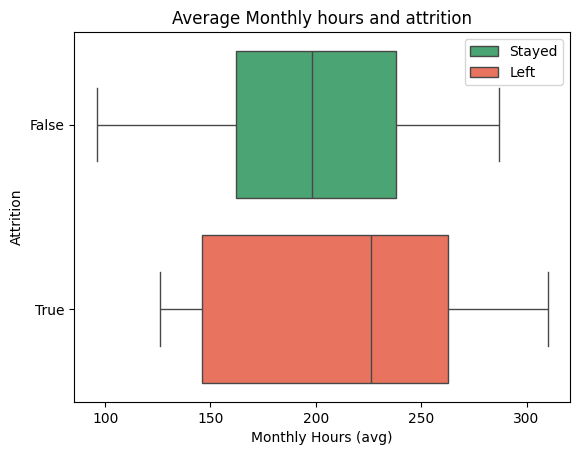

In [55]:
# Create boxplot 
sns.boxplot(data=hr_sub, x='average_montly_hours', y='left', hue='left', orient='h', palette=["mediumseagreen", "tomato"])
plt.title("Average Monthly hours and attrition")
plt.xlabel("Monthly Hours (avg)")
plt.ylabel("Attrition") 
plt.legend(labels=["Stayed", "Left"])  # Adjust legend labels
plt.savefig("img/leftXMonthlyHours.png", bbox_inches="tight", dpi=300)
# Display the plot
plt.show()

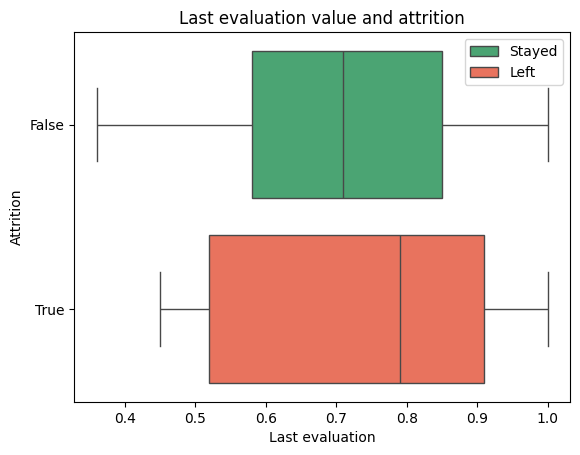

In [56]:
# Create boxplot 
sns.boxplot(data=hr_sub, x='last_evaluation', y='left', hue='left', orient='h', palette=["mediumseagreen", "tomato"])
plt.title("Last evaluation value and attrition")
plt.xlabel("Last evaluation")
plt.ylabel("Attrition") 
plt.legend(labels=["Stayed", "Left"])  # Adjust legend labels
plt.savefig("img/leftXSEvaluation.png", bbox_inches="tight", dpi=300)
# Display the plot
plt.show()

As understandable, employee avoid quitting if they are more satisfied with their job. Interestingly, people leaving satisfaction level has a wide disperion. This may suggests there are other factors (apart from satisfaction level) influencing negatively the attrition rate.  
  
Turning to average monthly working hours, these do not seem to influence that much a person's choice to resign. As with satisfction, however, who have left have a high dispersion.  
  
Pretty much the same holds for last evaluation. Curiously, people having left have had a higher evaluation score than those who have not.

Let's turn to discrete and boolean variable. In details, those are:

- number of projects
- years spent at the company
- work accidents
- promotions

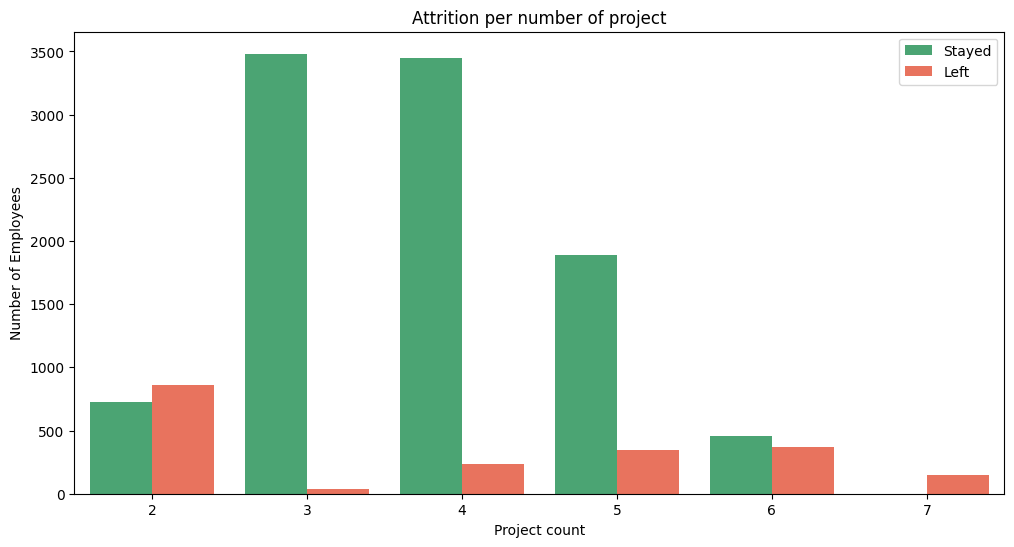

In [57]:
# show the attrition x number of project figure
plt.figure(figsize=(12, 6))
sns.countplot(data=hr_sub, x="number_project", hue="left", palette=["mediumseagreen", "tomato"])
# define the various labels
plt.title("Attrition per number of project")
plt.xlabel("Project count")
plt.ylabel("Number of Employees")
plt.legend(labels=["Stayed", "Left"])  # Adjust legend labels
plt.savefig("img/project_attrition.png", bbox_inches="tight", dpi=300)
plt.show()

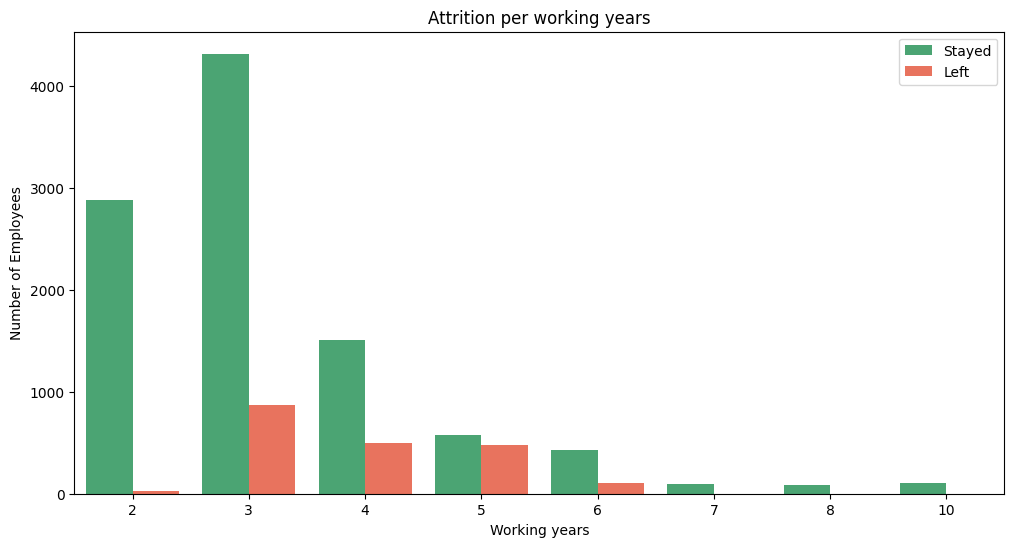

In [58]:
# show the attrition x salary figure
plt.figure(figsize=(12, 6))
sns.countplot(data=hr_sub, x="time_spend_company", hue="left", palette=["mediumseagreen", "tomato"])
# define the various labels
plt.title("Attrition per working years")
plt.xlabel("Working years")
plt.ylabel("Number of Employees")
plt.legend(labels=["Stayed", "Left"])  # Adjust legend labels
plt.savefig("img/workingYears_attrition.png", bbox_inches="tight", dpi=300)
plt.show()

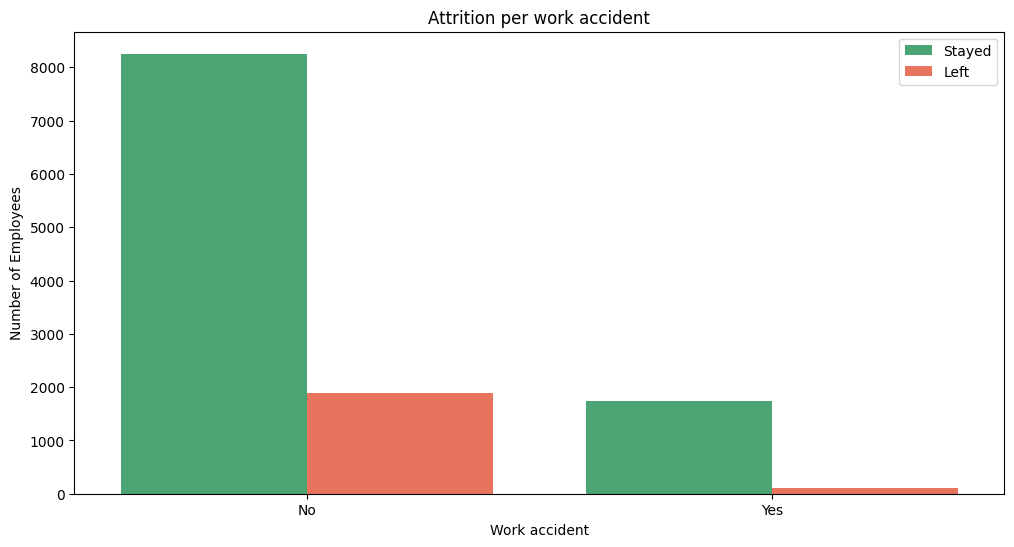

In [59]:
# show the attrition x salary figure
plt.figure(figsize=(12, 6))
sns.countplot(data=hr_sub, x="work_accident", hue="left", palette=["mediumseagreen", "tomato"])
# define the various labels
plt.title("Attrition per work accident")
plt.xlabel("Work accident")
plt.ylabel("Number of Employees")
plt.legend(labels=["Stayed", "Left"])  # Adjust legend labels
# Rename x ticks (False → No, True → Yes)
plt.xticks(ticks=[0, 1], labels=["No", "Yes"])
plt.savefig("img/accident_attrition.png", bbox_inches="tight", dpi=300)
plt.show()

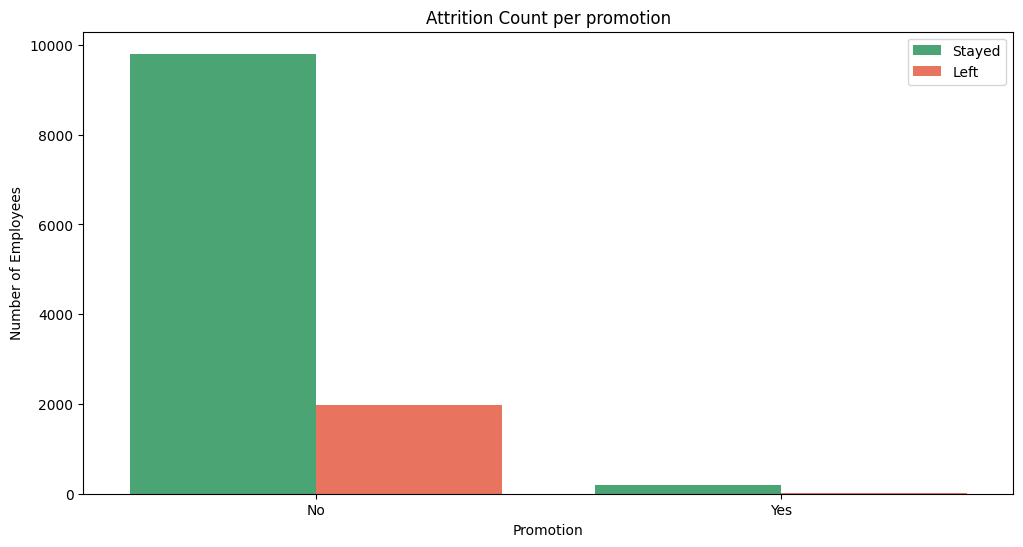

In [60]:
# show the attrition x salary figure
plt.figure(figsize=(12, 6))
sns.countplot(data=hr_sub, x="promotion_last_5years", hue="left", palette=["mediumseagreen", "tomato"])
# define the various labels
plt.title("Attrition Count per promotion")
plt.xlabel("Promotion")
plt.ylabel("Number of Employees")
plt.legend(labels=["Stayed", "Left"])  # Adjust legend labels
# Rename x ticks (False → No, True → Yes)
plt.xticks(ticks=[0, 1], labels=["No", "Yes"])
plt.savefig("img/promotion_attrition.png", bbox_inches="tight", dpi=300)
plt.show()

Considering stayed and resigned employees separately, the number of projects an employee has worked on does not seem to influence his/her decision that much. Yet, there are two values worth to be inspected:  
  
- 2 projects: this is the only instance having left > stayed, the following levels have a way bigger stayed than left count. This may point to 2 projects to be some sort of a twofold threshold: a) if an employee performed bad in the first, it will have a second chance, but not a third and b) an employee that did not "like" the first project may give another proejct a try, but not more than 2.
- 7 projects: all employees here have resigned. This may due to high and stressfull workload it could come with tackling that much projects.  
  
Working years appear to play a role in pushing attrition too. As a matter of facts, the years in the "middle" experience the highest attrition. This may suggest that at this stage a worker is not that tied to the company to regret leaving it (in terms of wage, satisfaction, work environment etc..) or maybe he/she could not have lived up to the expectation and been fired by its manager. This is confirmed by the nill attrition after the 6 working years.  
  
Turning to accidents, they do not seem to impact the decision to leave the company. It was logical to expect that having had a working accident could pushed a worker to leave, yet this is not the case.

Almost the same applies to Promotions. Even though almost no one left if promoted in the last 5 years, the amount of people promoted is that little that it is not seem that significant.  

In conclusion, let's consider some variables pairwise with respect to attrition. We will focus on:

- working hours and number of project with respect to attrition
- working hours and last evaluation with respect to attriton
- working hours and satisfaction level with respect to attrition

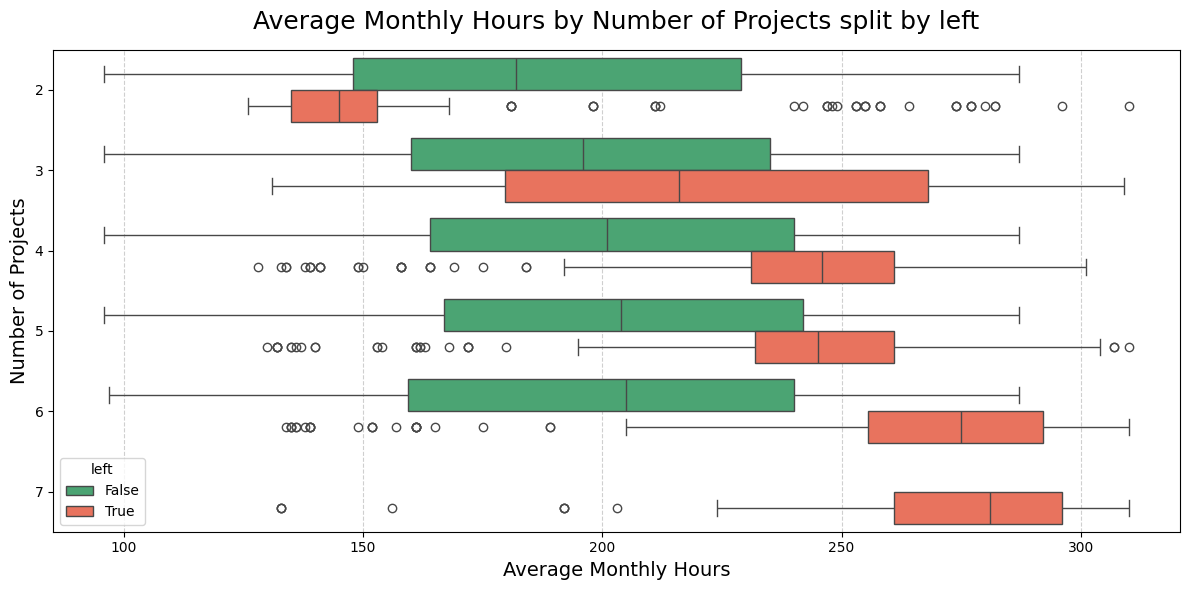

In [61]:
plt.figure(figsize=(12, 6))
# Create the boxplot
sns.boxplot(data=hr, x='average_montly_hours', y='number_project', orient='h', hue = "left", palette=["mediumseagreen", "tomato"])
# Title and labels
plt.title("Average Monthly Hours by Number of Projects split by left", fontsize=18, pad=15)
plt.xlabel("Average Monthly Hours", fontsize=14)
plt.ylabel("Number of Projects", fontsize=14)
# Improve layout#
plt.grid(axis="x", linestyle="--", alpha=0.6)  # Add a light grid for readability
plt.tight_layout()
#save it
plt.savefig("img/hoursXprojectXattrition.png", bbox_inches="tight", dpi=300)
# Show the plot
plt.show()

For any number of project, except for 2, the people who left have had a bigger monthly hours. This means that,being equal the number of project, people with more working hours tend to quit more. This make sense, since overworked employee may burnout quickly and simply resign. Or, people too slow in completing a project (meaning taking too much working hours) may be fired due to low productivity.
  
Speaking of project number = 2, people tend to quit even though they have less working hours. This may show an unwilligness to commit to the firm in the long-term.  
  
Final note on project number = 7. No one stayed here, everyone left.

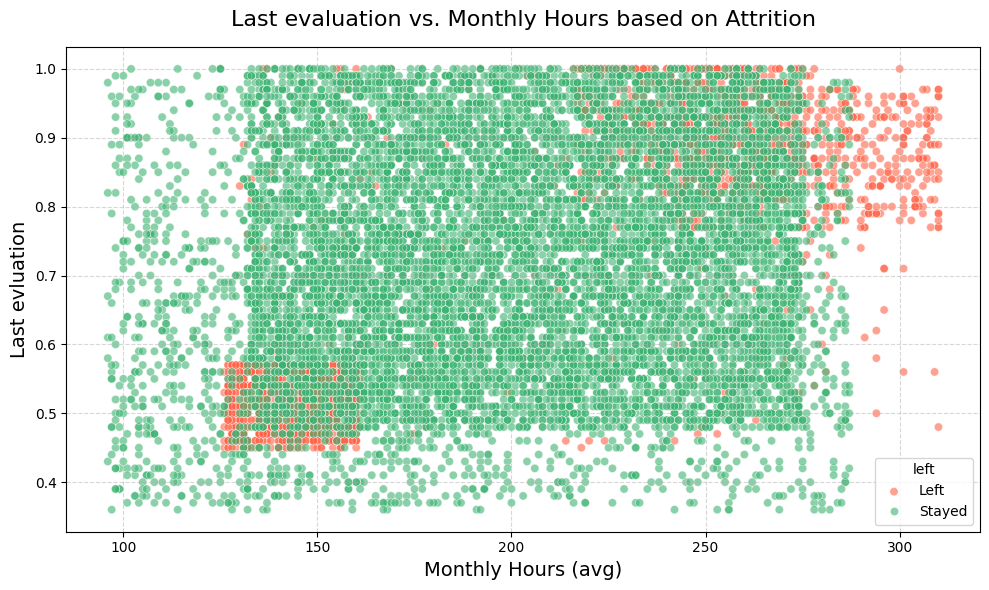

In [62]:
# scatterplot working hours vs last evaluation
plt.figure(figsize=(10, 6))
# Create scatter plot
sns.scatterplot(data=hr_sub, x='average_montly_hours', y='last_evaluation', hue='left', 
                palette=["mediumseagreen", "tomato"], alpha=0.6)
# Add labels and title
plt.xlabel("Monthly Hours (avg)", fontsize=14)
plt.ylabel("Last evluation", fontsize=14)
plt.title("Last evaluation vs. Monthly Hours based on Attrition", fontsize=16, pad=15)
# Improve layout
plt.legend(title="left", labels=["Left", "Stayed"])
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
#savefig
plt.savefig("img/hoursXevaluationXattrition.png", bbox_inches="tight", dpi=300)
# Show the plot
plt.show()


If monthly hours are considered along last evaluation, employees leaving tend to cluster withint two areas: a) low last evaluation and low working hours; or b) high evaluation and high working hours. Recalling that evaluation is some sort of a "grande" and employee had received, the two clusters show two tendencies:  
  
- People working less (in term of hours) tend to have low evaluation scores (that's maybe they do not want to work more), hence may be fired by the management team.
- People working more have higher evluation scores (for example due to their major availability), but they may feel burnout and quit.  
  
Of course, it is not possible to be sure about the above. Yet, it is a reasonable way to intepret the data. Splitting the column "left" into fired and quitter may be useful in be even more precise in the prediction. Unfortuanetly, that's not something we can do at the moment. 

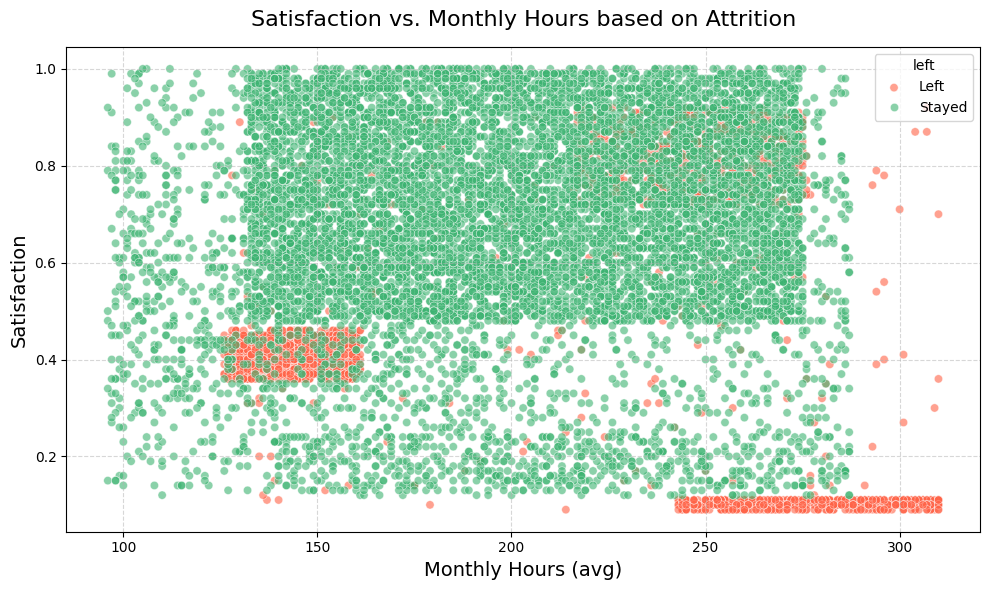

Zooming in on employees who left:


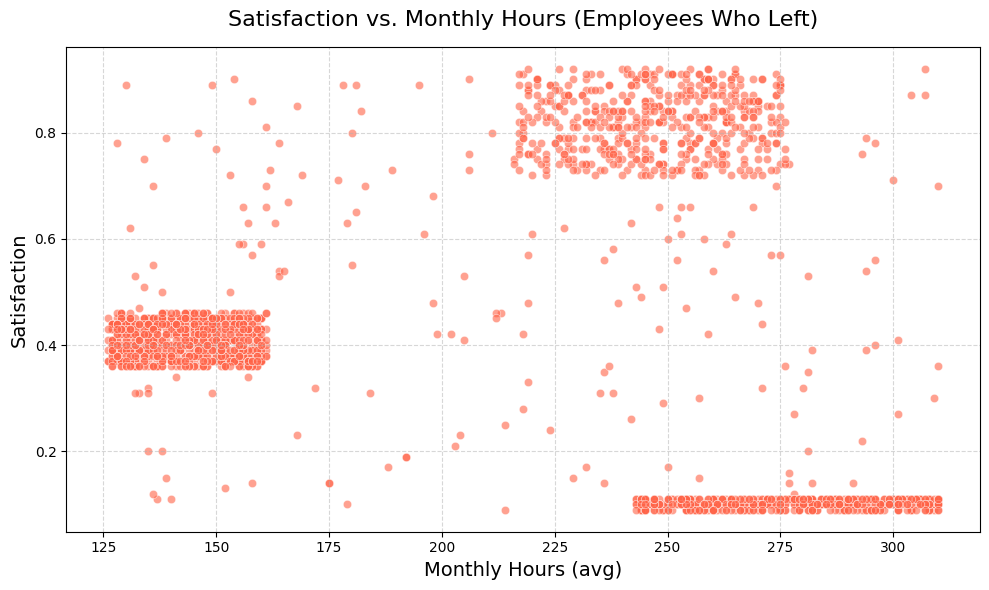

In [63]:
# scatterplot working hours vs last evaluation
plt.figure(figsize=(10, 6))
# Create scatter plot
sns.scatterplot(data=hr_sub, x='average_montly_hours', y='satisfaction_level', hue='left', 
                palette=["mediumseagreen", "tomato"], alpha=0.6)
# Add labels and title
plt.xlabel("Monthly Hours (avg)", fontsize=14)
plt.ylabel("Satisfaction", fontsize=14)
plt.title("Satisfaction vs. Monthly Hours based on Attrition", fontsize=16, pad=15)
# Improve layout
plt.legend(title="left", labels=["Left", "Stayed"])
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
#savefig
plt.savefig("img/hoursXsatisfactionXattrition.png", bbox_inches="tight", dpi=300)
# Show the plot
plt.show()

print("Zooming in on employees who left:")

#considering just those who left
plt.figure(figsize=(10, 6))
# Filter only employees who left
left_only = hr_sub[hr_sub['left'] == 1]
# Create scatter plot
sns.scatterplot(data=left_only, x='average_montly_hours', y='satisfaction_level', color="tomato", alpha=0.6)
# Add labels and title
plt.xlabel("Monthly Hours (avg)", fontsize=14)
plt.ylabel("Satisfaction", fontsize=14)
plt.title("Satisfaction vs. Monthly Hours (Employees Who Left)", fontsize=16, pad=15)
# Improve layout
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
# Save figure
plt.savefig("img/hoursXsatisfactionXattrition_left_only.png", bbox_inches="tight", dpi=300)
# Show the plot
plt.show()


Finally, considering working hours alongside satisfaction, there are three distinct clusters of employees who leave.  
The first cluster consists of those with low satisfaction and long working hours. This is reasonable, as employees with excessive working hours may feel dissatisfied with their work-life balance (i.e., their job) and decide to quit. Since satisfaction is a personal evaluation, this group is likely composed mainly of employees who voluntarily leave.  
The second cluster includes those who work fewer hours and have moderate satisfaction. This group may consist of both employees who resign and those who are fired. One possible explanation is that either (a) they are not satisfied with their work and decide to leave, or (b) their managers are dissatisfied with their productivity (in terms of working hours) and choose to lay them off.  
The last group consists of highly satisfied employees who also work long hours. It is less clear why these individuals leave or are fired. One possible explanation is that they find more lucrative jobs that offer higher wages for fewer hours. Yet, this is all hypothetical, as more information is needed to understand this custer.

### Regressors and target variable correlation

Last but not least, we must consider data leak. Data leak could biases the results of any predictive model. As such, it must be throughly considered and, if needed, tackled.  
To prevent data leak, we must be sure that none of the regressor is highly correlated with the target variable.

In [64]:
#compute the entire correlation matrix
leftcor = hr_sub.corr(numeric_only=True)
#filter just for the column left
leftcor = leftcor["left"].drop("left")
#print it
print("Correlation between Left and various regressors:")
leftcor

Correlation between Left and various regressors:


satisfaction_level      -0.350558
last_evaluation          0.013520
number_project           0.030928
average_montly_hours     0.070409
time_spend_company       0.173295
work_accident           -0.125436
promotion_last_5years   -0.044657
Name: left, dtype: float64

Satisfaction level is the only worrisome regressor. Plus, it is negatively correlated. This makes sense, as the more one is satisfied, the less he/she would think about quitting.  
Anyhow, this must be adressed in feature enginerring to avoid data leakages. 

### Data splitting

To conclude, it is necessary to split the df into two parts: the target variable and the expanatory ones. 

In [65]:
# Define the y (target) variable
y = hr_sub['left']
# Define the X (predictor) variables
x = hr_sub.copy()
x = x.drop(['left'], axis=1)

## Feature engineering

### Feature selection

Keeping just the relevant features helps in avoiding to crowd too much the model with data not adding information. Moreover, it is useful to exclude those columns which are just "labels".

To understand which feature we should keep, let's display the df columns.

In [66]:
x.columns

Index(['satisfaction_level', 'last_evaluation', 'number_project',
       'average_montly_hours', 'time_spend_company', 'work_accident',
       'promotion_last_5years', 'department', 'salary'],
      dtype='object')

Overall, all these features seem not negligible. Hence, no one will be dropped.

Note. once the model is built, some stastics techniques can be emplyed to perform a better-informed feature selection (Ex. keep just those features having the most predictive power)

### FEATURE TRANSFORMATION

Transforming features is essentials to avoid violating model assumption. 

At first, the focus is on categorical variable. In the dataset, those are just "department" and "salary". Let's check over which values they can take.

In [67]:
#check values for department
x["department"].value_counts()

department
sales          3239
technical      2244
support        1821
IT              976
RandD           694
product_mng     686
marketing       673
accounting      621
hr              601
management      436
Name: count, dtype: int64

In [68]:
#check value for salary
x["salary"].value_counts()

salary
low       5740
medium    5261
high       990
Name: count, dtype: int64

To plug these into the model, we need to encode them. However, we are going to use two different encoding techniques.

#### Sales

Considering "sales", the most suited encoding technique is label encoding. With it, we are able to retain the inherent order of salaries.

In [69]:
# Define the order for encoding
salary_order = [['low', 'medium', 'high']]
# Initialize and fit the encoder
encoder = OrdinalEncoder(categories=salary_order)
x['salary'] = encoder.fit_transform(x[['salary']])
# Convert to integer (to be sure)
x['salary'] = x['salary'].astype(int)
# Check the result
x['salary'].value_counts()

salary
0    5740
1    5261
2     990
Name: count, dtype: int64

#### Department

Shifting to department, the standard technique would be to one-hot encode them. However, opting for that adds too many columns (i.e variables) to the df, requiring too much computational power.  
  
If one-hot encoding all the instance is excluded, there are two different paths we could follow:

- grouping the departments and one-hot encode those
- transform the department column into a numerical columns by assign the average attrition for dept  
  
At this stage, we will perform both of these option and create two different dfs. Later on, we either a) choose which df to employ based on our goals; b) build the same model on both and see which one performs better.

To implement the first technique, departments are grouped into 3 groups:
  
- Tech-related (tech) → IT, technical, RandD
- Customer-related (customer) → sales, support, marketing
- Business/Admin (admin) → accounting, hr, management, product_mng

In [70]:
# group the departments based on their main function

#duplicate the df
x_gr = x.copy()
# Define department mapping (i.e which value should the new column take based on the other col)
department_mapping = {
    'IT': 'Tech', 'technical': 'Tech', 'RandD': 'Tech',
    'sales': 'Customer', 'support': 'Customer', 'marketing': 'Customer',
    'accounting': 'admin', 'hr': 'admin', 'management': 'admin', 'product_mng': 'admin'
}
# Apply mapping
x_gr["grouped_dept"] = x_gr["department"].map(department_mapping)
# Check the result
print("Grouped department df:")
print(x_gr[["department", "grouped_dept"]].head())
print()
#ONE HOT ENCODING
x_gr2 = x_gr.drop("department", axis = 1)
x_gre = pd.get_dummies(x_gr2, drop_first='True')
print("One-hot encoded df:")
x_gre

Grouped department df:
  department grouped_dept
0      sales     Customer
1      sales     Customer
2      sales     Customer
3      sales     Customer
4      sales     Customer

One-hot encoded df:


satisfaction_level  last_evaluation  number_project  \
0                    0.38             0.53               2   
1                    0.80             0.86               5   
2                    0.11             0.88               7   
3                    0.72             0.87               5   
4                    0.37             0.52               2   
...                   ...              ...             ...   
11995                0.90             0.55               3   
11996                0.74             0.95               5   
11997                0.85             0.54               3   
11998                0.33             0.65               3   
11999                0.50             0.73               4   

       average_montly_hours  time_spend_company  work_accident  \
0                       157                   3          False   
1                       262                   6          False   
2                       272                   4          False   
3                       223                   5          False   
4                       159                   3          False   
...                     ...                 ...            ...   
11995                   259                  10           True   
11996                   266                  10          False   
11997                   185                  10          False   
11998                   172                  10          False   
11999                   180                   3          False   

       promotion_last_5years  salary  grouped_dept_Tech  grouped_dept_admin  
0                      False       0              False               False  
1                      False       1              False               False  
2                      False       1              False               False  
3                      False       0              False               False  
4                      False       0              False               False  
...                      ...     ...                ...                 ...  
11995                   True       2              False                True  
11996                   True       2              False                True  
11997                   True       2              False                True  
11998                   True       2              False               False  
11999                  False       0               True               False  

[11991 rows x 10 columns]

In [71]:
#target encoding
#duplicate the df
x_trg = x.copy()
#find the attrition mean based on dept
dept_mean = hr_sub.groupby("department")["left"].mean()
x_trg['department_encoded'] = x_trg['department'].map(dept_mean)
#show the first rows
x_trg

satisfaction_level  last_evaluation  number_project  \
0                    0.38             0.53               2   
1                    0.80             0.86               5   
2                    0.11             0.88               7   
3                    0.72             0.87               5   
4                    0.37             0.52               2   
...                   ...              ...             ...   
11995                0.90             0.55               3   
11996                0.74             0.95               5   
11997                0.85             0.54               3   
11998                0.33             0.65               3   
11999                0.50             0.73               4   

       average_montly_hours  time_spend_company  work_accident  \
0                       157                   3          False   
1                       262                   6          False   
2                       272                   4          False   
3                       223                   5          False   
4                       159                   3          False   
...                     ...                 ...            ...   
11995                   259                  10           True   
11996                   266                  10          False   
11997                   185                  10          False   
11998                   172                  10          False   
11999                   180                   3          False   

       promotion_last_5years  department  salary  department_encoded  
0                      False       sales       0            0.169805  
1                      False       sales       1            0.169805  
2                      False       sales       1            0.169805  
3                      False       sales       0            0.169805  
4                      False       sales       0            0.169805  
...                      ...         ...     ...                 ...  
11995                   True  management       2            0.119266  
11996                   True  management       2            0.119266  
11997                   True  management       2            0.119266  
11998                   True   marketing       2            0.166419  
11999                  False          IT       0            0.161885  

[11991 rows x 10 columns]

We have two different databases:  
  
- x_gre this is the df built through groupin and one-hot encoding
- x_trg this is the df built through target encoding  
  
Both include "salary" ordinally encoded (see above).

### FEATURE EXTRACTION

Features extraction entails producing new features from existing one. In this specific case, we will verify if it is possible to assign clusters along with computing some brand-new features.

#### DATA CLUSTERING

Clustering data should provide more information regarding a peer's decision to leave/stay. To know if this is the case, PCA (previosuly run) helps in visualize whether or not data tends to clusters.  
Let's display a scatterplot for PC1 and PC2.

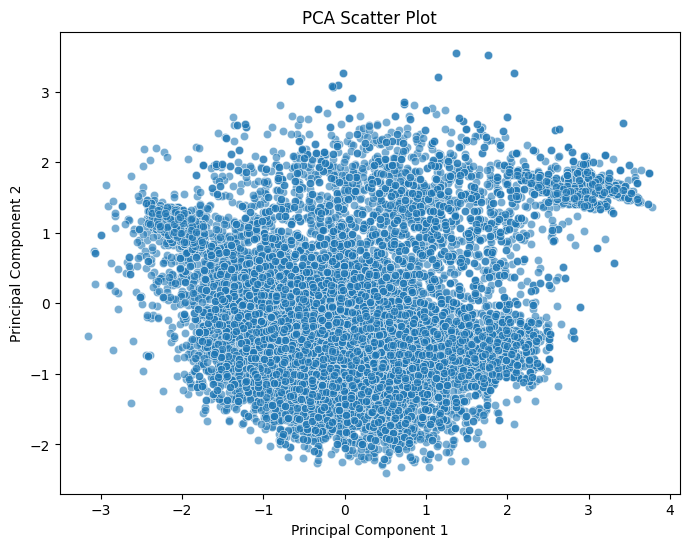

In [72]:
# Convert PCA array into DataFrame
pca_df2 = pd.DataFrame(hr_pca_reduced, columns=['PC1', 'PC2', 'PC3', 'PC4', 'PC5'])
# Scatter plot of PC1 vs PC2
plt.figure(figsize=(8, 6))
sns.scatterplot(x=pca_df2['PC1'], y=pca_df2['PC2'], alpha=0.6)
# Labels and title
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("PCA Scatter Plot")
# Show the plot
plt.show()
# Show the plot
plt.show()

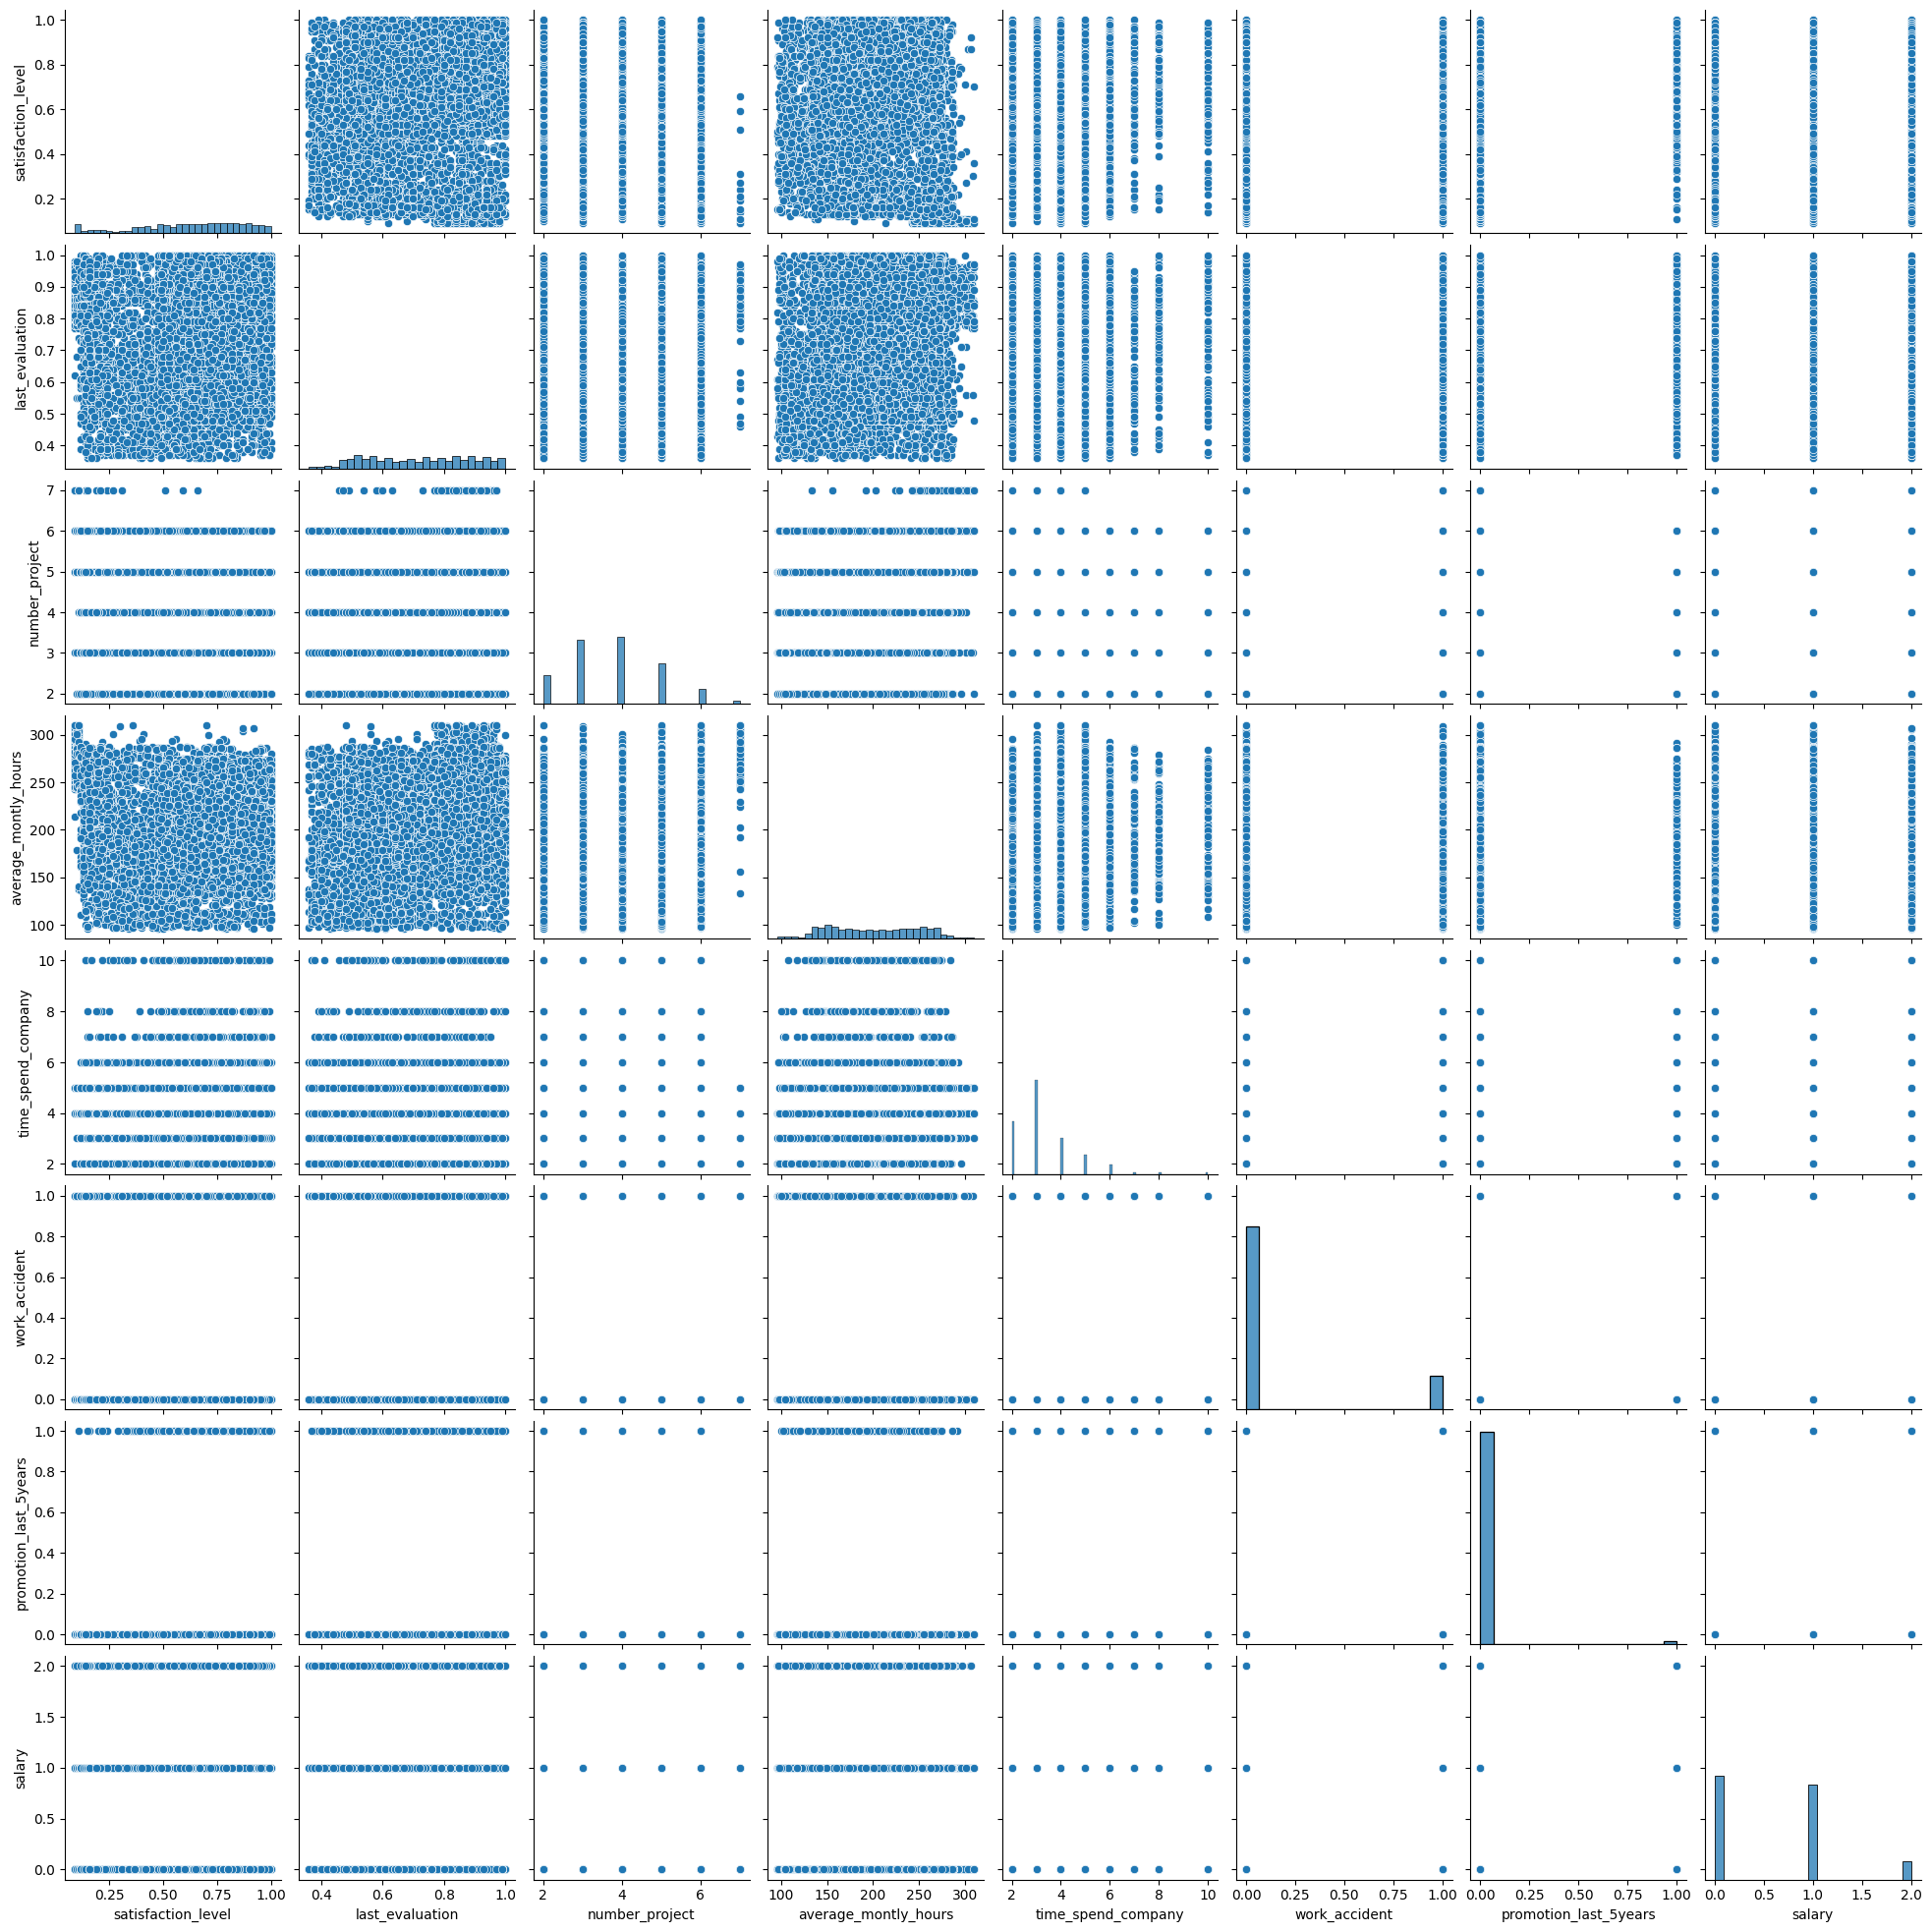

In [73]:
sns.pairplot(x)

Data does not seem to form well-separated clusters. As such, neither DBSCAN or K-mean clustering may produce satisfying results.  
That's the reason why we will turn to feature building. In a next study, it would be a good idea to re-check clustering.

#### NEW FEATURES

Adding new features allows to tackle multicollinearity along with increasing predictive power. Starting from the variables in our df, we could engineer these new variables:
  
- work intensity: measures the workload relative to projects. This helps in reducing correlation between number of project and average working hours.  
- satisfaction gap: difference between the last_evaluation and the satisfaction level. This feature should prevent data leak, as satisfaction is highly correlated with the target variable.  
- Overworking: shows workers that work more than the standard 40-working hours week (4.34 x 40= 174 hours x month). It is 1 if so, 0 if not.  

In [74]:
#duplicate the df
x_final = x_gre.copy()

#work intensity
x_final["work_intensity"] = x_final["average_montly_hours"] / x_final["number_project"]

#satisfaction gap
x_final["satisfaction_gap"] = x_final["last_evaluation"] - x_final["satisfaction_level"]

#overworking
x_final["overworking"] = (x["average_montly_hours"] > 174).astype(int)

#show the updated df
x_final

satisfaction_level  last_evaluation  number_project  \
0                    0.38             0.53               2   
1                    0.80             0.86               5   
2                    0.11             0.88               7   
3                    0.72             0.87               5   
4                    0.37             0.52               2   
...                   ...              ...             ...   
11995                0.90             0.55               3   
11996                0.74             0.95               5   
11997                0.85             0.54               3   
11998                0.33             0.65               3   
11999                0.50             0.73               4   

       average_montly_hours  time_spend_company  work_accident  \
0                       157                   3          False   
1                       262                   6          False   
2                       272                   4          False   
3                       223                   5          False   
4                       159                   3          False   
...                     ...                 ...            ...   
11995                   259                  10           True   
11996                   266                  10          False   
11997                   185                  10          False   
11998                   172                  10          False   
11999                   180                   3          False   

       promotion_last_5years  salary  grouped_dept_Tech  grouped_dept_admin  \
0                      False       0              False               False   
1                      False       1              False               False   
2                      False       1              False               False   
3                      False       0              False               False   
4                      False       0              False               False   
...                      ...     ...                ...                 ...   
11995                   True       2              False                True   
11996                   True       2              False                True   
11997                   True       2              False                True   
11998                   True       2              False               False   
11999                  False       0               True               False   

       work_intensity  satisfaction_gap  overworking  
0           78.500000              0.15            0  
1           52.400000              0.06            1  
2           38.857143              0.77            1  
3           44.600000              0.15            1  
4           79.500000              0.15            0  
...               ...               ...          ...  
11995       86.333333             -0.35            1  
11996       53.200000              0.21            1  
11997       61.666667             -0.31            1  
11998       57.333333              0.32            0  
11999       45.000000              0.23            1  

[11991 rows x 13 columns]

Let's display the correlation matrix to decide which features should be kept.

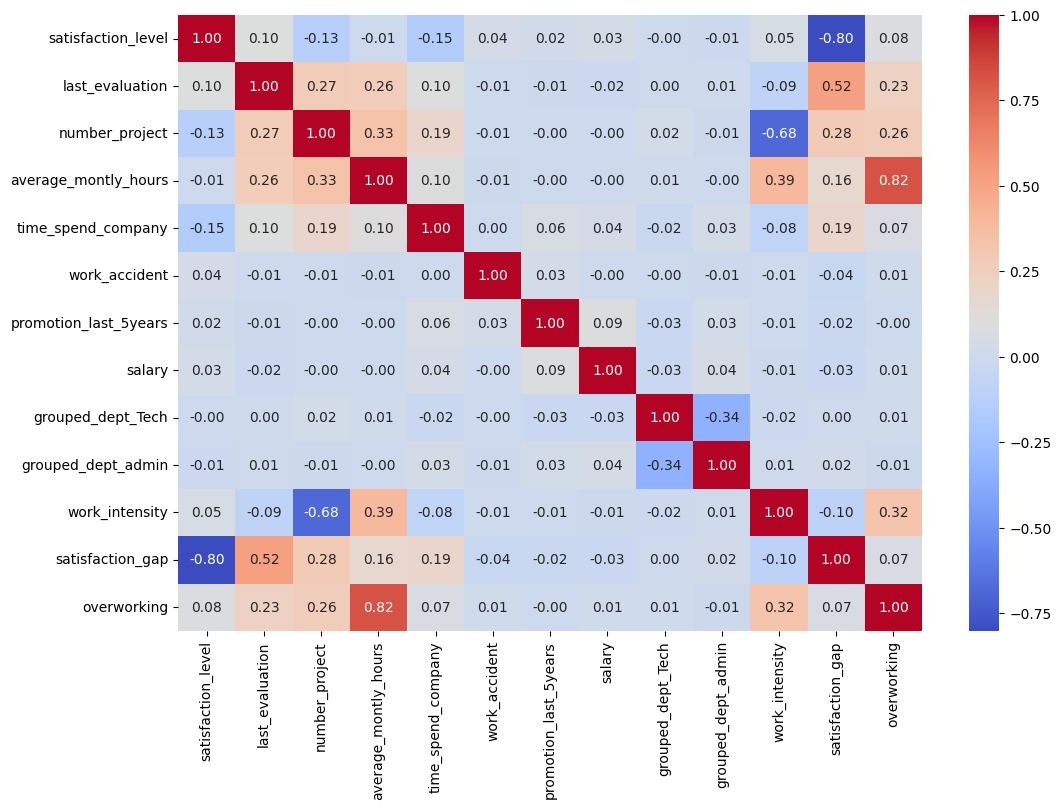

In [75]:
# Compute correlation matrix
corr_matrix = x_final.corr()
# Set figure size
plt.figure(figsize=(12, 8))
# Create heatmap with larger font size for annotations
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", annot_kws={"size": 10})
# Show the plot
plt.show()

As predictable, the new computed features are highly correlated with the ones they come from. That's the reason why we are going to drop some of our original features, such as:  
  
- project number and average monthly hours: as these were strictly correlated and are included both in work intensity and overworking.
- satisfaction_level and last_evaluation: this prevents data leak. Plus, both are incuded within the satisfaction_gap.  
  
However, before taking drastic decisions, we must check the correlation between our explanatory variables and the target.

In [76]:
#check correlation
df3 = x_final.copy()
df3["left"] = y
#compute the entire correlation matrix
newleftcor = df3.corr(numeric_only=True)
#filter just for the column left
newleftcor = newleftcor["left"].drop("left")
#print it
print("Correlation between Left and various regressors:")
newleftcor

Correlation between Left and various regressors:


satisfaction_level      -0.350558
last_evaluation          0.013520
number_project           0.030928
average_montly_hours     0.070409
time_spend_company       0.173295
work_accident           -0.125436
promotion_last_5years   -0.044657
salary                  -0.118882
grouped_dept_Tech       -0.008070
grouped_dept_admin      -0.002939
work_intensity           0.067178
satisfaction_gap         0.309300
overworking             -0.081811
Name: left, dtype: float64

Satisfaction_gap appears to be less correlated than satisfaction_level.  It is important to prevent data leak when modeling. Yet, it is fundamental to understand correlation values: features with low correlation may add very few predictive power; on contrast higher target correlated features may add important predictive power to the model. That's the reason why we are not that concerned about the relationship satisfaction_gap and left.  

Let's drop the variables we will not use from the final df.

In [77]:
#duplicate the df
x_fe = x_final.copy()
# drop the not useufl var
x_fe = x_fe.drop(["satisfaction_level", "last_evaluation", "number_project", "average_montly_hours"], axis = 1)
#check the process
x_fe["overworking"] = x_fe["overworking"].astype(bool)
#check it
x_fe.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11991 entries, 0 to 11999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   time_spend_company     11991 non-null  int64  
 1   work_accident          11991 non-null  bool   
 2   promotion_last_5years  11991 non-null  bool   
 3   salary                 11991 non-null  int64  
 4   grouped_dept_Tech      11991 non-null  bool   
 5   grouped_dept_admin     11991 non-null  bool   
 6   work_intensity         11991 non-null  float64
 7   satisfaction_gap       11991 non-null  float64
 8   overworking            11991 non-null  bool   
dtypes: bool(5), float64(2), int64(2)
memory usage: 526.9 KB


The engineered df is now ready. It is important to note a couple of things:  
  
- Feature engineering is an iterative process. Therefore, later on we are going to come back to our engineered features and either drop the less predictive or compute some new ones.  
- We will keep the original dataframe as well (x_final). We will run a model even on that, to check if it performs better than the engineered ones.

## DATA SPLITTING

The last step prior to building the model, is to split the dataset into training-validation-testing.
For our purposes, we will split our data with the following percentage:  
  
- training 60% (x_tr)  
- validation 20% (x_val)  
- testing 20% (x_tt)  

In [78]:
# Split into 80% train (which will be split later) and 20% test
X_train_val, X_tt, y_train_val, y_tt = train_test_split(x_fe, y, test_size=0.2, random_state=0, stratify=y)
# Split 80% train_val into 60% train and 20% validation
X_tr, X_val, y_tr, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=0, stratify=y_train_val)
#note we set test_size=0.25 since 0.25 of the 80% is 0.20 of the final df

Once done, it is possible to begin setting up the models.

#### SCALING

To ease things up, let's prepare also a scaled version for our different sets. We will opt for standardization, and the scaled sets are named:

- X_tr_scal
- X_val_scal
- X_tt_scal
  
We will scale just numerical variables, keeping unchanged boolean ones.  
  
Note. We scale AFTER splitting into testing, training and validation sets to avoid data leakages that could lead to overly optimistic performance estimates.

In [79]:
## Scaling all 3 sets and keeping boolean unchanged
# Identify boolean and numerical columns
bool_cols = X_tr.select_dtypes(include=["bool"]).columns
num_cols = X_tr.select_dtypes(include=["int64", "float64"]).columns
# Initialize StandardScaler
scaler = StandardScaler()
# Create copies to keep original structure
X_tr_scal = X_tr.copy()
X_val_scal = X_val.copy()
X_tt_scal = X_tt.copy()
# Fit scaler on training data & transform all sets
X_tr_scal[num_cols] = scaler.fit_transform(X_tr[num_cols])  # Fit + transform on training
X_val_scal[num_cols] = scaler.transform(X_val[num_cols])    # Transform validation
X_tt_scal[num_cols] = scaler.transform(X_tt[num_cols])      # Transform test
# Display the transformed dataframes
print(X_tr_scal.head())
print(X_val_scal.head())
print(X_tt_scal.head())

       time_spend_company  work_accident  promotion_last_5years    salary  \
10388           -1.033358          False                  False -0.947816   
7447            -0.272460          False                  False  0.629101   
9958            -0.272460          False                  False -0.947816   
11004           -0.272460          False                  False -0.947816   
1080             1.249337          False                  False  0.629101   

       grouped_dept_Tech  grouped_dept_admin  work_intensity  \
10388              False               False       -1.078607   
7447                True               False       -0.082367   
9958               False                True       -1.088913   
11004               True               False       -0.271309   
1080               False               False        0.132340   

       satisfaction_gap  overworking  
10388         -0.307465         True  
7447          -0.343377        False  
9958          -1.456637         Tru

## MODELING

### MODELING PROCEDURE AND CHAMPION MODEL CHOICE

We are going to compare different models' performances to help in choosing a final model. In details, the procedure will go as follows:
  
- Building and cross-validating different model on the training set (x_tr)  
- Evaluate models' results on the validation set (x_val). Accuracy measures and confusion matrix will help in this.
- Test the champion model on the testing set. Re-compute accuracy measures and confusion matrix to evaluate the performances of our model on unseen data.
- Run the champion model on the not-engineered df to check whether it yilelds better results. If that's the case, run the 2-3 best models on this "original" datatset and check which leads to a better result.
- To conclude, assess the results.

Note. We define a table named "evalMetrics" where all of our models' metrics are added and listed, making the comparison phase visually easier.

In [80]:
#define the evaluation metrics df
evalMetrics = pd.DataFrame(columns=["Model", "Accuracy", "Precision", "Recall", "F1", "ROC_AUC"])

#### COMPARISON MAIN METRIC

As acknowledged, The target variable "left" is imbalanced. A model predicting that all employees stay could still be around 80% accurate, making accuracy an unreliable metric for evaluation, as it would fail to identify employees who leave. Therefore, accuracy should not be used to select the best model.  
    
Our primary goal is to predict which employees will leave. Both precision and recall are relevant in this context:
- Precision matters when we want to minimize false positives (incorrectly predicting an employee will leave).
- Recall is crucial when we aim to capture as many departing employees as possible.
  
The natural question is, what are the consequences of misclassification?  
  
- False Positive (FP): The model predicts an employee will leave, but they actually stay. The main risk is that management might hesitate to invest in training or career development for these employees, leading to a workforce that is undertrained and less prepared for future responsibilities. The cost of reduced productivity and delayed projects can be significant but harder to quantify.
- False Negative (FN): The model predicts an employee will stay, but they actually leave. The primary cost is the wasted investment in training, benefits, and onboarding. These losses are more tangible and could be estimated using data on training costs, healthcare benefits, and other employee-related expenses.  
  
Correctly identifying employees at risk of leaving is highly valuable, as it helps firms allocate resources more efficiently and reduce financial losses. However, failing to train employees who stay can also have long-term negative effects.  

Since both precision and recall are important, we need a metric that balances them. The F1-score, which is the harmonic mean of precision and recall, is an appropriate choice for selecting the best-performing model. We will opt for it.  
  
Yet, we will not consider the F1 alone. We'll consider it altogether the ROC-AUC score, to have a complete view about how well our model distinguishes between classes. (models with an AUC > 0.8 do an fairly good job in discrimate between classes).

### REGRESSION

#### LOGISTIC REGRESSION

The first model we will try is a simple Logistic regression. In general, this kind of model performs well and does not have strict assumptions. These are:
  
- Linearity: assumes a linear relatiosnhip between Xs and the logit of the probability that the target variable = 1. We are assuming this.
- Independence: data points are independent. This should be true for our df, as employees have been measured just one time and an employee's answers do not influence one another.
- Absence of multicollinearity: we tackled this during feature engineering.
- No extreme outliers: as we checked above, there were some outliers for time_spend_company. Yet, none of those is severe.  
  
In this case, all the assumptions hold, therefore it is possible to build the model.

In [81]:
##logistic regression
# build the classifier (clf)
logreg = LogisticRegression(max_iter=500).fit(X_tr, y_tr)
#show the coefficients
print("The logistic regression coefficients are:")
print(logreg.coef_)
print("")
print("The intercept of the regression is:")
print(logreg.intercept_)

The logistic regression coefficients are:
[[ 0.35424422 -1.61923761 -1.1510987  -0.5876146  -0.05793551 -0.08154246
   0.026782    3.34101815 -1.27444728]]

The intercept of the regression is:
[-3.68787752]


After setting the model up, we can focus on inference. We will try to predict the outcomes (0 or 1) along with showing the actual probabilities.

In [82]:
#predict logistic outomes
logreg.predict(X_val)

array([ True, False, False, ..., False, False, False])

In [83]:
#show actual probabilities
logreg.predict_proba(X_val)

array([[0.48161312, 0.51838688],
       [0.99717858, 0.00282142],
       [0.88508092, 0.11491908],
       ...,
       [0.95084743, 0.04915257],
       [0.99148357, 0.00851643],
       [0.92366438, 0.07633562]])

Let's briefly interpret the results. As an example, our model is forecasting that our employee #1 will leave the company (left = True). In details, it sees a 48.16% probability that the sample belongs to class 0 and 51.84% probability that it belongs to class 1.  
  
It is clear that inspecting the results one-by-one will take really long time. As such, we are going to compute evaluation metrics and the confusion matrix to assess our model.

In [84]:
logreg_metrics = model_evaluation(logreg, X_val, y_val, "Logistic Regression")


Evaluation Metrics for Logistic Regression:
Accuracy     : 0.8207
Precision    : 0.3933
Recall       : 0.1482
F1 Score     : 0.2153
ROC AUC Score: 0.8343
----------------------------------------


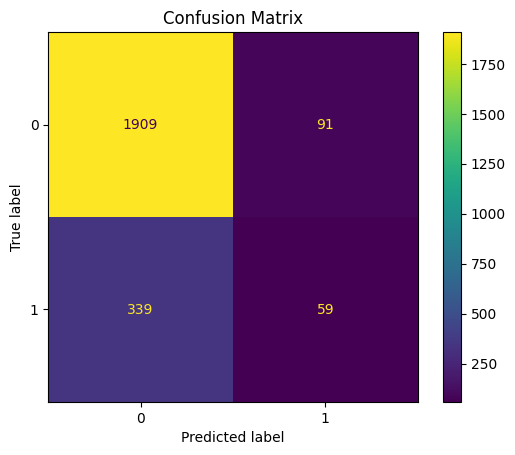

In [85]:
conf_matrix_plot(logreg, X_val, y_val)

The confusion matrix and evaluation metrics indicate that the logistic regression model performs fairly well in predicting employees who stay (overall accuracy ~82%). However, its ability to correctly identify employees who leave is poor, as reflected by the low precision (~0.39) and recall (~0.15).  
This means that while the model can correctly classify those who remain, it frequently misclassifies employees who actually leave. The low F1 score (0.2153) further highlights the imbalance in performance, suggesting that the model struggles to capture meaningful patterns related to employee attrition.  
  
Since the goal is to accurately predict employees at risk of leaving, this model would not be reliable in its current state. 

Let's add the logistic regression results' to the evalMetrics table.

In [86]:
add_evaluation(logreg_metrics, "Logistic Regression")

Model  Accuracy  Precision    Recall        F1   ROC AUC
0  Logistic Regression  0.820684   0.393333  0.148241  0.215328  0.834251

To get the most of this model, let's display feature importance to get an idea of which of them contribute the most to predictions.

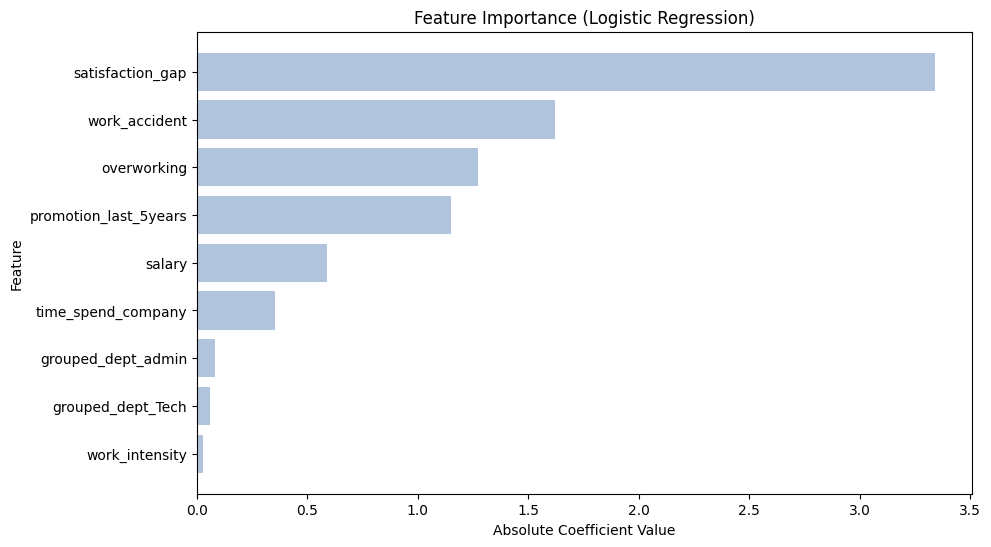

In [87]:
# extract feature importance
feature_importance = abs(logreg.coef_[0])  # Take absolute values of coefficients
#columns names based on X-tr
feature_names = X_tr.columns

# Create a DataFrame for better visualization
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance})
importance_df = importance_df.sort_values(by='Importance', ascending=False)  # Sort by importance

# Plot
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='lightsteelblue')
plt.xlabel('Absolute Coefficient Value')
plt.ylabel('Feature')
plt.title('Feature Importance (Logistic Regression)')
plt.gca().invert_yaxis()  # Invert y-axis to show highest importance at the top
plt.show()

Satisfaction gap, work accidents, and overworking are the features that contribute the most. Conversely, work intensity contributes the least.  
  
To double-check that, we will implement a LASSO regression.

#### LASSO LOGISTIC REGRESSION

As we have seen, the logistic regression does not perform well. However, it informed us about which features are contributing the most to the forecasts.  
  
We will exploit this thanks to the LASSO regression. Indeed, it adds a penalty to the coefficients, efficiently leading the least-contributing ones to 0, removing them from the model.  
  
In this specific case, we do not expect LASSO to yield that better results than the "standard" logistic regressior. As such, we are not going to forecast using LASSO. However, we are going to use LASSO results as guidelines on which variables should be disregarded if our models prove to be too complex.  
  
Note. LASSO needs scaled data.

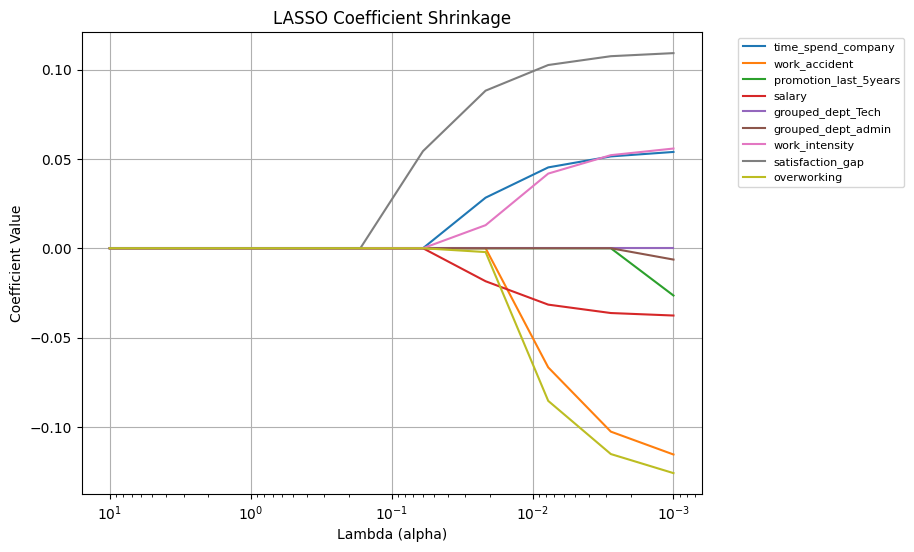

In [88]:
# Define range of lambda (alpha) values
alphas = np.logspace(-3, 1, 10)  # 10 values from 10⁻³ to 10¹
lasso_coefs = []

# Fit LASSO for each alpha
for alpha in alphas:
    lasso = Lasso(alpha=alpha, fit_intercept=True, max_iter=5000)  # Increase iterations if needed
    lasso.fit(X_tr_scal, y_tr)
    lasso_coefs.append(lasso.coef_)

# Convert to DataFrame for better readability
lasso_coefs = np.array(lasso_coefs)
feature_names = X_tr.columns  # Get feature names

# Plot coefficient shrinkage
plt.figure(figsize=(8,6))
for i, feature in enumerate(feature_names):
    plt.plot(alphas, lasso_coefs[:, i], label=feature)

plt.xscale("log")  # Log scale for lambda
plt.gca().invert_xaxis()  # Reverse x-axis (large lambda → stronger shrinkage)
plt.xlabel("Lambda (alpha)")
plt.ylabel("Coefficient Value")
plt.title("LASSO Coefficient Shrinkage")
plt.legend(loc="best", fontsize=8, bbox_to_anchor=(1.05, 1))  # Place legend outside
plt.grid()
plt.show()


As expected with LASSO, the higher the penalization parameter lambda (on the left of the plot) the lower the coefficients' importance. As lambda decreases, more variables are included in the model, with their coefficients gradually moving away from zero.  
  
Notably, some features are removed almost immediately, i.e their coeffs shrink to zero at high lambda values. These are (in order of disappearance):
  
- grouped_dept_tech
- grouped_dept_admin
- promotion_last_5years

This suggests that these variables do not play a significant role in determining whether an employee leaves or stays.  
Conversely, the features that appear to have the strongest influence are (in order):
  
- satisfaction_gap
- time_spend_company
- work_intensity
- salary
  
Overall, this confirms the feature importance ranking from the Logistic Regression model. The only notable difference is with work_intensity, which had a small coefficient in Logistic Regression but now displays remarkable importance. This could be due to two reasons

- LASSO capturing a non-linear effect
- LASSO reducing better the noise

The endpoint is that, if we want to simplify the model without losing predictive power, LASSO recommends discarding departments and promotion related features first, as they do not appear to be highly influential on employees' final decision to leave.

### NAIVE BAYES

Naive Bayes is a relatively easy model that generally performs fairy well.  
NB models take scaled data as input. It also requires a strong assumption about data distribution. In this specific case, we assume our variables are normally distributed (as the Central limit theorem suggests). Therefore, we will opt for the Gaussian version of Naive Bayes.  
  
We expect the Gaussian NB model to lead to outlooks similar to the Logistic regression's one.

In [89]:
# Fit the model
gnb = GaussianNB()
gnb.fit(X_tr_scal, y_tr)
# Get the predictions on test data
gnb_preds = gnb.predict(X_val_scal)

In [90]:
cm = confusion_matrix(y_val, gnb_preds)
print(cm)

[[1715  285]
 [ 142  256]]


Let's check evaluation metrics along with confusion matrix.

In [91]:
gnb_metrics = model_evaluation(gnb, X_val_scal, y_val, "Naive Bayes")

Evaluation Metrics for Naive Bayes:
Accuracy     : 0.8219
Precision    : 0.4732
Recall       : 0.6432
F1 Score     : 0.5453
ROC AUC Score: 0.8242
----------------------------------------


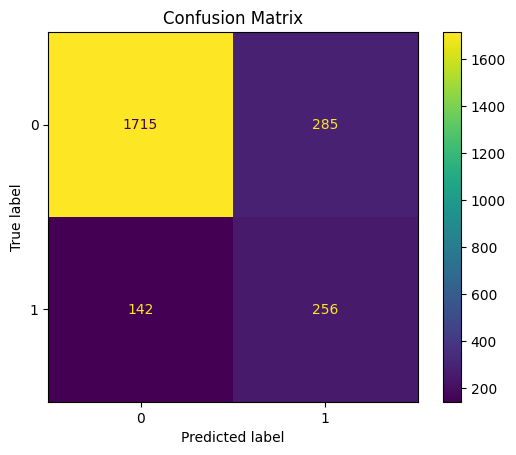

In [92]:
conf_matrix_plot(gnb, X_val_scal, y_val)

The Naive Bayes (NB) model yields slightly better results than logistic regression. However, as seen in the confusion matrix, it produces a significant number of false positives (i.e., predicting churn for customers who stayed). This could be due to the choice of Gaussian Naive Bayes, which works best with continuous variables, while our dataset contains various types of variables. In this case, the ideal approach might involve training separate models based on data type.  
  
On the other hand, the high AUC score suggests that despite the false positives, the model performs well in ranking customers by their likelihood to churn. However, the relatively low F1 score points to the class imbalance in the target variable as a potential issue.  
  
In conclusion, while the Naive Bayes model isn't performing poorly, there is significant room for improvement, particularly through handling the class imbalance or exploring other modeling techniques.

In [93]:
add_evaluation(gnb_metrics, "Gaussian NB")

Model  Accuracy  Precision    Recall        F1   ROC AUC
0  Logistic Regression  0.820684   0.393333  0.148241  0.215328  0.834251
1          Gaussian NB  0.821935   0.473198  0.643216  0.545261  0.824217

### DECISION TREE

Tree-based models are a good resources for classification problems as the one we are tackling. As such, the next model we are going to implement is a decision tree.  
  
Let's instantiate the model and define some parameters and evaluation metrics we will use to fine-tune the tree.  
  
Note. Setting the random state allows results reproducibility. 

In [94]:
#instantiate the tree
tree = DecisionTreeClassifier(random_state=10)

In [95]:
#define the parameters that will be tuned
tree_pars = {"max_depth":[4,5,6,7,8,9,10,11,12,15,20,30,40,50],
             "min_samples_leaf": [2,5,10,20,50],
             "min_samples_split": [5,10,20,40,100]}

In [96]:
#define the evaluation metrics considered
scoring = ['accuracy', 'precision', 'recall', 'f1', "roc_auc"]

Now, it is time to fine-tune the model. We will employ GridSearch along with cross-validations with 5 folds. The chosen model will be the one with the highest F1 score. 

In [97]:
#instantiate the GridSearch
treeclf = GridSearchCV(tree, 
                   tree_pars, 
                   scoring = scoring, 
                   cv=5, 
                   refit="f1")

In [98]:
#fit the model
treeclf.fit(X_tr, y_tr)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=10),
             param_grid={'max_depth': [4, 5, 6, 7, 8, 9, 10, 11, 12, 15, 20, 30,
                                       40, 50],
                         'min_samples_leaf': [2, 5, 10, 20, 50],
                         'min_samples_split': [5, 10, 20, 40, 100]},
             refit='f1',
             scoring=['accuracy', 'precision', 'recall', 'f1', 'roc_auc'])

In [99]:
#examine the best estimator
treeclf.best_estimator_

DecisionTreeClassifier(max_depth=8, min_samples_leaf=5, min_samples_split=20,
                       random_state=10)

In [100]:
#check the best validation score
print("Best Avg. Validation Score:", "%.4f" % treeclf.best_score_)

Best Avg. Validation Score: 0.8862


The "best" decision tree is the one having the following parameters:

- max_depth = 8
- min_sample_leaf = 5
- min_samples_split = 20
  
Let's display the tree's first splits.

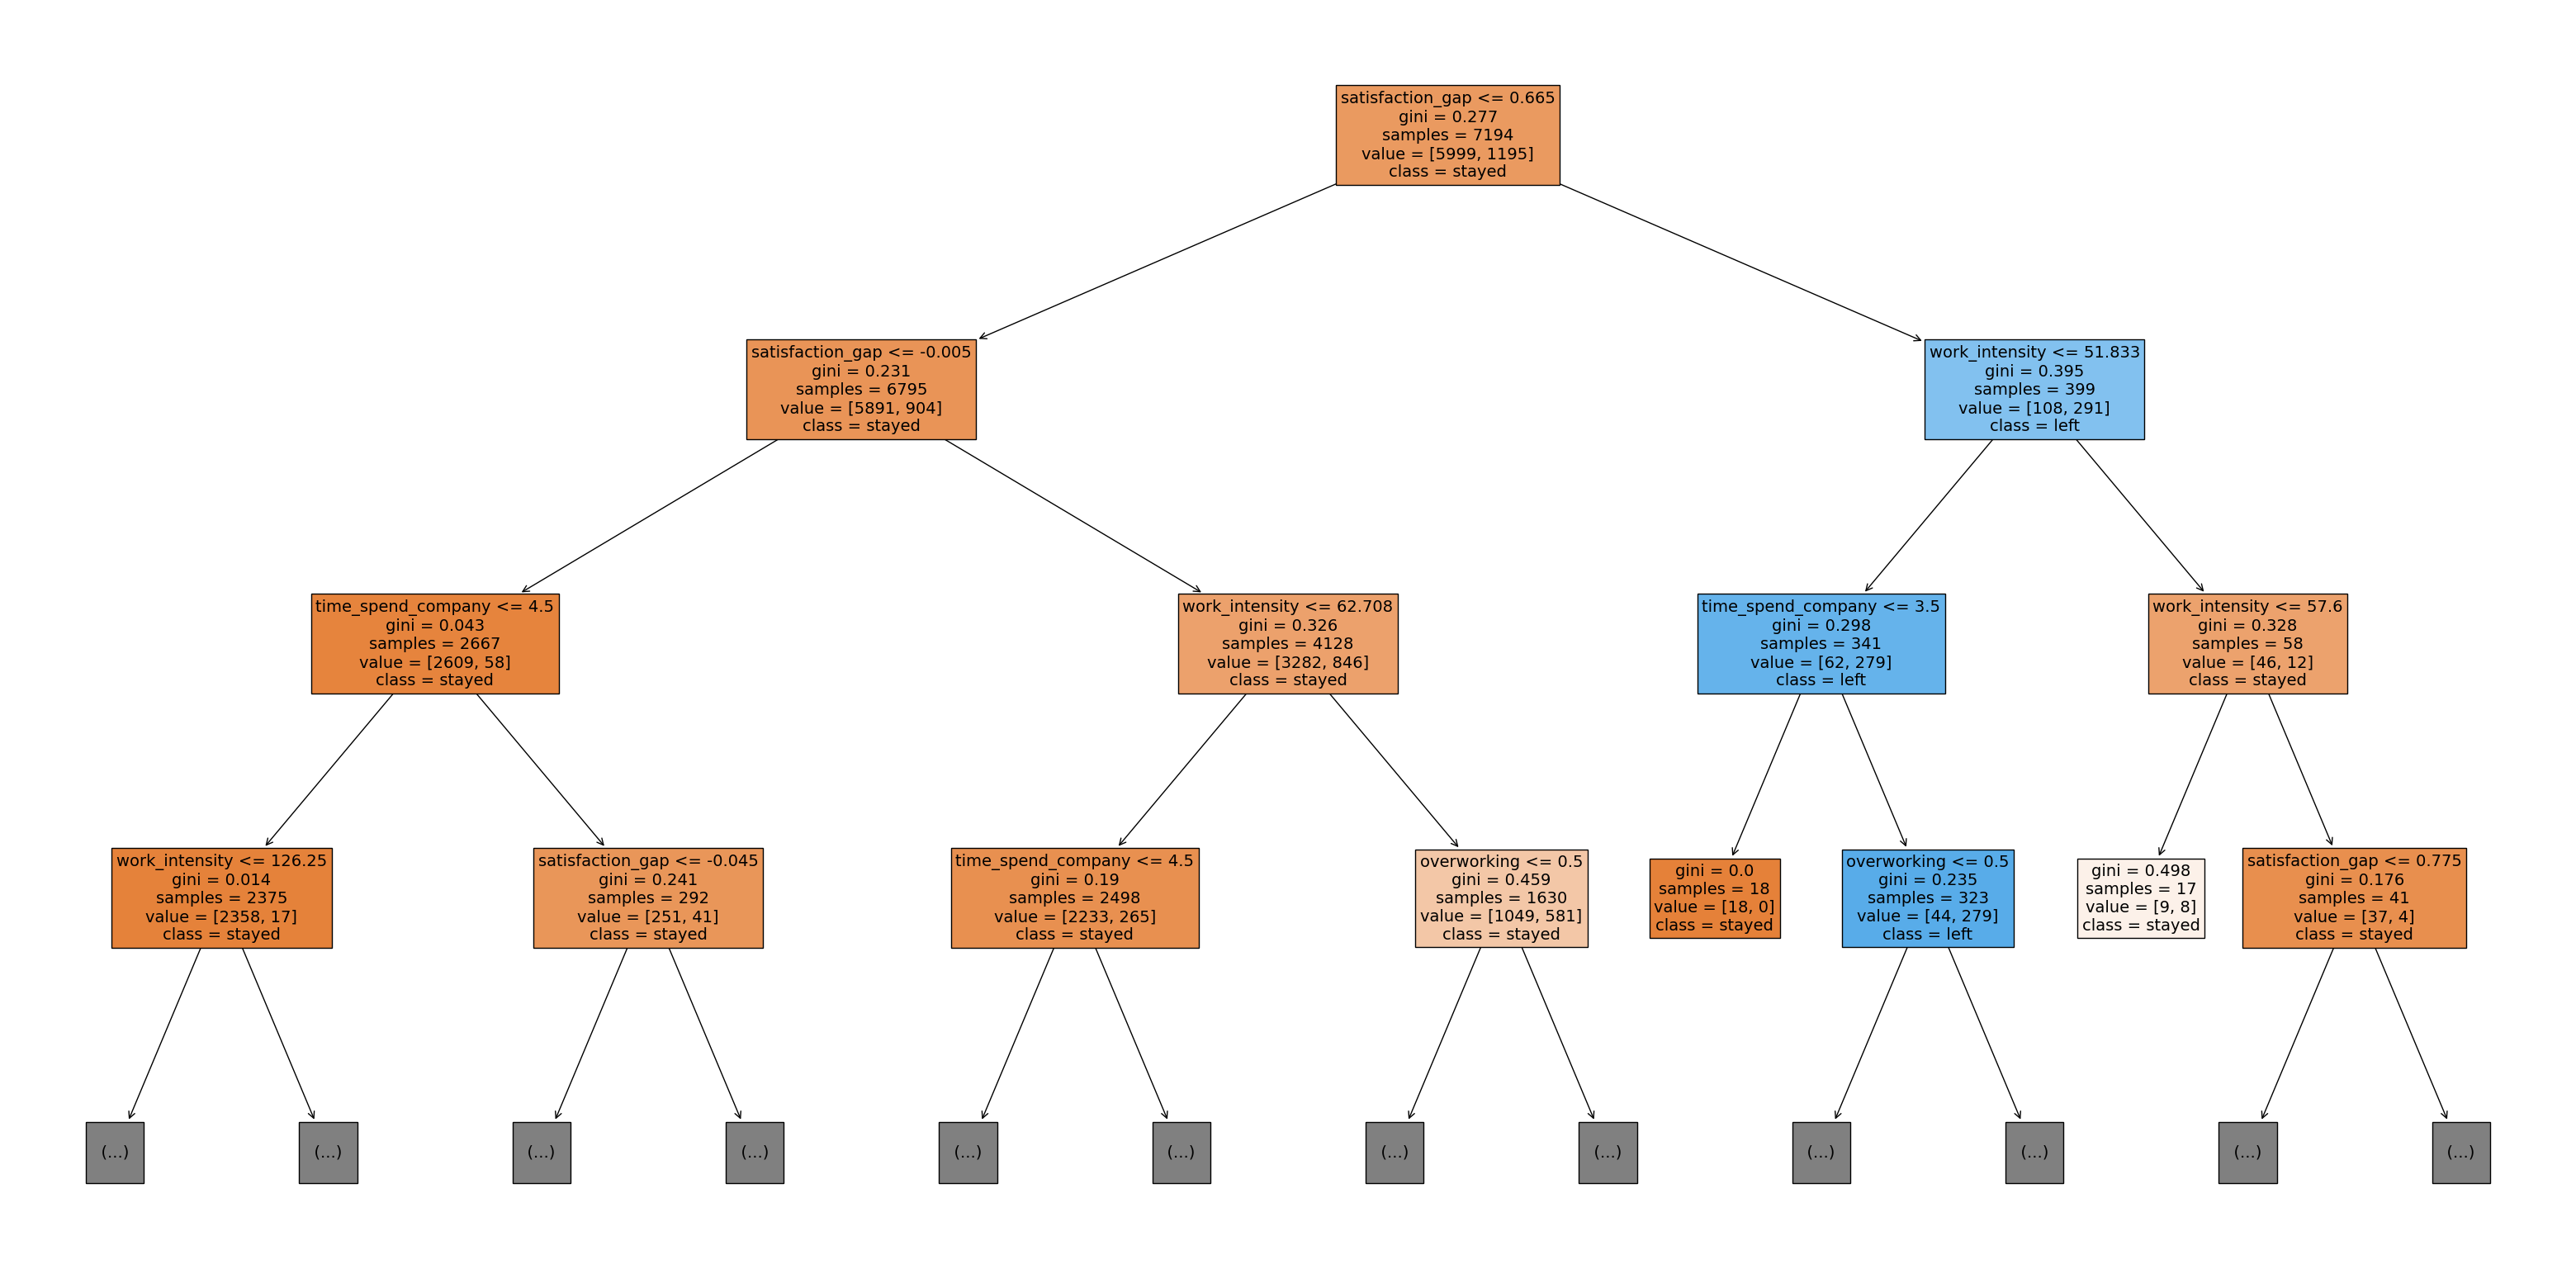

In [101]:
# Plot the tree
best_tree = treeclf.best_estimator_
plt.figure(figsize=(40,20))
plot_tree(best_tree, max_depth=3, fontsize=14, feature_names=X_tr.columns, 
          class_names={0:'stayed', 1:'left'}, filled=True);
plt.show()

The decision tree visualization highlights that satisfaction_gap plays a crucial role in the splitting process. In fact, if the tree were limited to a single split, it would be based on satisfaction_gap, with a threshold of 0.665.  
  
Looking at deeper splits, work_intensity emerges as another strong predictor, alongside satisfaction_level. This suggests that employees’ likelihood of leaving the company is heavily influenced by both their job satisfaction and workload.  
  
Notably, the first split alone already creates a strong separation between the two major classes: employees who stayed and employees who left. This indicates that satisfaction_level is a key differentiator in predicting employee churn.  
  
While visualizing the tree provides an intuitive understanding of feature importance, a more detailed analysis (e.g., feature importance scores) can help quantify the extent to which each feature contributes to predictions.

In [102]:
tree_impo = feature_importances(best_tree, X_val)
tree_impo

Importance
satisfaction_gap         0.331627
overworking              0.309434
work_intensity           0.181251
time_spend_company       0.176730
salary                   0.000380
grouped_dept_Tech        0.000337
work_accident            0.000215
promotion_last_5years    0.000026
grouped_dept_admin       0.000000

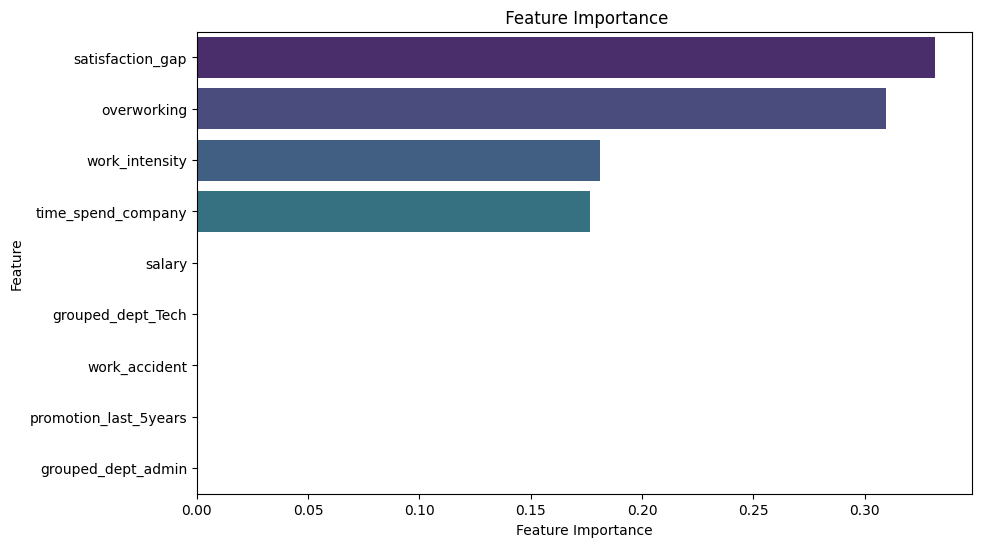

In [103]:
importances_plot(tree_impo)

The most important features across both models are satisfaction_gap, overworking, work_intensity, and time_spent_at_company. Other features contribute minimally, with grouped_dept_admin standing out as the only variable with zero importance.  
  
Comparing the feature importance of the decision tree and logistic regression reveals some key similarities and differences. Both models identify satisfaction_gap as the most influential factor and assign significant weight to overworking. Additionally, time_spent_at_company plays a role in both models, though its impact is stronger in the decision tree.  
However, notable differences emerge:  

- Work accident and promotion in the last five years are considered highly predictive in logistic regression but have little influence in the decision tree.
- Salary, which logistic regression ranks as an important factor, holds almost no importance in the decision tree.  
  
The natural question is, why do features importance differ? That's because feature importance varies between models due to how they process information:  
  
- Logistic regression assigns importance based on how strongly a feature correlates with the target variable. If a variable has a strong linear relationship with the outcome, it will be considered significant.  
- Decision trees, on the other hand, determine importance based on how much a feature reduces uncertainty (i.e., decreases impurity) when making splits. Features that create the most decisive splits in the data will be ranked higher, even if their linear correlation with the target is weak.  
  
This explains why salary is important in logistic regression but not in the tree: its impact might be more linear, but it does not significantly contribute to reducing classification uncertainty. The same applies to work accident and promotion, which might show strong linear effects but are not among the most useful features for splitting the data effectively.

Once we have identified the key features influencing the tree's decision-making process, the next step is to evaluate its performance on unseen data and compare it with other models.  
  
Let's compute the evaluation metrics

In [104]:
tree_metrics = model_evaluation(treeclf, X_val, y_val, "Decision Tree")

Evaluation Metrics for Decision Tree:
Accuracy     : 0.9741
Precision    : 0.9541
Recall       : 0.8869
F1 Score     : 0.9193
ROC AUC Score: 0.9643
----------------------------------------


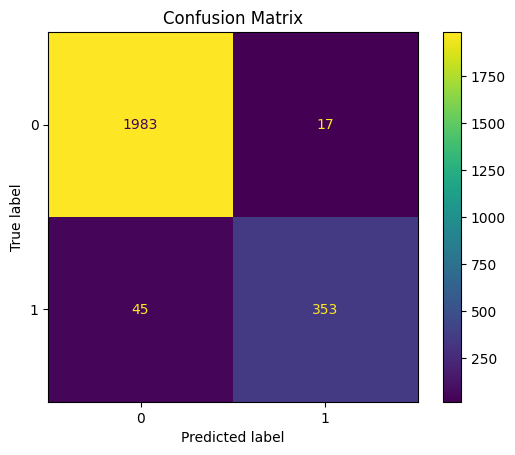

In [105]:
conf_matrix_plot(treeclf, X_val, y_val)

The decision tree yields strong results when tested on the validation set.  
  
All evaluation metrics exceed 0.85, with an F1 score above 0.9, indicating a well-balanced model. The lowest metric is recall (0.8844), meaning the model may struggle slightly in identifying all employees who left. Still, it correctly identifies 88% of actual quitters, which is a solid performance.  
  
The confusion matrix confirms these results, showing that the model misclassified only 63 employees. Given a dataset of more than 2000 workers, this represents a relatively low error rate.  
  
Overall, we can be quite confident in the decision tree's predictive ability. If simplicity and low computational cost become constraints in the future, this model could serve as a strong, interpretable baseline. However, since we currently have no such limitations, we will explore more complex models to further refine our predictions.  

Regardless, we will include the evaluation metrics for this decision tree in our model comparison table.

In [106]:
add_evaluation(tree_metrics, "Decision Tree")

Model  Accuracy  Precision    Recall        F1   ROC AUC
0  Logistic Regression  0.820684   0.393333  0.148241  0.215328  0.834251
1          Gaussian NB  0.821935   0.473198  0.643216  0.545261  0.824217
2        Decision Tree  0.974145   0.954054  0.886935  0.919271  0.964274

As expected, the decision tree currently delivers the best performance, achieving the highest F1-score among the tested models.

### RANDOM FOREST

Random Forest is a more complex model composed by an ensemble of decision trees.  
  
The procedure to tune the random forest is the same as for decision tree. The only difference is that this time more parameters need to be tuned.  
  
Note. We are going to use pickle to save the model into the "models" folder. This way, avoid re-running the same slow cell every time the analysis is performed. 

In [107]:
#define a path to store the saved models (the model folder)
path = "/Users/lucaalbertini/Desktop/MLCourse/ML/Salifort_CaseStudy/models/"

In [108]:
#instantiate the RF classifier
rf_clf = RandomForestClassifier(random_state=0)

In [109]:
#set the parameters
rf_param = {'max_depth': [2,3,4,5, 6,7,8], #single trees' max depth
             'min_samples_leaf': [1,2,3],
             'min_samples_split': [2,3,4],
             'max_features': [2,3,4,5,6,7,8], #how many variables it should consider x tree
             'n_estimators': [75, 100, 125, 150] #how many trees it should fit
             }

Note. We are not going to define scoring parameters, as we have already defined them while tuning the decision tree (and named them "scoring").

In [110]:
#Apply the Gridsearch w/ 5 folds cross validation
rf_cv = GridSearchCV(rf_clf, 
                     rf_param, 
                     scoring=scoring, 
                     cv=5, #5 folds
                     refit='f1') #f1 is the main metrics for champion selection

Once the gridsearch is defined, we can fit our random forest model. The lines below do exactly that, but they have been commented out as have already been run (and takes long time to do so).  
  
Instead of re-fitting the model everytime we run this analysis, we are going to load it from the one we saved in the "models" folder.

In [111]:
#fit the model (#line is commented as the model is loaded later on from pickle)
#rf_cv.fit(X_tr, y_tr)

#running time 168m

In [112]:
#Save the model to "models" folder (line commented as it has already been saved)
#with open(path+'rf_model.pickle', 'wb') as to_write:
 #   pickle.dump(rf_cv, to_write)

In [113]:
#load the model (if it has already been saved)
with open(path+'rf_model.pickle', 'rb') as to_read:
    rf_cv = pickle.load(to_read)

Let's display early parts of the forest to get an idea of it.

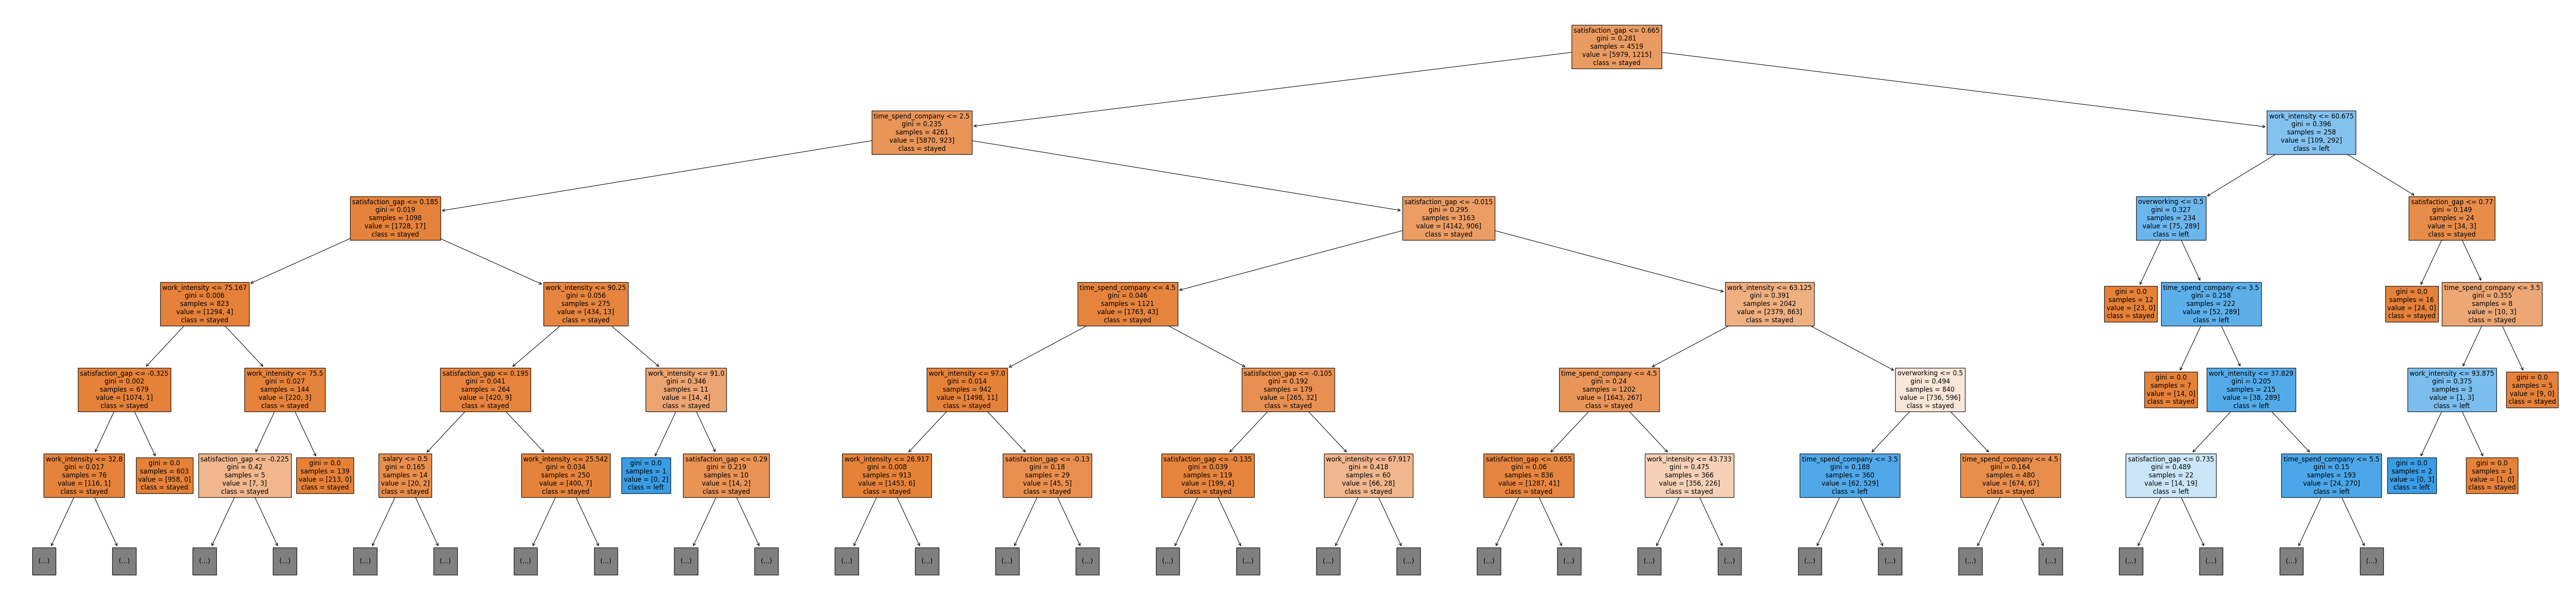

In [114]:
# Plot the rf
plt.figure(figsize=(85,20))
plot_tree(rf_cv.best_estimator_[0], max_depth=5, fontsize=12, feature_names=X_tr.columns, 
          class_names={0:'stayed', 1:'left'}, filled=True)
plt.show()

Not surpisingly, the random forest confirms some intuitions coming from the decision tree. The first split is based on the satisfaction gap. Major roles in the split are also played by the time spent at the company and the work intensity.  
  
Overall, this confirms insights coming from the previous model too: employees likelihood to quit highly depends upon his/her satisfaction gap, experiences and amount of work.  
  
Let's now visualize in detail how important is each variable.

In [115]:
forest_impo = feature_importances(rf_cv, X_val)
forest_impo

Importance
satisfaction_gap         0.323219
overworking              0.263631
work_intensity           0.204044
time_spend_company       0.193815
salary                   0.005984
work_accident            0.004548
grouped_dept_admin       0.002186
grouped_dept_Tech        0.002099
promotion_last_5years    0.000474

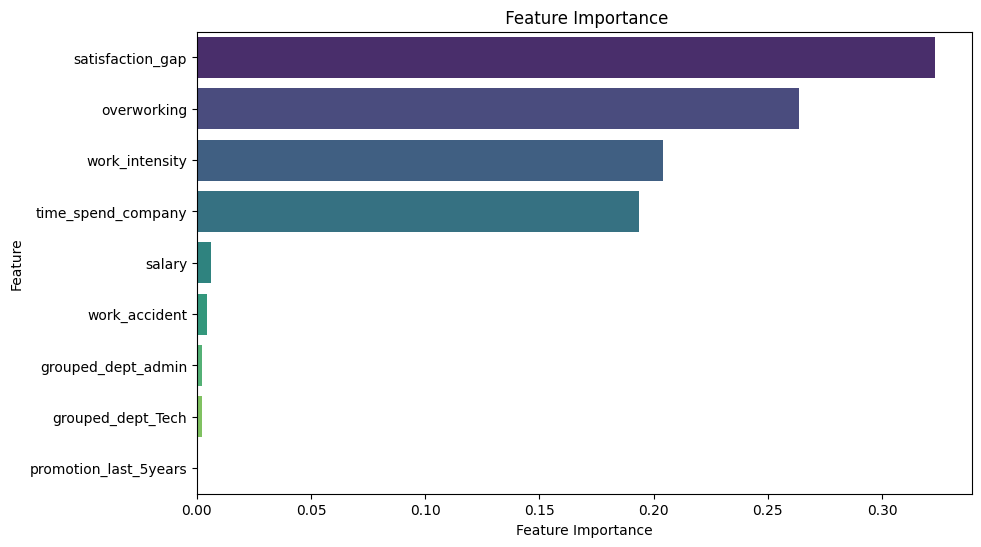

In [116]:
importances_plot(forest_impo)

The four key factors influencing whether an employee will leave are satisfaction gap, overworking, work intensity, and time spent at the company—an unsurprising outcome given their direct impact on job satisfaction and workload.  
  
However, what stands out is the shift in explanatory power for certain features. While still less significant compared to the top four, salary, work accidents, and department have gained importance, with salary emerging as a particularly influential factor.  
  
Why did this happen? One possible explanation is that a random forest is an ensemble of multiple decision trees, each trained on different subsets of the data and considering different predictors. As a result, features like salary, which might not have been dominant in a single decision tree, could have played a crucial role in some trees, increasing their overall importance in the final model.  
  
Lastly, receiving a promotion in the last five years appears to have little to no impact on an employee’s decision to leave, suggesting that other factors outweigh its influence

Let's now turn to evaluation metrics.

In [117]:
forest_metrics = model_evaluation(rf_cv, X_val, y_val, "Random Forest")

Evaluation Metrics for Random Forest:
Accuracy     : 0.9746
Precision    : 0.9517
Recall       : 0.8920
F1 Score     : 0.9209
ROC AUC Score: 0.9781
----------------------------------------


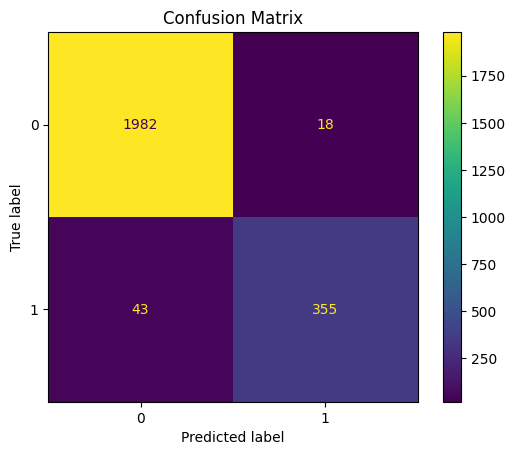

In [118]:
conf_matrix_plot(rf_cv, X_val, y_val)

The random forest model performs exceptionally well on the validation dataset.  
  
Most evaluation metrics exceed 0.90, with accuracy, precision, and ROC AUC all surpassing 0.95. Accuracy (0.9746) confirms that the model is highly effective at distinguishing between employees who will stay and those who will leave. ROC AUC (0.9781) indicates that the model can correctly rank employees based on their likelihood of quitting. Precision (0.9517) suggests that when the model predicts an employee will leave, it is correct most of the time.  
  
Similar to decision trees, the model still struggles with recall (0.8920), meaning it does not catch all quitters. However, it significantly improves upon the decision tree by correctly identifying almost 90% of employees who left.  
  
These insights are confirmed by the confusion matrix. The model only misclassifies 61 employees, with most errors being false negatives (i.e., employees who left but were predicted to stay).  
  
The model demonstrates a strong ability to predict employee attrition with high confidence. While recall leaves some room for improvement, the trade-off between precision and recall is well-balanced. Given its strong generalization performance, the random forest is a reliable model for anticipating employee turnover.

Let’s compare its performance against the previously implemented models

In [119]:
#add the row
add_evaluation(forest_metrics, "Random Forest")

Model  Accuracy  Precision    Recall        F1   ROC AUC
0  Logistic Regression  0.820684   0.393333  0.148241  0.215328  0.834251
1          Gaussian NB  0.821935   0.473198  0.643216  0.545261  0.824217
2        Decision Tree  0.974145   0.954054  0.886935  0.919271  0.964274
3        Random Forest  0.974562   0.951743  0.891960  0.920882  0.978130

Up to now, Random forest is providing the best results.

## XGBOOSTING

Boosting is a complext techniques based on consecutive weak learners trying to correct errors made by the weak learner preceding it. Its main strength is its high accuracy, leading to constantly good performances.
  
The procedure to tune the XGBoost model is the same as for the previous ones. Yet, this time even more parameters must be trained.  
  
Note. The Xgboost model is saved in the "model" folder too, as it requires a long running time. 

In [120]:
#instantiate the XGB classifier
xgb_clf = XGBClassifier(objective='binary:logistic', random_state=0) 

In [121]:
#define the parameters
xgb_param = {'max_depth': [4,5,6,7,8,9,10], #how deep each base learner will grow
             'min_child_weight': [1,2,3,4,5], #a tree will not split a node if it results in any child node with less weight than this value
             'learning_rate': [0.05, 0.1, 0.2, 0.3], #weight given to each consecutive base learner's prediction
             'n_estimators': [75, 100, 125, 150], #maximum number of base learner the ensamble will grow
             'colsample_bytree': [0.5, 0.75, 0.9, 1.0],
             'gamma': [0, 0.1, 0.3, 0.5], #prevent unnecessary splits
             "subsample": [0.6, 0.8, 1.0], #% of rows considered
             }

In [122]:
#scoring paramters
scoring

['accuracy', 'precision', 'recall', 'f1', 'roc_auc']

In [123]:
#define the GridSearch for the xgboost
xgb_cv = GridSearchCV(xgb_clf,
                      xgb_param,
                      scoring=scoring,
                      cv=5,
                      refit='f1')

In [124]:
#fit the model (line commented as it has already been run)
#xgb_cv.fit(X_tr, y_tr)

In [125]:
import xgboost
print(xgboost.__version__)

2.1.3


In [126]:
#Save the model to "models" folder (line commented as it has already been saved)
#with open(path+'xgb_model.pickle', 'wb') as to_write:
    #pickle.dump(xgb_cv, to_write)

In [127]:
#load the model (from pickle)
with open(path+'xgb_model.pickle', 'rb') as to_read:
    xgb_cv = pickle.load(to_read)

Let's display the parameter for the best performing XGBoosting.

In [128]:
#show the xgb best parameters
xgb_cv.best_params_

{'colsample_bytree': 0.75,
 'gamma': 0,
 'learning_rate': 0.2,
 'max_depth': 5,
 'min_child_weight': 4,
 'n_estimators': 75,
 'subsample': 1.0}

The best xgboosting is made by 75 trees going as depth as 5 levels. Plus, it employs all the rows in our sample.  
  
Let's now check over feature importance.

In [129]:
#xgb feature importance
xgb_impo = feature_importances(xgb_cv, X_val)
xgb_impo

Importance
time_spend_company       0.256636
overworking              0.213182
satisfaction_gap         0.205763
work_intensity           0.128665
work_accident            0.110932
promotion_last_5years    0.034659
salary                   0.030319
grouped_dept_Tech        0.011196
grouped_dept_admin       0.008648

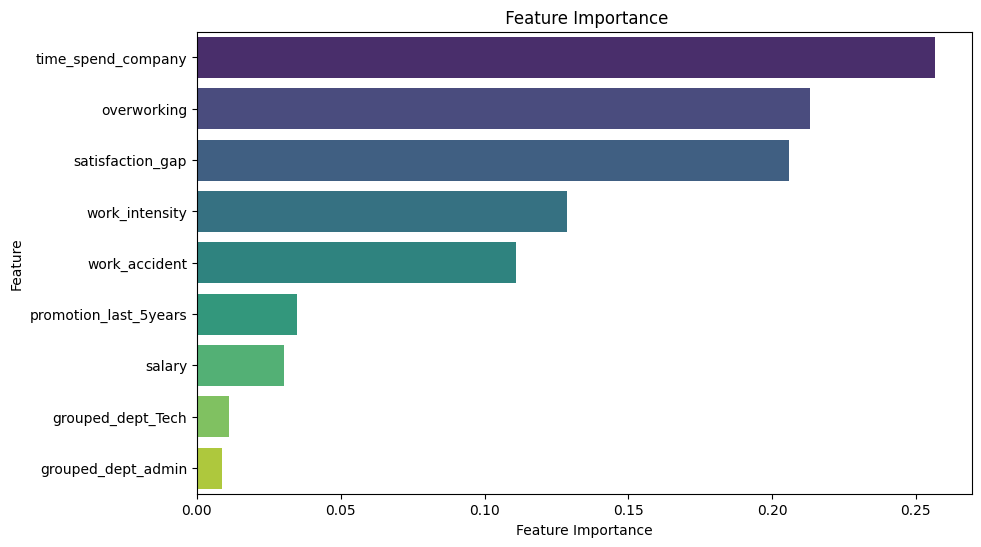

In [130]:
#xgb feat importance plot
importances_plot(xgb_impo)

Once again, the four key factors influencing an employee's decision to quit are time spent at the company, overworking, satisfaction gap, and work intensity. This aligns with previous models, though XGBoost presents a notable shift in their relative importance. Unlike earlier models, which consistently identified satisfaction gap as the top predictor, XGBoost ranks time spent at the company as the most influential factor, followed closely by overworking. This suggests that time-related variables play a dominant role in an employee's decision to leave, while intra-personal factors, such as satisfaction gap, still hold strong predictive power.  
  
A particularly interesting result is the increased importance of work accidents, which had minimal relevance in previous models. This makes intuitive sense—employees who have experienced a workplace accident may perceive their environment as unsafe, making them more likely to leave. Similarly, promotion in the last five years gained importance, possibly indicating that employees who don’t receive promotions may feel undervalued and seek opportunities elsewhere.  
  
Finally, salary and department, while still secondary factors, have gained more relevance compared to previous models. This is likely a result of XGBoost’s ability to consider multiple decision trees, each with different predictor interactions, allowing previously overlooked features to gain influence.

Finally, let's focus on evaluation metrics.

In [131]:
#evaluation metrics
xgb_metrics = model_evaluation(xgb_cv, X_val, y_val, "XGBoosting")

Evaluation Metrics for XGBoosting:
Accuracy     : 0.9708
Precision    : 0.9385
Recall       : 0.8819
F1 Score     : 0.9093
ROC AUC Score: 0.9771
----------------------------------------


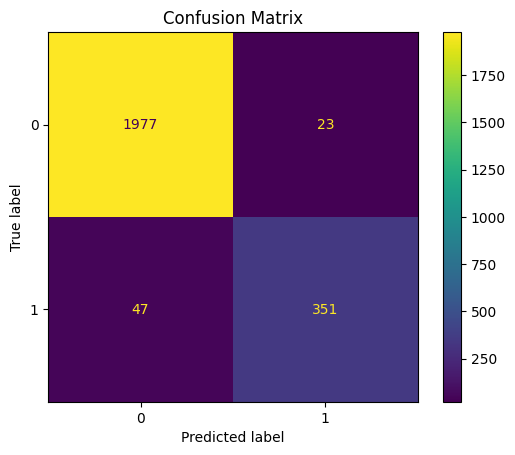

In [132]:
#show the confusion matrix
conf_matrix_plot(xgb_cv, X_val, y_val)

The XGBoost model performs exceptionally well on the validation dataset.  
  
Most evaluation metrics exceed 0.90, with accuracy (0.9708) and ROC AUC (0.9781) surpassing 0.95. This confirms that the model is highly effective at distinguishing between employees who will stay and those who will leave, as well as ranking employees by their likelihood of quitting.  
As with the random forest, the weakest metric is recall (0.8819), meaning the model does not capture all employees who leave. However, it still correctly identifies nearly 90% of quitters.  
  
These findings are reinforced by the confusion matrix, which shows 70 misclassified employees, with the majority being false negatives (i.e., employees who left but were predicted to stay).  

While the model delivers strong results, there is still room for improvement. Computational constraints limited the extent of parameter tuning, meaning potentially better hyperparameter combinations were left unexplored.  
  
To address this, we will implement randomized hyperparameter tuning to systematically search for an optimal configuration, potentially leading to even better results.

### XGBoosting - Randomized Hyperparameter tuning

In the tuning phase, trying every combination (as with Grid Search) easily becomes time consuming and computationally costly. To speed up the process, it is possible to sample a subsets of combinations and check if those improves or not the performances (as Randomized hyperparamters tuning does). The bright side is that by considering just some subsets of the combination, it is possible to add more parameter's possible values.
  
In the few code chunks below, we'll implement this approach.
  
Note. The randomized model will be saved too (through pickle) for easy access every time this analysis is run.

In [133]:
#define the params (starting from the one Gridesearched before)
xgb_ranParam = {'max_depth': [4,5,6,7,8,9,10], #how deep each base learner will grow
             'min_child_weight': [1,2,3,4,5], #a tree will not split a node if it results in any child node with less weight than this value
             'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3], #weight given to each consecutive base learner's prediction
             'n_estimators': [150, 200, 300, 500], #maximum number of base learner the ensamble will grow
             'colsample_bytree': [0.6, 0.7, 0.8, 0.9],
             'gamma': [0, 0.1, 0.3, 0.5], #prevent unnecessary splits
             "subsample": [0.6, 0.7, 0.8, 1], #% of rows considered
             }
#run the random search
xgb_randomSearch = RandomizedSearchCV(
    estimator=xgb_clf, 
    param_distributions=xgb_ranParam, 
    n_iter=20,  # Try 20 random combinations instead of all
    scoring='f1', 
    cv=5, 
    verbose=2, 
    n_jobs=-1, # Use all available CPU cores
    random_state = 42
)
#fit the random model
#xgb_random.fit(X_tr, y_tr)

In [134]:
#save the random model
#with open(path+'xgb_random.pickle', 'wb') as to_write:
    #pickle.dump(xgb_randomSearch, to_write)

In [135]:
#load the random model
with open(path+'xgb_random.pickle', 'rb') as to_read:
    xgb_randomSearch = pickle.load(to_read)

Let's check the best parameters and compare them with the ones from the Gridsearch XGboost.

In [136]:
print("Randomized XGB parameters:")
xgb_randomSearch.best_params_

Randomized XGB parameters:


{'subsample': 0.8,
 'n_estimators': 300,
 'min_child_weight': 4,
 'max_depth': 7,
 'learning_rate': 0.05,
 'gamma': 0.5,
 'colsample_bytree': 0.6}

In [137]:
print("GridSearch XGB parameters:")
xgb_cv.best_params_

GridSearch XGB parameters:


{'colsample_bytree': 0.75,
 'gamma': 0,
 'learning_rate': 0.2,
 'max_depth': 5,
 'min_child_weight': 4,
 'n_estimators': 75,
 'subsample': 1.0}

The randomized search leads to a xgboost model with more (300 against 57) and deeper (7 against 5) trees. It also considers a subsample made by 80% of the rows and has a lower learning rate. As evident, testing these new parameters requires more computational power and the GridSearch was stopped before.
  
Let's examine if features importance changed too.

In [138]:
xgbran_impo = feature_importances(xgb_randomSearch, X_val)
xgbran_impo

Importance
overworking              0.276775
time_spend_company       0.271755
satisfaction_gap         0.124384
work_accident            0.116547
work_intensity           0.099142
promotion_last_5years    0.039006
salary                   0.037976
grouped_dept_Tech        0.018267
grouped_dept_admin       0.016149

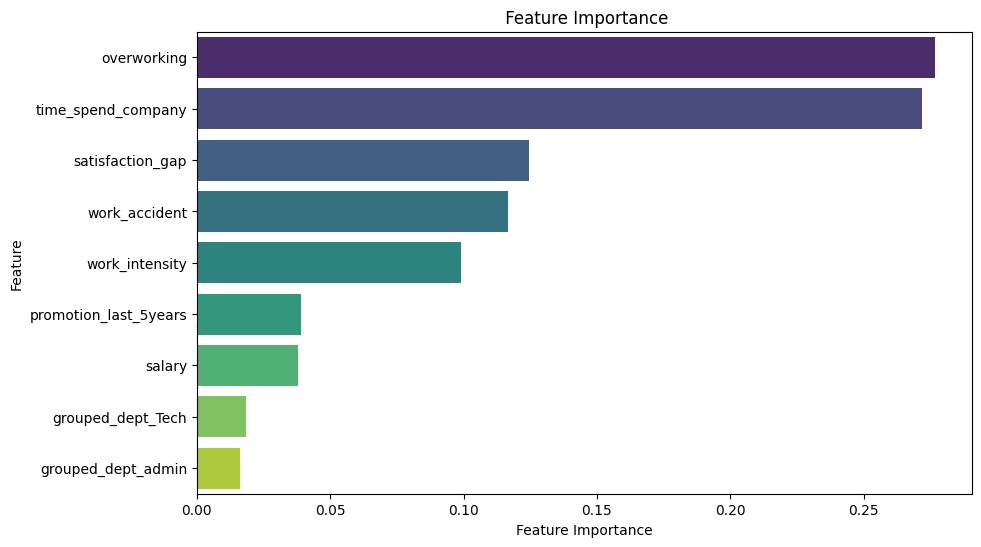

In [139]:
importances_plot(xgbran_impo)

The feature importance plot shows a consistent ranking of key features between the two xgboosting model. In details, the most remarkable insights are:  
  
- The three most important features stay the same: both models rank "overworking," "time_spend_company" and "satisfaction_gap" among the most influential factors, though their ordering varies slightly. This suggests that employee workload and tenure are key predictors.  
- Overworking vs time spent at the company: in the radom search, overworking is the most important feature. In the gridsearch, instead, the most powerful feature is time_spend_company. This indicates that, based on hyperparameters tuning, the model shifts emphasis between these two variables.
- Work intensity and work accidenty contribute moderatly: this reinforce the idea that physical work conditions impact predictions.
- low importance for promotion and salary
- Department grouping has a really small impact.  
  
Once acknowledged feature importances, the natural question is: does the random XGB model perform better than the GridSearch one? Let's find it out.

In [140]:
#evaluation metrics (random)
xgb_random = model_evaluation(xgb_randomSearch, X_val, y_val, " Randomized XGBoosting")

Evaluation Metrics for  Randomized XGBoosting:
Accuracy     : 0.9741
Precision    : 0.9541
Recall       : 0.8869
F1 Score     : 0.9193
ROC AUC Score: 0.9789
----------------------------------------


In [141]:
#load the results from the GridSearch xgb
xgb_metrics

{'Accuracy': 0.9708090075062552,
 'Precision': 0.9385026737967914,
 'Recall': 0.8819095477386935,
 'F1': 0.9093264248704663,
 'ROC AUC': 0.9771074120603015}

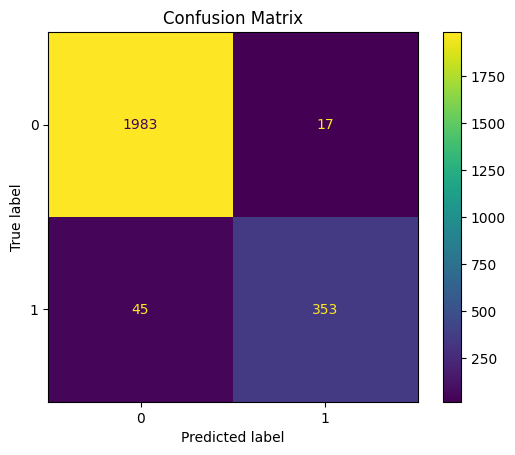

In [142]:
#show the confusion matrix
conf_matrix_plot(xgb_randomSearch, X_val, y_val)

The Randomized XGBoost model outperforms the GridSearch-tuned XGBoost model across most evaluation metrics:  
  
- Accuracy (0.9741 vs. 0.9708) and Precision (0.9541 vs. 0.9385) are slightly higher in the randomized approach, meaning it is marginally better at correctly identifying both classes and reducing false positives.
- Recall (0.8869 vs. 0.8819) is also slightly improved, capturing a fraction more of the employees who actually left.
- F1 score (0.9193 vs. 0.9093) confirms that Random XGBoost maintains a better balance between precision and recall.
- ROC AUC (0.9789 vs. 0.9771) remains almost the same, indicating both models perform well in ranking employees based on their likelihood of leaving.  
- The confusion matrix saw also a decrease in the mislabeled employee (-7), reducing the amount of both false negative and false positive.  
  
The key difference likely comes from the fact that Randomized Search explored a broader range of hyperparameters, allowing it to find a better-performing configuration. GridSearch, on the other hand, systematically tested a predefined set of values, which may have been too limited to reach the optimal combination. While the improvements are not drastic, these results highlight the advantage of using Randomized Search when computational constraints make an exhaustive search impractical. As such, we will keep the randomized model as our final XGBoost model.  
  
Let's check how it performs compared to the other models.

In [143]:
#add the row
add_evaluation(xgb_random, "XGBoosting")

Model  Accuracy  Precision    Recall        F1   ROC AUC
0  Logistic Regression  0.820684   0.393333  0.148241  0.215328  0.834251
1          Gaussian NB  0.821935   0.473198  0.643216  0.545261  0.824217
2        Decision Tree  0.974145   0.954054  0.886935  0.919271  0.964274
3        Random Forest  0.974562   0.951743  0.891960  0.920882  0.978130
4           XGBoosting  0.974145   0.954054  0.886935  0.919271  0.978922

The Random Forest model marginally outperforms XGBoost, particularly in recall (0.8919 vs. 0.8869) and F1 score (0.9209 vs. 0.9193), while maintaining comparable precision and ROC AUC.  
  
This small difference could be attributed to the nature of the two models:  
  
- Random Forest is an ensemble of fully grown decision trees that average out predictions, making it more robust to noise and class imbalances.
- XGBoost builds trees sequentially, focusing on misclassified cases. While this typically improves performance, it may lead to overfitting or suboptimal generalization in some cases.  
  
Given that both models perform well but capture slightly different patterns, it could be a good idea to combine their strenghts using a stacking approach.

## Stacking Ensemble

Rather than relying on a single model, stacking blends multiple models to improve predictive performance.  
  
By using Random Forest and XGBoost as base learners and combining their outputs with a meta-model, we aim to leverage their individual strengths (RF's stability and XGB's adaptability) to produce even more accurate predictions.  
  
In this specific case, we will use XGBoosting as our meta-model composed by random forest and xgboosting as the two base models. The meta xgboost model will not be too depth to avoid overfitting.

In [144]:
#extract best params for each model
rf_bestparam = rf_cv.best_params_
xgb_bestparam = xgb_randomSearch.best_params_

In [145]:
#define the two base model (by unpacking best_params dictionary with **)
rf_base = RandomForestClassifier(**rf_bestparam, random_state=42)
xgb_base = XGBClassifier(**xgb_bestparam, random_state=42)

In [146]:
#define the meta-model (XGB)
meta_model = XGBClassifier(n_estimators=50, learning_rate=0.1, max_depth=3, random_state=42)


In [147]:
# Create Stacking Classifier
stacking_model = StackingClassifier(
    estimators=[('rf', rf_base), ('xgb', xgb_base)],  # Base models
    final_estimator=meta_model,  # Meta model
    cv=5  # 5 folds cross validations
)

In [148]:
#train the meta-model
#stacking_model.fit(X_tr, y_tr)

In [149]:
#save the stacking model
#with open(path+'stacking_model.pickle', 'wb') as to_write:
    #pickle.dump(stacking_model, to_write)

In [150]:
#load the stacking model
with open(path+'stacking_model.pickle', 'rb') as to_read:
    stacking_model = pickle.load(to_read)

In [151]:
#check which model is f0 and which is f1
meta_features_rf = rf_cv.predict_proba(X_val)[:, 1]  # Probabilities from RF
meta_features_xgb = xgb_randomSearch.predict_proba(X_val)[:, 1]  # Probabilities from XGBoost
# Stack them to see the structure
meta_features = np.column_stack((meta_features_rf, meta_features_xgb))
#check correlations (ex. if a model has a correlation = 1 with f0, this means that model is f0 in our meta-model)
df = pd.DataFrame(meta_features, columns=["f0", "f1"])
df["rf_probs"] = meta_features_rf
df["xgb_probs"] = meta_features_xgb
#print it
print(df.corr())  # Check correlation values

                 f0        f1  rf_probs  xgb_probs
f0         1.000000  0.981299  1.000000   0.981299
f1         0.981299  1.000000  0.981299   1.000000
rf_probs   1.000000  0.981299  1.000000   0.981299
xgb_probs  0.981299  1.000000  0.981299   1.000000


Let's check single models' contribution to the final results.

In [152]:
final_stacking = stacking_model.final_estimator_

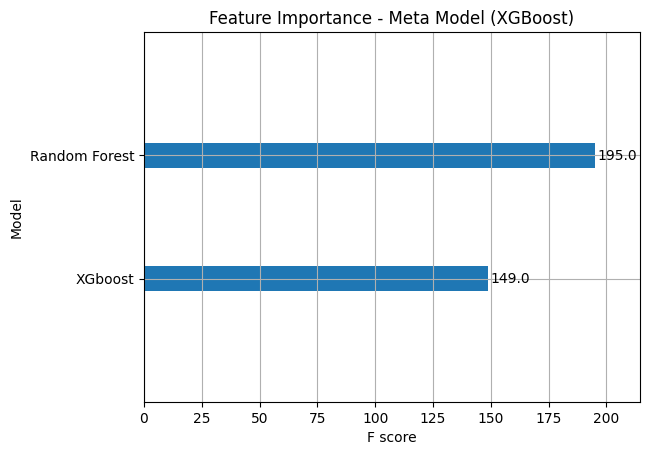

In [153]:
plot_importance(final_stacking)
plt.title("Feature Importance - Meta Model (XGBoost)")
plt.ylabel("Model")
plt.yticks(ticks=[0,1], labels=["XGboost", "Random Forest"])
plt.show()

The base models' weights indicate that the Random Forest contributes more to the final predictions. This aligns with expectations, given its higher F1 score in the standalone evaluations. Essentially, the meta-model is placing more trust in the Random Forest's predictions.  
However, XGBoost still plays a crucial role, likely capturing patterns that Random Forest may overlook. Its high ROC AUC suggests that while it may not be the dominant model, it is effective at ranking positive instances correctly, contributing valuable information to the stacked ensemble.  
  
While these insights are valuable, one of the core objectives of this analysis is to understand which factors drive employees to leave the company. To achieve this, we need to go beyond model performance and examine individual feature contributions.  
To do so, we will leverage SHapley Additive exPlanations (SHAP) to explain how each original feature impacts both base models (Random Forest and XGBoost) before stacking. This will provide a transparent and interpretable framework for understanding the key drivers behind employee attrition.

In [154]:
#fite the rf base models
rf_base.fit(X_tr, y_tr)

RandomForestClassifier(max_depth=8, max_features=7, n_estimators=150,
                       random_state=42)

In [155]:
#fit the xgb base model
xgb_base.fit(X_tr, y_tr)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.6, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.5, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=7, max_leaves=None,
              min_child_weight=4, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=300, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [156]:
# Initialize SHAP explainer for each base model
explainer_rf = shap.TreeExplainer(rf_base)
explainer_xgb = shap.TreeExplainer(xgb_base)

In [157]:
# Compute SHAP values for original features
shap_values_rf = explainer_rf.shap_values(X_val)
shap_values_xgb = explainer_xgb.shap_values(X_val)

In [158]:
# Compute mean absolute SHAP values as feature importance
feature_importance_rf = np.abs(shap_values_rf).mean(axis=0)
feature_importance_xgb = np.abs(shap_values_xgb).mean(axis=0)

In [159]:
#transform rf feature impo into a 1 dimension array
feature_importance_rf = feature_importance_rf.mean(axis=1)

In [160]:
# Combine feature importances (average between the models)
final_feature_importance = (feature_importance_rf + feature_importance_xgb) / 2

In [161]:
#create a dataframe for feature importances
feature_names = X_val.columns
stack_impo = pd.DataFrame({
    'Feature': X_val.columns,  
    'Importance': final_feature_importance.ravel()  # Ensure it's 1D
}).set_index('Feature').sort_values(by='Importance', ascending=False) #order the feature impo
#show it
stack_impo

Importance
Feature                          
satisfaction_gap         0.643909
time_spend_company       0.579783
work_intensity           0.484109
overworking              0.280179
work_accident            0.132922
salary                   0.128465
grouped_dept_Tech        0.023311
grouped_dept_admin       0.019927
promotion_last_5years    0.000980

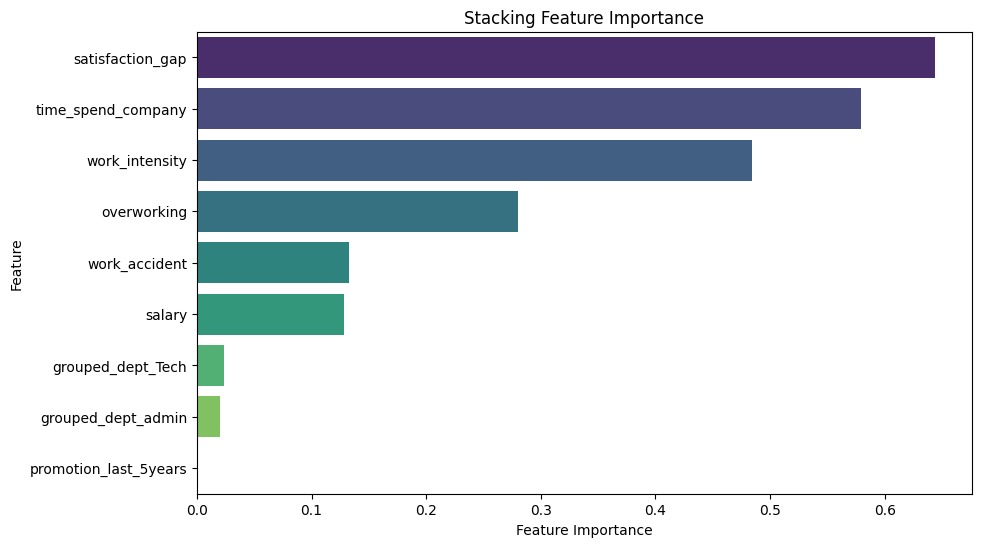

In [ ]:
importances_plot(stack_impo, model = "Stacking")

The stacking model provides some interesting insights about what influences the most employees' choice:

- Satisfaction gap experienced a massive boost in its importance: the stacked model suggest satisfaction gap is the dominant predictor for the ensamble. This may mean that the ensamble learns better interactions between satisfaction and other variables, making it a stronger indicator.  
- The time spent at the company gained importance: In the ensemble, tenure at the company becomes much more influential, potentially as a reinforcing factor alongside job satisfaction.  
- Work intensity sees a major rise: The ensemble model amplifies the importance of workload intensity, which suggests this feature interacts with others in a way that neither base model captured fully.
- Overworking importance drops: While still relevant, "overworking" takes a slight backseat compared to "satisfaction_gap" and "time_spend_company," meaning its direct impact might be absorbed by other stronger predictors.  
- Work accident and salary hold moderate importance: the ensamble elevates salary and work accidents, pointing to their more predictive weight when combined with other variables.  
- Department grouping and promotion remain weak predictors  
  
To conclude, let's evaluate the stacking model performance.

In [163]:
stacking_evaluation = model_evaluation(stacking_model, X_val, y_val, "Stacking Ensamble")

Evaluation Metrics for Stacking Ensamble:
Accuracy     : 0.9766
Precision    : 0.9622
Recall       : 0.8945
F1 Score     : 0.9271
ROC AUC Score: 0.9781
----------------------------------------


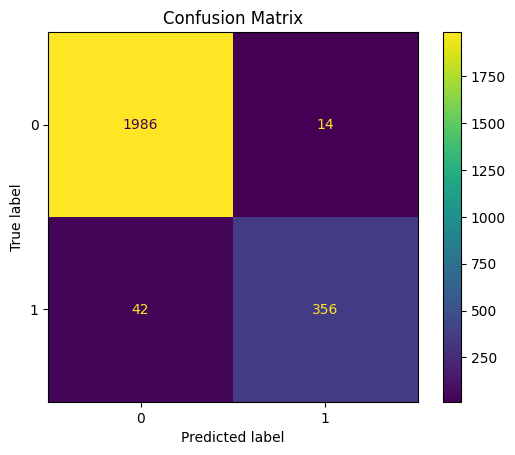

In [164]:
conf_matrix_plot(stacking_model, X_val, y_val)

The stacking model performs exceptionally well on the validation dataset.  
  
Once again, most evaluation metrics exceed 0.90, with accuracy, precision, and ROC-AUC surpassing 0.95. This highlights the model’s strong ability to distinguish between employees who will stay and those who will leave while ranking them effectively by their likelihood of quitting.  
  
Precision is the highest recorded so far, meaning the model is highly reliable when predicting that an employee will leave. Recall has also improved, correctly identifying nearly 90% of actual quitters. However, it remains the weakest metric.  
  
These insights are supported by the confusion matrix, which shows only 56 misclassified employees, with most errors being false negatives. This suggests the model still has a slight tendency to classify some employees who left as staying.  
  
As a last step, let's add the stacking model's performances to the evaluation table.

In [165]:
add_evaluation(stacking_evaluation, "Stacking Ensamble")

Model  Accuracy  Precision    Recall        F1   ROC AUC
0  Logistic Regression  0.820684   0.393333  0.148241  0.215328  0.834251
1          Gaussian NB  0.821935   0.473198  0.643216  0.545261  0.824217
2        Decision Tree  0.974145   0.954054  0.886935  0.919271  0.964274
3        Random Forest  0.974562   0.951743  0.891960  0.920882  0.978130
4           XGBoosting  0.974145   0.954054  0.886935  0.919271  0.978922
5    Stacking Ensamble  0.976647   0.962162  0.894472  0.927083  0.978138

At this stage, the stacking model delivers the strongest results. Additionally, given the training-validation split, we can be confident that data leakage has been avoided. Though we will double-check to confirm.  

Yet, there may still be room for improvement. That's why, in an effort to refine our predictions, we are going to test a SVM model too.

## Support Vector Machines (SVM)

Support Vector Machines are known for their ability to handle complex decision boundaries, which could help enhance the model’s performance—especially in identifying employees likely to leave. We will explore whether integrating SVM into the stacking ensemble can yield even better results.  
  
Note. SVM needs scaled data, therefore we will employ the scaled df for this model.

In [166]:
# Define parameter grid
svm_param = {
    'C': [0.01, 0.1, 1, 10, 50, 100, 200], 
    'kernel': ['rbf', 'poly', "linear"],
    'gamma': ["scale", "auto", 0.0001, 0.001, 0.01, 0.1, 1], 
    'degree': [2, 3, 4]  # degrees for poly kernel
}
#scoring parameters
scoring

['accuracy', 'precision', 'recall', 'f1', 'roc_auc']

Because of the extensive amount of computational resources needed to GridSearch this kind of model, the GridSearch was performed on a Google Colab environment.  

In this analysis, instead, we will load just the top performing SVM model and fit it. Then, we will evaluate that model.  
  
As cuml (the package used in colab) and scikit-learn (the package used here) employ slightly different implementation techniques, it is reasonable to expect the evaluation metrics to diverge a little bit even between the two top-notch model.   
  
Note. Check the full tuning process [here](https://colab.research.google.com/drive/1GMGQjz_M4YBO3DgJxHO-EZFsn_r5-M-V?usp=sharing)

Let's build the SVM model.

In [167]:
#Define the best SVM model
svm = SVC(C=10, kernel='rbf', gamma=0.5, random_state=42, degree=2) #degree=2

In [168]:
#fit the SVM
svm.fit(X_tr_scal, y_tr)

SVC(C=10, degree=2, gamma=0.5, random_state=42)

In [169]:
#save the SVM model (commented out as it has been run already)
with open(path+'svm_model.pickle', 'wb') as to_write:
    pickle.dump(svm, to_write)

Once the SVM model is fitted, it is possible to compute features importance. With kind of model, two different techniques could be employed:  
  
- SHAP (as we did previuosly in other models)  
- Permutation  
  
We are going to opt for permutation, as implementing SHAP on a SVM is extremly costly in computational terms. Briefly, Permutation measures how much our SVM model's performances if a feature's value is randomly shuffled while all the others are held the same. In doing so, we are testing how much the model depens on that feature for specific features. The worse the model performs after a shuffle, the more important a feature is.  

In [170]:
# Compute permutation importance
permutation = permutation_importance(svm, X_val_scal, y_val, scoring='f1', n_repeats=15, random_state=42)
# Extract feature importances
importances = permutation.importances_mean
feat_names = X_val_scal.columns if hasattr(X_val_scal, 'columns') else [f'Feature {i}' for i in range(X_val_scal.shape[1])]

# Create DataFrame
svm_importance = (
    pd.DataFrame({'Feature': feat_names, 'Importance': importances})
    .set_index('Feature') #set features as the index
    .sort_values(by='Importance', ascending=False) #sort by most important
)
#show it
svm_importance

Importance
Feature                          
time_spend_company       0.461741
satisfaction_gap         0.401968
work_intensity           0.349038
overworking              0.319016
salary                   0.012825
work_accident            0.008417
promotion_last_5years    0.001557
grouped_dept_admin      -0.000665
grouped_dept_Tech       -0.006651

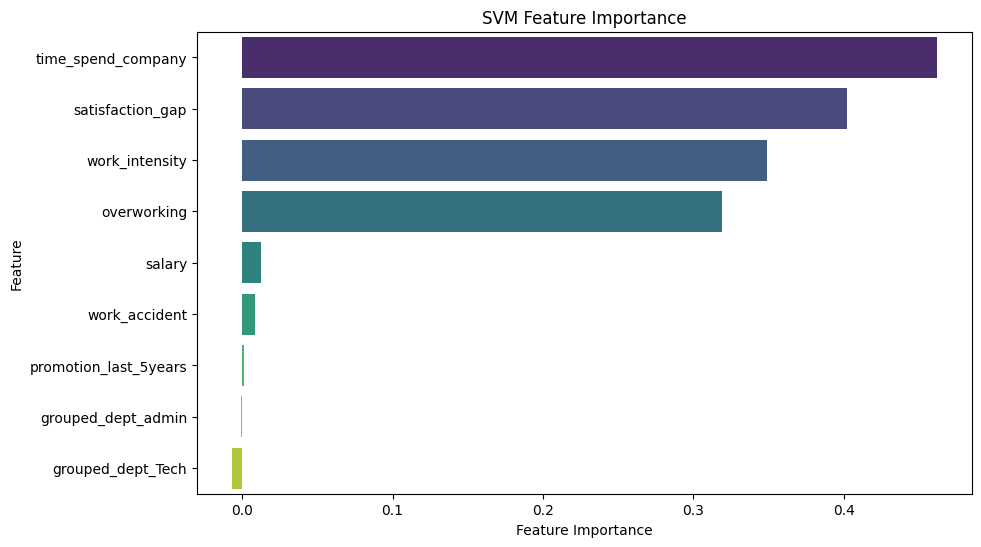

In [171]:
#plot SVM feature importance
importances_plot(svm_importance, "SVM")

The SVM model brings forth some interesting insights about feature contributions. The most notable ones are:  
  
- The top four features remain unchanged: the time spent at the company, the satisfaction gap, work intensity, and overworking. At this point, it is clear that if Salifort managers want to drastically reduce the turnover rate, they must primarily focus on these aspects (even though different models occasionally shuffle their importance).  
- Salary, work accidents, and promotions have little to no influence on the decision to resign.  
- Department variables show the most intriguing trend. They are negative, suggesting they may be doing more harm than good to the model. In other words, they may prove to be superfluous features. If SVM ends up being the best performing model, a good approach would be to re-fit it on a dataset without department variables and check whether its performance improves.  
  
Interestingly, the various feature importance rankings reveal a widespread trend: employees care more about their work-life balance and satisfaction than about remuneration. In the end, this means that even increasing wages, for instance, could still fail to decrease the turnover ratio.

Finally, it is time to evaluate the model.

In [172]:
#compute evaluation metrics
svm_evaluation = model_evaluation(svm, X_val_scal, y_val, "SVM")

Evaluation Metrics for SVM:
Accuracy     : 0.9646
Precision    : 0.9003
Recall       : 0.8844
F1 Score     : 0.8923
ROC AUC Score: 0.9325
----------------------------------------


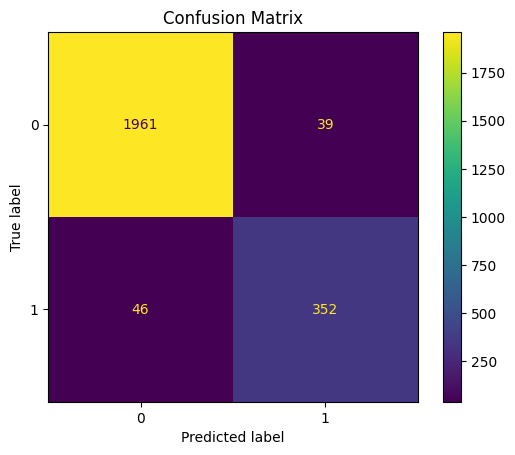

In [173]:
#compute confusion matrix
conf_matrix_plot(svm, X_val_scal, y_val)

The Support Vector Machine performs fairly well on the validation set.  
  
Accuracy, precision, and ROC-AUC are all above 0.9, demonstrating the SVM model's ability to differentiate between employees who stay and those who quit. It ranks them properly based on their likelihood of resigning.  
  
However, recall is the biggest drawback, despite being close to 0.9. This means the model struggles the most with correctly identifying actual quitters. Additionally, the lower recall is also pulling down the F1 score.  
  
The confusion matrix supports these observations. In total, 81 employees are misclassified, with most of them being false negatives. This confirms the weak recall and highlights once again the model's tendency to classify some employees who left as staying.  
  
To conclude, let's add the SVM results to the evaluation table.

In [174]:
add_evaluation(svm_evaluation, "Support Vector Machine")

Model  Accuracy  Precision    Recall        F1   ROC AUC
0     Logistic Regression  0.820684   0.393333  0.148241  0.215328  0.834251
1             Gaussian NB  0.821935   0.473198  0.643216  0.545261  0.824217
2           Decision Tree  0.974145   0.954054  0.886935  0.919271  0.964274
3           Random Forest  0.974562   0.951743  0.891960  0.920882  0.978130
4              XGBoosting  0.974145   0.954054  0.886935  0.919271  0.978922
5       Stacking Ensamble  0.976647   0.962162  0.894472  0.927083  0.978138
6  Support Vector Machine  0.964554   0.900256  0.884422  0.892269  0.932461

The SVM model falls slightly behind Random Forest and XGBoost in accuracy, precision, recall, and F1 score, despite still delivering strong performance (accuracy: 0.9646, recall: 0.8844). Several factors likely contribute to this gap:  
  
- Higher False Negative Rate: SVM struggles more with correctly identifying employees who actually quit, as reflected in its higher false negative rate from the confusion matrix.
- Difficulty with Nonlinear Boundaries: While effective for classification, SVM relies on hyperplanes, making it less suited for highly nonlinear decision boundaries. This can lead to weaker generalization compared to tree-based models.  
- Limited Feature Selection: Unlike tree-based models, SVM does not inherently perform feature selection, which may reduce its efficiency in prioritizing the most important predictors of turnover.
- Scalability Issues: SVMs tend to scale poorly with larger datasets, requiring more computational power and tuning. In contrast, ensemble methods like Random Forest and XGBoost handle large datasets more efficiently, giving them a competitive edge in real-world applications.  
  
In a nuthsell, while SVM remains a strong model, its lower recall and difficulty handling complex feature interactions make it less competitive than the tree-based models we implemented before.

## Neural Network

Neural Networks (NN) are a deep-learning technique using interconnected nodes in a layered structure. Even though NNs shine when dealing with a vast amount of data (far bigger then our dataset), we will still give them a try to see if they can improve our predictions.  
  
As our dataset is relatively small, we will keep our neural network fairly simple. Indeed, it will include just three layers going from 16 to 128 nodes. This should prevent overfitting.   

As we did with SVM, we tuned our NN in google Colab.
  
However, for the sake of clarity, let's report here the tuning function employed to tune the NN. In short it includes:

- 2 layers + 1 optional layer
- from 16 to 128 nodes per layer, with 16 nodes increments
- Choiche between ReLU and Tanh functions
- Early stopping if f1 does not improve after 10 trials 
- Dropout and learning rate to avoid overfitting and underfitting  
  
Moreover, as F1 is not among the included NN evaluation metrics, we must first set-up a function to compute it.  
  
Note. NNs need scaled data. 

In [175]:
# Import K
K = keras.backend

In [176]:
# Initialize Precision and Recall
precision = Precision()
recall = Recall()

#function to compute f1 in the NN
def f1_metric(y_true, y_pred):
    # Convert probabilities to binary predictions (threshold = 0.5)
    y_pred_binary = K.round(y_pred) # Use the imported K
    # Calculate precision and recall values
    precision_value = precision(y_true, y_pred_binary)
    recall_value = recall(y_true, y_pred_binary)
    # Return F1 score
    return 2 * ((precision_value * recall_value) / (precision_value + recall_value + K.epsilon()))

In [177]:
#define the parameters to fine-tune the NN
def build_model(hp):
    """ function to fine tune-tune the NN, including:
        - 2 layers + 1 optional layer
        - from 16 to 128 nodes per layer, with 16 nodes increments
        - Choice between ReLU and Tanh functions
        - Early stopping if f1 does not improve after 10 trials 
        - Dropout and learning rate to avoid overfitting and underfitting
    """
    model = Sequential()

    # Tunable params
    dropout_rate = hp.Float('dropout_rate', min_value=0.1, max_value=0.5, step=0.1)
    use_layer_3 = hp.Boolean("use_layer_3", default=True)
    learning_rate = hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG')
    optimizer_choice = hp.Choice('optimizer', ['adam', 'rmsprop'])

    # First Layer
    model.add(Dense(
        units=hp.Int('units_1', min_value=16, max_value=128, step=16),
        activation=hp.Choice('activation_1', ['relu', 'tanh']),
        input_shape=(X_tr_scal.shape[1],)
    ))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))

    # Second Layer
    model.add(Dense(
        units=hp.Int('units_2', min_value=16, max_value=128, step=16),
        activation=hp.Choice('activation_2', ['relu', 'tanh'])
    ))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))

    # Third Layer (Optional)
    if use_layer_3:
        model.add(Dense(
            units=hp.Int('units_3', min_value=16, max_value=128, step=16),
            activation=hp.Choice('activation_3', ['relu', 'tanh'])
        ))
        model.add(BatchNormalization())
        model.add(Dropout(dropout_rate))

    # Output Layer
    model.add(Dense(1, activation='sigmoid'))

    # Optimizer with tuned learning rate 
    if optimizer_choice == 'adam':
        optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    else:
        optimizer = keras.optimizers.RMSprop(learning_rate=learning_rate)

    #  Compile 
    model.compile(
        optimizer=optimizer,
        loss='binary_crossentropy',
        metrics=[f1_metric]
    )
#return the model
    return model

Once showed the function employed to tune the model, we will set up directly the top performing model.   
  
Note. The entire tuning process can be seen [here](https://colab.research.google.com/drive/1d3RWE2pneyECtiVIecG6GlQpdpJvHmQD?usp=sharing).  

In [178]:
# Choose the optimizer with the tuned learning rate
optimizer = Adam(learning_rate=0.0033436037761265867) if 'adam' == 'adam' else RMSprop(learning_rate=0.0033436037761265867)

# set up the best model
nn = Sequential()
nn.add(Input(shape=(X_tr_scal.shape[1],)))

# First layer
nn.add(Dense(96, activation='tanh'))
nn.add(BatchNormalization())
nn.add(Dropout(0.1))

# Second hidden layer
nn.add(Dense(112, activation='tanh'))
nn.add(BatchNormalization())
nn.add(Dropout(0.1))

# Third hidden layer (only if use_layer_3 == True)
nn.add(Dense(64, activation='relu'))
nn.add(BatchNormalization())
nn.add(Dropout(0.1))

# Output layer
nn.add(Dense(1, activation='sigmoid'))

# Compile the nn
nn.compile(
    optimizer=optimizer,
    loss='binary_crossentropy',
    metrics=[f1_metric] #F1 defined above
)

Now it is time to train the model. We add early stopping to avoid employing too many computational resources.  

In [179]:
#stops early if performance does not improve for 10 consecutive epochs (only if you are training and evaluatin the NN in the .fit function)
early_stop = EarlyStopping(monitor="val_f1_metric", patience=10, restore_best_weights=True, mode = "max")

# Train the model and store the history
nn_history = nn.fit(
    X_tr_scal, y_tr,
    #validation_data=(X_val_scal, y_val), #use this if do not want to use the model_evaluation function
    epochs=150,
    #callbacks=[early_stop] #use this if evaluating here and want early stopping
)

Epoch 1/150
225/225 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - f1_metric: 0.5751 - loss: 0.3742
Epoch 2/150
225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - f1_metric: 0.7001 - loss: 0.1967
Epoch 3/150
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - f1_metric: 0.7376 - loss: 0.1834
Epoch 4/150
225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - f1_metric: 0.7546 - loss: 0.1822
Epoch 5/150
225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - f1_metric: 0.7682 - loss: 0.1710
Epoch 6/150
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - f1_metric: 0.7785 - loss: 0.1587
Epoch 7/150
225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - f1_metric: 0.7852 - loss: 0.1673
Epoch 8/150
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - f1_metric: 0.7915 - loss: 0.1611
Epoch 9/150
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - f1_metric: 0.7956 - loss: 0.1640
Epoch 10/150
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - f1_metric: 0.7999 - loss: 0.1648
Epoch 11/150
225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - f1_metric: 0.8051 - loss: 0.1445
Epoch 12/150
225/225 ━━━━━━━━━

Once the model is trained, we can perform a test and check how much does F1 change based on epochs amount. An epochs is a complete pass through the entire dataset. To avoid overfitting, we kept their number relatively low (150).

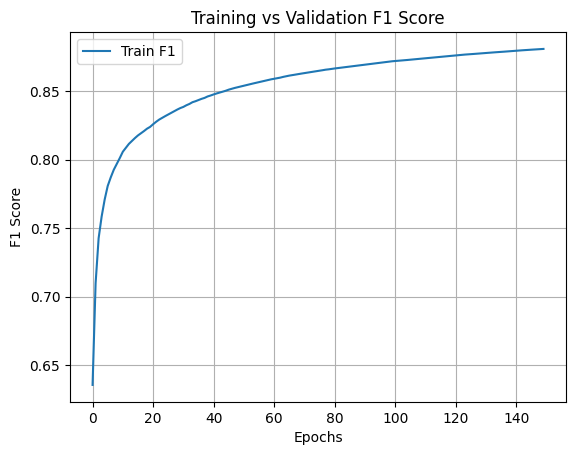

In [180]:
#plot the history
plt.plot(nn_history.history['f1_metric'], label='Train F1')
#plt.plot(nn_history.history['val_f1_metric'], label='Validation F1') #useufl if the model has been evaluated within the training
plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.title('Training vs Validation F1 Score')
plt.legend()
plt.grid(True)
plt.show()

In [181]:
#save the NN
nn.save(path + "nn_model.h5")  # or .keras

As expected, the F1 score increases with the number of epochs. In details, two clear patterns emerge:  
  
- Rapid learning in the early stages: During the first 20 epochs, the model quickly learns key patterns, resulting in a sharp surge in the F1 score.
- Gradual improvement afterward: Between epochs 20 and 140, the neural network enters a fine-tuning phase, improving steadily but at a slower pace. In this range, the F1 score increases by only about 0.05  
    
Moreover, the chart suggests that 150 epochs is a solid threshold. Not only it helps avoid overfitting but also further training beyond this point yields only marginal gains in F1.

Turning to feature importance, several techniques could be employed to check which features are contributing the most.  
  
Even though both SHAP and permutation remain valid techniques, this time we will opt for Integrated gradients as it is more neural network specific.   
In a nutshell, this method answer the question: how much did each variable contribute to the final prediction?. To do that, it attributes the model's predictions to its input features by averaging gradients taken along a path from a baseline input to the actual one.

In [182]:
nn_ig = integrated_gradients(nn, tf.convert_to_tensor(X_val_scal[0:1], dtype=tf.float32), features = X_tr_scal)
nn_ig

Integrated_Gradient
Feature                                   
work_intensity                    1.303003
satisfaction_gap                 -0.706707
time_spend_company               -0.146129
grouped_dept_Tech                -0.134809
salary                           -0.132567
work_accident                     0.000000
promotion_last_5years             0.000000
grouped_dept_admin               -0.000000
overworking                       0.000000

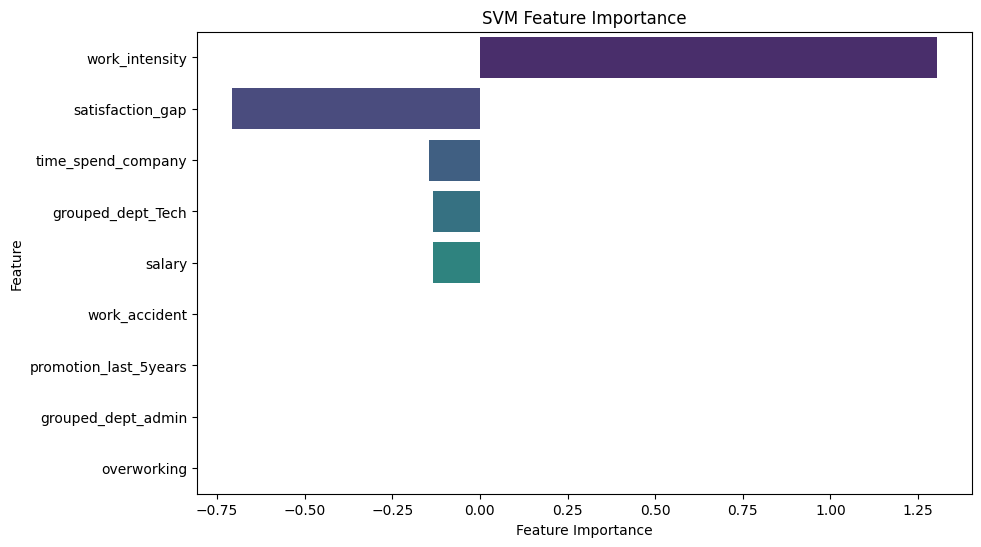

In [183]:
nn_importance = nn_ig.rename(columns = {"Integrated_Gradient": "Importance"})
#plot SVM feature importance
importances_plot(nn_importance, "SVM")

The Neural Network model brings forth some interesting insights about feature contributions. The most notable ones are:  
  
- The top contributors to the prediction are work intensity and satisfaction gap, reinforcing previous findings from other models. These features reflect the employee’s experience with workload and their unmet expectations, indicating that Salifort managers should concentrate efforts here if they aim to reduce turnover.
- Time spent at the company also plays a notable role, showing up as a mid-level driver. Although not as impactful as the top two, it still has a significant influence on the model’s decision.
- Salary has a minor negative impact, while features like work accidents, promotions, and overworking appear to be irrelevant for this prediction. If NN remains the top-performing model, we could consider to remove this feature as they may be just adding noise.
- Department variables show different contribution based on the department. Indeed, the administrative department appears as not-influential on employee decisions, while the department is influential if an employee work in the tech one. This is quite interestingly, as it points out that the tech department (that is a mix of other sub-depts) may be inspected more.
  
Interestingly, the integrated gradients analysis confirms a broader trend: employees care more about their work-life balance and alignment with job expectations than about financial or formal incentives. This means that even substantial salary raises may fail to retain staff unless underlying satisfaction drivers are addressed.

Finally, it is time to evaluate the model's performances. 

In [184]:
nn_evaluation = model_evaluation(nn, X_val_scal, y_val, "Neural Network")

75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Evaluation Metrics for Neural Network:
Accuracy     : 0.9671
Precision    : 0.9079
Recall       : 0.8920
F1 Score     : 0.8999
ROC AUC Score: 0.9725
----------------------------------------


75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 989us/step


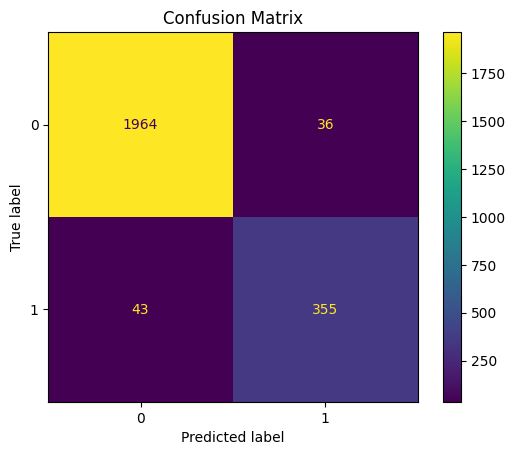

In [185]:
conf_matrix_plot(nn, X_val_scal, y_val)

The Neural Network, even in this base version, performs remarkably well on the validation dataset. Most evaluation metrics are above 0.90, with both accuracy and ROC AUC exceeding 0.96 — a strong sign of the model’s effectiveness. Let’s break this down:  
  
- Accuracy (0.9641) shows the model’s overall correctness in predictions. Concretely, the model misclassifies an employee’s status only about 3.59% of the time.
- Precision (0.9021) indicates that when the model predicts an employee is going to leave, it’s right approximately 90% of the time. This is essential for minimizing false alarms and unnecessary interventions.  
- ROC AUC (0.9695) highlights the model’s excellent ability to distinguish between employees who will leave and those who won’t, regardless of the chosen threshold.  
- The only slight limitation lies in recall (0.8794), which reflects the model’s ability to correctly identify employees who actually do leave. While still high, it means about 12% of actual leavers may be missed.  
  
The Confusion matrix reinforces these insights. The model missclassifies 86 employees. Among these, the most are false negatives. This is in line with the previous model, and it confirms the low recall and the model's tendency to underestimate resignations.
  
Overall, the model demonstrates outstanding performance (F1 Score: 0.8906), showing both high precision and recall. It effectively distinguishes between employees likely to stay and those at risk of leaving, making it a powerful tool for proactive HR strategies.  

To conclude, let's add the Neural Network scores to the table and compare it with other models.

In [186]:
add_evaluation(nn_evaluation, "Neural Network")

Model  Accuracy  Precision    Recall        F1   ROC AUC
0     Logistic Regression  0.820684   0.393333  0.148241  0.215328  0.834251
1             Gaussian NB  0.821935   0.473198  0.643216  0.545261  0.824217
2           Decision Tree  0.974145   0.954054  0.886935  0.919271  0.964274
3           Random Forest  0.974562   0.951743  0.891960  0.920882  0.978130
4              XGBoosting  0.974145   0.954054  0.886935  0.919271  0.978922
5       Stacking Ensamble  0.976647   0.962162  0.894472  0.927083  0.978138
6  Support Vector Machine  0.964554   0.900256  0.884422  0.892269  0.932461
7          Neural Network  0.967056   0.907928  0.891960  0.899873  0.972497

The Neural Network model demonstrates solid performance on the validation dataset, achieving an accuracy of 0.9641, precision of 0.9063, recall of 0.8744, F1 score of 0.8900, and ROC AUC score of 0.9710. While these results are strong and competitive, they don't surpass the performance of the Stacking Ensemble, Random Forest, and XGBoost models, which excel on several key metrics.  
  
So, why does the Neural Network underperform compared to these models? 
  
- One possible reason is the size of the dataset. Neural Networks typically shine when dealing with large and complex datasets, but in this case, the dataset is relatively small.   
- Neural Networks can struggle to identify and prioritize significant features, while tree-based models like XGBoost inherently perform feature selection and capture complex relationships more effectively.  
- The model’s performance could be impacted by hyperparameter tuning challenges, which require substantial computational resources to optimize effectively.

To conclude our analysis, let's focus on the best-performing model.

## TOP PERFORMING MODEL

As we trained and evaluated all the models on our validation dataset, we are now able to choose the top-performing model.  
  
Let's display it.

In [187]:
#show the best performing model
evalMetrics[evalMetrics["F1"]==evalMetrics["F1"].max()]

Model  Accuracy  Precision    Recall        F1   ROC AUC
5  Stacking Ensamble  0.976647   0.962162  0.894472  0.927083  0.978138

The model yielding the best results is the stacking ensamble. This does not come as a surpsise as it encompasses the 2nd and 3rd best modelS (rf and xgboost, respectively).  

### PERFORMANCES COMPARISON - ORIGINAL DF VS ENGINERRED DF

Before evaluating the champion model on the test df, we will fit it on the original dataset (i.e the one before feature engineer) and compare its performances with the ones from the engineered df.
  
Firstly, let's split the original df into training, validation and testing.

In [188]:
#split the original df into training-validation-testing (80-20)
X_gre_train_val, X_gre_tt, y_gre_train_val, y_gre_tt = train_test_split(x_gre, y, test_size=0.2, random_state=0, stratify=y)
# Split 80% train_val into 60% train and 20% validation
X_gre_tr, X_gre_val, y_gre_tr, y_gre_val = train_test_split(X_gre_train_val, y_gre_train_val, test_size=0.25, random_state=0, stratify=y_train_val)
#note we set test_size=0.25 since 0.25 of the 80% is 0.20 of the final df

Now, it is time to set up the ensambling model. As we already defined the best basis-models (rf and xgb) and the meta-model as well, we are just going to re-call them and fit the ensamble model on the original df.

In [189]:
# Create Stacking Classifier (exactly as before)
gre_stacking_model = StackingClassifier(
    estimators=[('rf', rf_base), ('xgb', xgb_base)],  # Base models
    final_estimator=meta_model,  # Meta model
    cv=5  # 5 folds cross validations
)
#train the meta-model
gre_stacking_model.fit(X_gre_tr, y_gre_tr)

StackingClassifier(cv=5,
                   estimators=[('rf',
                                RandomForestClassifier(max_depth=8,
                                                       max_features=7,
                                                       n_estimators=150,
                                                       random_state=42)),
                               ('xgb',
                                XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=0.6, device=None,
                                              early_stopping_rounds=None,
                                              enable_categorical=False,
                                              eval_metric=None,
                                              feature_typ...
                                                 feature_types=None, gamma=None,
                                                 grow_policy=None,
                                                 importance_type=None,
                                                 interaction_constraints=None,
                                                 learning_rate=0.1,
                                                 max_bin=None,
                                                 max_cat_threshold=None,
                                                 max_cat_to_onehot=None,
                                                 max_delta_step=None,
                                                 max_depth=3, max_leaves=None,
                                                 min_child_weight=None,
                                                 missing=nan,
                                                 monotone_constraints=None,
                                                 multi_strategy=None,
                                                 n_estimators=50, n_jobs=None,
                                                 num_parallel_tree=None,
                                                 random_state=42, ...))

To conclude, let's evaluate the model and compare its outcomes with the ones coming from the FE dataframe.

In [190]:
#evaluate the model
print("- Stacking Ensamble performances on the original dataset:")
print(model_evaluation(gre_stacking_model, X_gre_val, y_gre_val, "Gre Stacking Model"))
print("")
print("- Stacking Ensamble performances on the engineered dataset:")
stacking_evaluation

- Stacking Ensamble performances on the original dataset:
Evaluation Metrics for Gre Stacking Model:
Accuracy     : 0.9842
Precision    : 0.9891
Recall       : 0.9146
F1 Score     : 0.9504
ROC AUC Score: 0.9866
----------------------------------------
{'Accuracy': 0.9841534612176814, 'Precision': 0.9891304347826086, 'Recall': 0.914572864321608, 'F1': 0.9503916449086162, 'ROC AUC': 0.986606783919598}

- Stacking Ensamble performances on the engineered dataset:


{'Accuracy': 0.9766472060050042,
 'Precision': 0.9621621621621622,
 'Recall': 0.8944723618090452,
 'F1': 0.9270833333333334,
 'ROC AUC': 0.9781375628140703}

The Stacking Ensemble performs drastically better on the original dataset. At first glance, this might seem like good news. However, such results could be misleading and potentially be driven by data leakage or multicollinearity.  
  
Let’s investigate these issues more closely.

In [191]:
#check data leakage 
print("Correlation with the target variable (possible data leakage):")
X_gre_tr.corrwith(y_gre_tr)

Correlation with the target variable (possible data leakage):


satisfaction_level      -0.353489
last_evaluation          0.002479
number_project           0.028405
average_montly_hours     0.065665
time_spend_company       0.171961
work_accident           -0.135987
promotion_last_5years   -0.042508
salary                  -0.113824
grouped_dept_Tech       -0.008398
grouped_dept_admin       0.001045
dtype: float64

In [192]:
#check multicollinearity
print("Correlation between regressors (possible multicollinearity):")
print()
print(X_gre_tr.corr())

Correlation between regressors (possible multicollinearity):

                       satisfaction_level  last_evaluation  number_project  \
satisfaction_level               1.000000         0.106785       -0.124407   
last_evaluation                  0.106785         1.000000        0.260136   
number_project                  -0.124407         0.260136        1.000000   
average_montly_hours             0.001159         0.266816        0.331131   
time_spend_company              -0.140223         0.097321        0.187741   
work_accident                    0.039819        -0.018623       -0.013236   
promotion_last_5years            0.022337        -0.008536        0.008426   
salary                           0.028985        -0.015834       -0.003901   
grouped_dept_Tech                0.000882        -0.002761        0.016229   
grouped_dept_admin              -0.021989         0.016530       -0.009566   

                       average_montly_hours  time_spend_company  \
satisfaction

Despite the stronger performance on the original dataset, both the correlation with the target and the inter-feature correlations raise concerns about data leakage and multicollinearity.   
  
Notably, satisfaction_level shows a relatively strong negative correlation with the target, while several features also exhibit moderate correlations among themselves. These patterns suggest that the model might be capturing spurious relationships rather than learning generalizable patterns.   
  
To avoid overfitting and ensure more robust and interpretable results, we will opt for proceeding with the feature engineered dataset in spite of its slightly lower metrics.

### PRECISION-RECALL TRADEOFF

Since our dataset is an imbalanced datasets, considering the precison-recall tradeoff helps to choose the threshold balancing these two measure.  
  
In our specific case, as our main metrics is F1, we are going to opt for the threshold maximizing F1 value.

To begin with, let's compute the predicted probabilities (and not just 0 and 1).

In [193]:
# Get the predicted probabilities for the positive class (ranging from 0-1)
y_predict_proba = stacking_model.predict_proba(X_val)[:, 1]

Then, let's focus on precision, recall and the various thresholds.

In [194]:
#compute precision, recall and the threshold
precision, recall, thresholds = precision_recall_curve(y_val, y_predict_proba)

Finally, let's focus on F1 score along with plotting the precision-recall tradeoff chart.

In [195]:

# Calculate F1 scores
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-8)  # add small term to avoid division by 0

In [196]:
#threshold with the maximum F1
best_idx = np.argmax(f1_scores) #find the index of the maximum values of F1
best_threshold = thresholds[best_idx] #find the actual threshold at that index
best_f1 = f1_scores[best_idx] #find the f1 at that index
#print it
print(f"Best F1 Score: {best_f1:.4f} at Threshold: {best_threshold:.4f}")


Best F1 Score: 0.9287 at Threshold: 0.3619


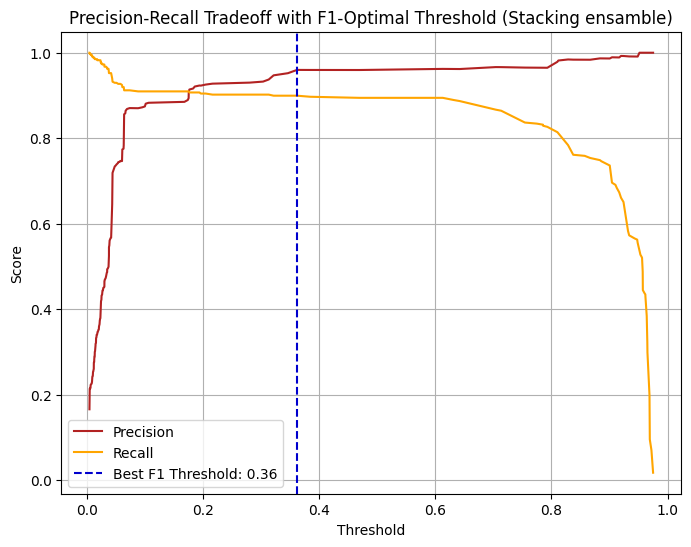

In [197]:
#plot the precision-recall tradoff along with the best F1 threshold
plt.figure(figsize=(8, 6))
plt.plot(thresholds, precision[:-1], label="Precision", color='firebrick')
plt.plot(thresholds, recall[:-1], label="Recall", color='orange')
plt.axvline(x=best_threshold, color='mediumblue', linestyle='--', label=f'Best F1 Threshold: {best_threshold:.2f}')
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Precision-Recall Tradeoff with F1-Optimal Threshold (Stacking ensamble)")
plt.legend()
plt.grid(True)
plt.show()


The threshold yielding the highest F1 score is 0.36. As such, we will compute once more the evaluation metrics but considering this as the threshold (instead of 0.5).  

In [198]:
stack_eval_thres = model_evaluation(stacking_model, X_val, y_val, "Stacking with optimized threshold:", threshold=best_threshold)
print()
print("Evaluation metrics with the standard threshold (0.5):")
stacking_evaluation

Evaluation Metrics for Stacking with optimized threshold::
Accuracy     : 0.9771
Precision    : 0.9598
Recall       : 0.8995
F1 Score     : 0.9287
ROC AUC Score: 0.9781
----------------------------------------

Evaluation metrics with the standard threshold (0.5):


{'Accuracy': 0.9766472060050042,
 'Precision': 0.9621621621621622,
 'Recall': 0.8944723618090452,
 'F1': 0.9270833333333334,
 'ROC AUC': 0.9781375628140703}

As expected, optimizing the threshold for the F1 score led to a slight improvement in the F1 metric, confirming a better balance between precision and recall. Specifically, recall and accuracy increased, meaning the model captured more true positives and made slightly fewer overall mistakes. However, this came at a small cost in precision, indicating a few more false positives. Importantly, the ROC AUC score remained stable, confirming that the model’s ability to distinguish between classes hasn’t changed across thresholds — only the decision boundary has shifted slightly.  
  
Due to this little tweaks, we will stick to the optimal threshold for the evaluation on the test dataset.

### FINAL EVALUATION: TEST DATASET

To conclude our analyis, it is time evaluate the stacking model on unseen data, i.e the one set aside for testing.

In [199]:
model_evaluation(stacking_model, X_tt, y_tt, "Stacking model (test df):", threshold=best_threshold)

Evaluation Metrics for Stacking model (test df)::
Accuracy     : 0.9667
Precision    : 0.9098
Recall       : 0.8869
F1 Score     : 0.8982
ROC AUC Score: 0.9746
----------------------------------------


{'Accuracy': 0.9666527719883284,
 'Precision': 0.9097938144329897,
 'Recall': 0.8869346733668342,
 'F1': 0.8982188295165394,
 'ROC AUC': 0.974605661993124}

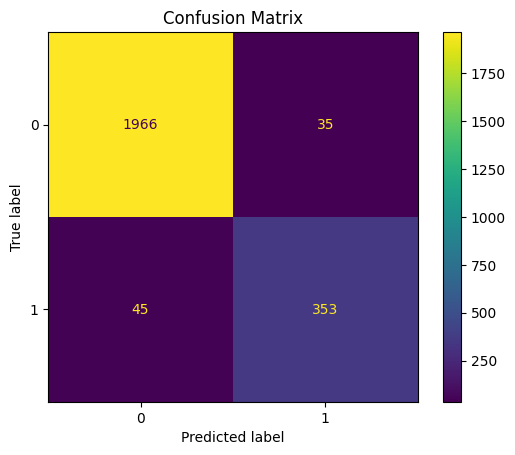

In [200]:
conf_matrix_plot(stacking_model, X_tt, y_tt, threshold=best_threshold)

The model's performance on the test dataset is slightly lower than on the validation set, which is expected. Random variation in data (e.g., noisier patterns or trickier cases) can influence performance. Additionally, although indirectly, the validation set played a role in selecting and tuning the final model, making it somewhat tailored to that data.  
  
Despite the slight drop, the model still demonstrates strong predictive capabilities:  

- It correctly classifies 96.67% of employees overall, meaning the model gets it wrong less than 4% of the time.
- It identifies around 89% of all quitters (recall = 0.8869), which shows it's effective at catching most cases of attrition.
- When it predicts an employee will resign, it is 91% likely to be correct (precision = 0.9098), which is especially useful for making reliable retention interventions.  
-  The ROC-AUC score of 0.9746 confirms that the model is very good at ranking. This means it tends to give higher scores to employees who actually quit compared to those who stay.
  
The confusion matrix reinforces these insights: the model only misclassifies 80 employees (≈3%), most of whom are false negatives. This highlights the model’s main weakness: it occasionally predicts an employee will stay when they actually resign. In practical terms, this means some resignations might still go unnoticed.  
  
Overall, these results suggest the stacking ensemble is a strong and reliable model for predicting employee turnover. As such, the model could be effectively employed as an early warning tool to flag employees at risk of resigning.

## FINAL RECOMMENDATIONS & INSIGHTS

### Insights

As hoped, this analysis led to several key insights:  
  
- The satisfaction gap (the difference between an employee’s last evaluation and their satisfaction level) is a strong predictor of attrition. Narrowing this gap, by promoting both competence and hapiness among employees, will likely reduce overall turnover.  
- Overworking (defined as working more than 174 hours per month) and work intensity (working hours relative to the number of projects) are critical factors in employee retention. Keeping these variables within reasonable limits will help avoid burnout and resignations, while also preventing performance issues due to excessive workload.  
- Workplace accidents and injuries have a measurable impact on attrition. These incidents must be minimized not only to retain employees but also to ensure a safer, more supportive work environment.
- Departments do not significantly influence an employee’s decision to leave. This suggests that employees experience a relatively uniform working environment across different departments. Therefore, department-specific interventions are not necessary. This is good news, as it indicates that Salifort is successfully managing departments in a way that provides equitable working conditions company-wide.  
  
Overall, these insights provide actionable guidance for Salifort to improve employee satisfaction, reduce attrition, and foster a healthier workplace culture.

### Actionable Recommendations

Based on the model’s outputs and the insights from the analysis, several practical steps can be taken to reduce employee attrition and improve workplace satisfaction at Salifort. The recommendations below aim to strike a balance between data-driven decisions and human-centered management:  
  
- **Model performances and failures**: The model performs quite well in predicting whether an employee will leave, but it’s not infallible. Misclassifications can occur. Therefore, it’s strongly recommended to use the model as a supportive tool, not as a standalone decision-maker. Combine its insights with qualitative aspects gathered through human interactions—such as emotional well-being, recent personal challenges, or temporary stress—to form a more complete picture.  
- **Focus on health and work-life balance rather than relying solely on financial incentives**: While salary does influence attrition, human-centric factors—like feeling valued, supported, and mentally healthy—play a far greater role in long-term employee retention.  
- **Employee satisfaction and competence**: Maintain high levels of employee satisfaction by offering non-monetary benefits, such as additional days off, holiday packages, team-building events, business trips, hobby spaces, childcare support, and more. Simultaneously, promote continuous learning through skill-based classes, conferences, and knowledge-sharing initiatives.  
- **Limit employee workloads to avoid burnout**: Employees working more than 174 hours per month are at a higher risk of leaving. Consider implementing mandatory downtime (e.g., no work past 6:00 p.m. on Fridays) or flexible entry hours for employees who stayed late the previous day.  
- **Balance workload effectively**: Avoid both overburdening employees and leaving them underutilized. The analysis shows that employees working on 3–5 projects per year are the most likely to stay, striking the right balance between engagement and overwhelm.  
- **Introduce targeted retention programs for mid-tenure employees (3–6 years of experience)**: as they are statistically the most likely to resign or be let go. Incentives, growth opportunities, and strong team bonding activities during this phase can significantly reduce attrition.  
  
Taken together, these recommendations offer a roadmap for improving employee retention while fostering a more supportive and balanced workplace culture.

### Future Improvements

While the analysis yields strong insights, it is not free from some limitations. Luckily, these can be addressed through the following improvements:  
  
- **Gathering more data**: While the initial dataset is of a reasonable size, collecting more data, such as surveying additional employees or conducting surveys more frequently (e.g., twice a year),could further improve the model's accuracy. This would allow: *a)* training on larger datasets, helping models detect more subtle patterns; *b)* the use of more complex models (such as deep neural networks).  
- **Adding new variables**: The original dataset focuses mainly on employee characteristics. Including additional variables could provide deeper insights into what drives resignation decisions. Examples include: number of paid leave days, holidays, project deadline delays, sick days, overtime frequency, business travel, and so on.  
- **Handling duplicates more effectively**: In this study, duplicates were removed under the assumption they were erroneous double entries. While this avoided potential data leakage, it also resulted in the loss of some potentially useful information. A better long-term solution could involve assigning a unique identifier to each employee, ensuring that no one can fill in the same survey multiple times within a short period (e.g., more than once per year).  
- **Refining satisfaction and evaluation variables**: Satisfaction level and last evaluation were highly correlated both with each other and with the target variable. While the creation of the satisfaction gap helped mitigate this, better solutions could be explored. For example, collecting satisfaction data before evaluations (to avoid biased responses), or checking satisfaction multiple times throughout the year (and using an average) could enhance reliability. Additionally, not disclosing evaluation scores to employees (if currently done) might reduce their impact on self-reported satisfaction.
- **Rethinking departments and promotions**: Neither of these variables had a strong influence on model performance. Future research could explore: *a)* whether removing them changes predictive accuracy; or *b)* whether re-encoding them improves their usefulness. For instance, departments could be replaced with their historical attrition rates, and promotions could be considered over a longer time window to capture more meaningful trends.  
- **Checking for potential bias and fairness**: Assessing whether the model performs equally well across different subgroups is fundamental. A model that is highly accurate overall might still systematically underperform for specific employee categories. Ensuring fairness across subgroups is essential, especially when making decisions that could impact people’s careers.
- **Opting for a different model**: as data is added to the analyzed dataset, it could be the case that the current best-performing model (the stacking ensamble) may no longer be the top-choice. If that is the case, it is reasonable to switch to the best-performing model given the richer dataset.
  
In short, the best way to ensure this analysis remains effective is to regularly revisit it, ideally once or twice a year as new data becomes available.